<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/from_crash/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 780, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 780 (delta 49), reused 50 (delta 23), pack-reused 692 (from 1)
Receiving objects: 100% (780/780), 5.53 MiB | 25.50 MiB/s, done.
Resolving deltas: 100% (504/504), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
0.91% complete (down: 12295.0 kB/s up: 360.0 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[17

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

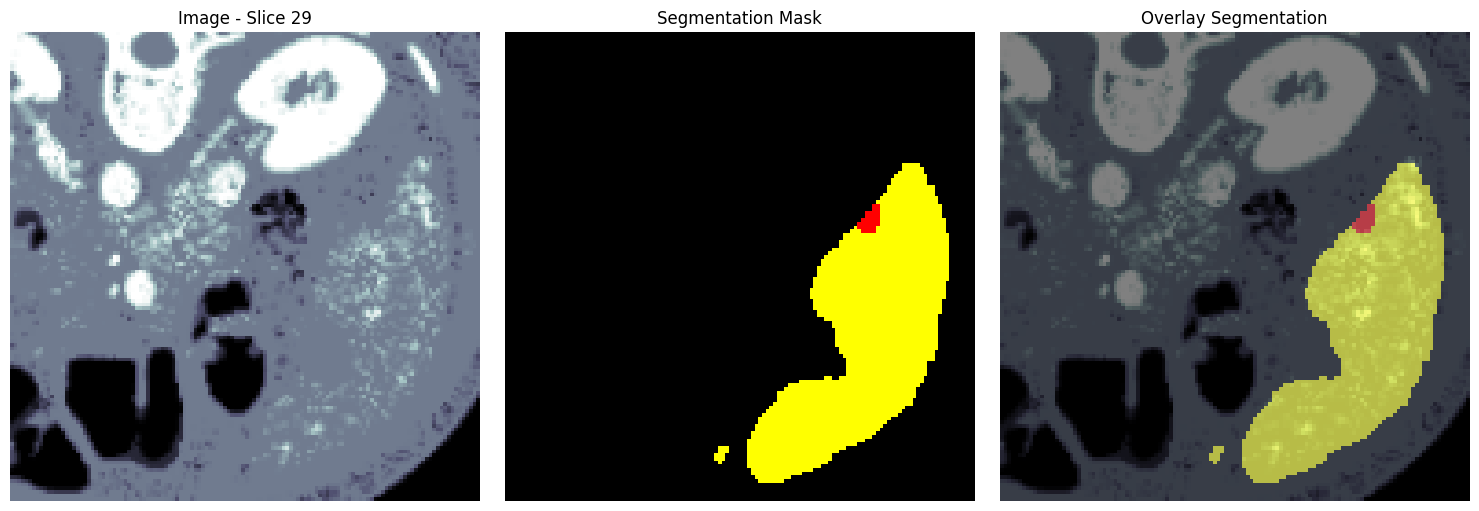

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break


## Model

In [13]:
model = ModelFactory.get_model("unet3d",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [14]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [15]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.9030 time 5.28s
Epoch 1/100 2/105 loss: 0.8740 time 4.75s
Epoch 1/100 3/105 loss: 0.8568 time 5.50s
Epoch 1/100 4/105 loss: 0.8423 time 5.73s
Epoch 1/100 5/105 loss: 0.8298 time 0.89s
Epoch 1/100 6/105 loss: 0.8215 time 4.60s
Epoch 1/100 7/105 loss: 0.8107 time 2.00s
Epoch 1/100 8/105 loss: 0.8008 time 6.08s
Epoch 1/100 9/105 loss: 0.7917 time 5.75s
Epoch 1/100 10/105 loss: 0.7836 time 6.11s
Epoch 1/100 11/105 loss: 0.7788 time 1.88s
Epoch 1/100 12/105 loss: 0.7744 time 4.28s
Epoch 1/100 13/105 loss: 0.7694 time 1.55s
Epoch 1/100 14/105 loss: 0.7654 time 3.74s
Epoch 1/100 15/105 loss: 0.7616 time 7.50s
Epoch 1/100 16/105 loss: 0.7586 time 2.51s
Epoch 1/100 17/105 loss: 0.7551 time 1.30s
Epoch 1/100 18/105 loss: 0.7509 time 5.48s
Epoch 1/100 19/105 loss: 0.7473 time 4.44s
Epoch 1/100 20/105 loss: 0.7445 time 5.40s
Epoch 1/100 21/105 loss: 0.7408 time 6.74s
Epoch 1/100 22/105 loss: 0.7384 time 0.97s
Epoch 1/100 23/105 loss: 0.7350 time 4.58s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.5892] ---[time 377.74s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.5892] ---[time 377.74s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.5892 time 1.69s


Val 1/100 1/26, Dice_Liver: 0.838762, Dice_Tumor: 0.000000, Dice_Avg: 0.419381, time 0.93s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.838762, Dice_Tumor: 0.000000, Dice_Avg: 0.419381, time 0.93s
Val 1/100 2/26, Dice_Liver: 0.846252, Dice_Tumor: 0.000000, Dice_Avg: 0.423126, time 6.07s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.846252, Dice_Tumor: 0.000000, Dice_Avg: 0.423126, time 6.07s
Val 1/100 3/26, Dice_Liver: 0.823510, Dice_Tumor: 0.000000, Dice_Avg: 0.411755, time 1.59s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.823510, Dice_Tumor: 0.000000, Dice_Avg: 0.411755, time 1.59s
Val 1/100 4/26, Dice_Liver: 0.804132, Dice_Tumor: 0.000000, Dice_Avg: 0.402066, time 6.99s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.804132, Dice_Tumor: 0.000000, Dice_Avg: 0.402066, time 6.99s
Val 1/100 5/26, Dice_Liver: 0.797062, Dice_Tumor: 0.000000, Dice_Avg: 0.398531, time 1.98s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.797062, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.379740). At epoch 1


Epoch 1/100 ---[loss: 0.5892] ---[val_dice: 0.379740] ---[time 105.55s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.5892] ---[val_dice: 0.379740] ---[time 105.55s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.4667 time 6.44s
Epoch 2/100 2/105 loss: 0.4658 time 2.27s
Epoch 2/100 3/105 loss: 0.4623 time 6.35s
Epoch 2/100 4/105 loss: 0.4669 time 2.31s
Epoch 2/100 5/105 loss: 0.4725 time 1.31s
Epoch 2/100 6/105 loss: 0.4792 time 2.81s
Epoch 2/100 7/105 loss: 0.4859 time 0.65s
Epoch 2/100 8/105 loss: 0.4827 time 0.79s
Epoch 2/100 9/105 loss: 0.4807 time 1.29s
Epoch 2/100 10/105 loss: 0.4786 time 5.09s
Epoch 2/100 11/105 loss: 0.4771 time 4.64s
Epoch 2/100 12/105 loss: 0.4763 time 4.45s
Epoch 2/100 13/105 loss: 0.4745 time 5.71s
Epoch 2/100 14/105 loss: 0.4735 time 7.35s
Epoch 2/100 15/105 loss: 0.4741 time 9.80s
Epoch 2/100 16/105 loss: 0.4728 time 5.08s
Epoch 2/100 17/105 loss: 0.4715 time 2.64s
Epoch 2/100 18/105 loss: 0.4719 time 3.17s
Epoch 2/100 19/105 loss: 0.4706 time 5.28s
Epoch 2/100 20/105 loss: 0.4703 time 1.51s
Epoch 2/100 21/105 loss: 0.4692 time 1.02s
Epoch 2/100 22/105 loss: 0.4682 time 5.49s
Epoch 2/100 23/105 loss: 0.4677 time 1.99s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.4396] ---[time 403.86s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.4396] ---[time 403.86s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.4396 time 7.15s


Val 2/100 1/26, Dice_Liver: 0.847510, Dice_Tumor: 0.000000, Dice_Avg: 0.423755, time 1.01s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.847510, Dice_Tumor: 0.000000, Dice_Avg: 0.423755, time 1.01s
Val 2/100 2/26, Dice_Liver: 0.843565, Dice_Tumor: 0.000000, Dice_Avg: 0.421783, time 5.56s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.843565, Dice_Tumor: 0.000000, Dice_Avg: 0.421783, time 5.56s
Val 2/100 3/26, Dice_Liver: 0.833363, Dice_Tumor: 0.000000, Dice_Avg: 0.416681, time 1.65s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.833363, Dice_Tumor: 0.000000, Dice_Avg: 0.416681, time 1.65s
Val 2/100 4/26, Dice_Liver: 0.807881, Dice_Tumor: 0.000000, Dice_Avg: 0.403941, time 7.61s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.807881, Dice_Tumor: 0.000000, Dice_Avg: 0.403941, time 7.61s
Val 2/100 5/26, Dice_Liver: 0.802386, Dice_Tumor: 0.000000, Dice_Avg: 0.401193, time 1.57s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.802386, Dice_Tumor: 0.000000, Dice_A

New best (0.379740 --> 0.393674). At epoch 2
Epoch 3/100 1/105 loss: 0.4043 time 5.52s
Epoch 3/100 2/105 loss: 0.4054 time 1.87s
Epoch 3/100 3/105 loss: 0.4103 time 0.79s
Epoch 3/100 4/105 loss: 0.4106 time 7.41s
Epoch 3/100 5/105 loss: 0.4091 time 5.30s
Epoch 3/100 6/105 loss: 0.4088 time 0.81s
Epoch 3/100 7/105 loss: 0.4079 time 4.99s
Epoch 3/100 8/105 loss: 0.4097 time 5.18s
Epoch 3/100 9/105 loss: 0.4099 time 1.51s
Epoch 3/100 10/105 loss: 0.4111 time 5.78s
Epoch 3/100 11/105 loss: 0.4130 time 2.64s
Epoch 3/100 12/105 loss: 0.4130 time 4.45s
Epoch 3/100 13/105 loss: 0.4123 time 0.83s
Epoch 3/100 14/105 loss: 0.4115 time 6.31s
Epoch 3/100 15/105 loss: 0.4110 time 6.30s
Epoch 3/100 16/105 loss: 0.4109 time 1.28s
Epoch 3/100 17/105 loss: 0.4099 time 1.67s
Epoch 3/100 18/105 loss: 0.4091 time 5.62s
Epoch 3/100 19/105 loss: 0.4082 time 4.64s
Epoch 3/100 20/105 loss: 0.4083 time 1.11s
Epoch 3/100 21/105 loss: 0.4079 time 2.62s
Epoch 3/100 22/105 loss: 0.4070 time 7.45s
Epoch 3/100 23/105

Final training epochs: 3/100 ---[loss: 0.4027] ---[time 407.91s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.4027] ---[time 407.91s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.4027 time 1.11s


Val 3/100 1/26, Dice_Liver: 0.841595, Dice_Tumor: 0.000000, Dice_Avg: 0.420797, time 0.94s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.841595, Dice_Tumor: 0.000000, Dice_Avg: 0.420797, time 0.94s
Val 3/100 2/26, Dice_Liver: 0.844602, Dice_Tumor: 0.003425, Dice_Avg: 0.424013, time 5.86s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.844602, Dice_Tumor: 0.003425, Dice_Avg: 0.424013, time 5.86s
Val 3/100 3/26, Dice_Liver: 0.845573, Dice_Tumor: 0.002283, Dice_Avg: 0.423928, time 1.64s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.845573, Dice_Tumor: 0.002283, Dice_Avg: 0.423928, time 1.64s
Val 3/100 4/26, Dice_Liver: 0.824075, Dice_Tumor: 0.001712, Dice_Avg: 0.412894, time 7.88s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.824075, Dice_Tumor: 0.001712, Dice_Avg: 0.412894, time 7.88s
Val 3/100 5/26, Dice_Liver: 0.819910, Dice_Tumor: 0.001370, Dice_Avg: 0.410640, time 1.55s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.819910, Dice_Tumor: 0.001370, Dice_A

New best (0.393674 --> 0.412894). At epoch 3
Epoch 4/100 1/105 loss: 0.4051 time 7.26s
Epoch 4/100 2/105 loss: 0.4024 time 1.39s
Epoch 4/100 3/105 loss: 0.4032 time 7.47s
Epoch 4/100 4/105 loss: 0.4036 time 0.93s
Epoch 4/100 5/105 loss: 0.3963 time 7.32s
Epoch 4/100 6/105 loss: 0.3859 time 4.64s
Epoch 4/100 7/105 loss: 0.3925 time 4.32s
Epoch 4/100 8/105 loss: 0.3954 time 5.15s
Epoch 4/100 9/105 loss: 0.3920 time 4.47s
Epoch 4/100 10/105 loss: 0.3935 time 4.95s
Epoch 4/100 11/105 loss: 0.3927 time 1.40s
Epoch 4/100 12/105 loss: 0.3965 time 8.20s
Epoch 4/100 13/105 loss: 0.3962 time 1.53s
Epoch 4/100 14/105 loss: 0.3975 time 5.68s
Epoch 4/100 15/105 loss: 0.3969 time 1.97s
Epoch 4/100 16/105 loss: 0.3977 time 5.32s
Epoch 4/100 17/105 loss: 0.3995 time 1.94s
Epoch 4/100 18/105 loss: 0.3998 time 0.73s
Epoch 4/100 19/105 loss: 0.3995 time 5.99s
Epoch 4/100 20/105 loss: 0.3996 time 6.34s
Epoch 4/100 21/105 loss: 0.3994 time 0.86s
Epoch 4/100 22/105 loss: 0.4000 time 1.16s
Epoch 4/100 23/105

Final training epochs: 4/100 ---[loss: 0.3944] ---[time 405.16s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3944] ---[time 405.16s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3944 time 4.85s


Val 4/100 1/26, Dice_Liver: 0.771803, Dice_Tumor: 0.000000, Dice_Avg: 0.385901, time 0.95s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.771803, Dice_Tumor: 0.000000, Dice_Avg: 0.385901, time 0.95s
Val 4/100 2/26, Dice_Liver: 0.762743, Dice_Tumor: 0.000000, Dice_Avg: 0.381372, time 5.51s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.762743, Dice_Tumor: 0.000000, Dice_Avg: 0.381372, time 5.51s
Val 4/100 3/26, Dice_Liver: 0.770188, Dice_Tumor: 0.000000, Dice_Avg: 0.385094, time 2.08s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.770188, Dice_Tumor: 0.000000, Dice_Avg: 0.385094, time 2.08s
Val 4/100 4/26, Dice_Liver: 0.744222, Dice_Tumor: 0.000000, Dice_Avg: 0.372111, time 7.01s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.744222, Dice_Tumor: 0.000000, Dice_Avg: 0.372111, time 7.01s
Val 4/100 5/26, Dice_Liver: 0.737967, Dice_Tumor: 0.000000, Dice_Avg: 0.368983, time 1.63s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.737967, Dice_Tumor: 0.000000, Dice_A

Epoch 5/100 1/105 loss: 0.3658 time 7.59s
Epoch 5/100 2/105 loss: 0.3853 time 3.12s
Epoch 5/100 3/105 loss: 0.3792 time 0.98s
Epoch 5/100 4/105 loss: 0.3827 time 1.33s
Epoch 5/100 5/105 loss: 0.3870 time 5.26s
Epoch 5/100 6/105 loss: 0.3864 time 8.83s
Epoch 5/100 7/105 loss: 0.3863 time 5.79s
Epoch 5/100 8/105 loss: 0.3848 time 5.17s
Epoch 5/100 9/105 loss: 0.3837 time 5.65s
Epoch 5/100 10/105 loss: 0.3847 time 1.53s
Epoch 5/100 11/105 loss: 0.3859 time 1.39s
Epoch 5/100 12/105 loss: 0.3877 time 7.24s
Epoch 5/100 13/105 loss: 0.3884 time 2.19s
Epoch 5/100 14/105 loss: 0.3889 time 3.64s
Epoch 5/100 15/105 loss: 0.3873 time 2.13s
Epoch 5/100 16/105 loss: 0.3879 time 5.55s
Epoch 5/100 17/105 loss: 0.3875 time 6.45s
Epoch 5/100 18/105 loss: 0.3868 time 2.67s
Epoch 5/100 19/105 loss: 0.3857 time 5.94s
Epoch 5/100 20/105 loss: 0.3853 time 5.54s
Epoch 5/100 21/105 loss: 0.3867 time 0.67s
Epoch 5/100 22/105 loss: 0.3863 time 5.48s
Epoch 5/100 23/105 loss: 0.3863 time 5.12s
Epoch 5/100 24/105 l

Final training epochs: 5/100 ---[loss: 0.3830] ---[time 405.13s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3830] ---[time 405.13s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3830 time 0.93s


Val 5/100 1/26, Dice_Liver: 0.851663, Dice_Tumor: 0.001801, Dice_Avg: 0.426732, time 1.08s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.851663, Dice_Tumor: 0.001801, Dice_Avg: 0.426732, time 1.08s
Val 5/100 2/26, Dice_Liver: 0.839894, Dice_Tumor: 0.010792, Dice_Avg: 0.425343, time 5.50s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.839894, Dice_Tumor: 0.010792, Dice_Avg: 0.425343, time 5.50s
Val 5/100 3/26, Dice_Liver: 0.842928, Dice_Tumor: 0.037192, Dice_Avg: 0.440060, time 1.67s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.842928, Dice_Tumor: 0.037192, Dice_Avg: 0.440060, time 1.67s
Val 5/100 4/26, Dice_Liver: 0.823699, Dice_Tumor: 0.029646, Dice_Avg: 0.426673, time 7.47s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.823699, Dice_Tumor: 0.029646, Dice_Avg: 0.426673, time 7.47s
Val 5/100 5/26, Dice_Liver: 0.825688, Dice_Tumor: 0.023717, Dice_Avg: 0.424702, time 1.57s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.825688, Dice_Tumor: 0.023717, Dice_A

New best (0.412894 --> 0.438083). At epoch 5
Epoch 6/100 1/105 loss: 0.3846 time 2.08s
Epoch 6/100 2/105 loss: 0.4061 time 1.11s
Epoch 6/100 3/105 loss: 0.3999 time 4.40s
Epoch 6/100 4/105 loss: 0.4025 time 0.86s
Epoch 6/100 5/105 loss: 0.3931 time 5.62s
Epoch 6/100 6/105 loss: 0.3929 time 3.48s
Epoch 6/100 7/105 loss: 0.3928 time 4.73s
Epoch 6/100 8/105 loss: 0.3930 time 1.99s
Epoch 6/100 9/105 loss: 0.3920 time 7.29s
Epoch 6/100 10/105 loss: 0.3921 time 4.54s
Epoch 6/100 11/105 loss: 0.3864 time 5.23s
Epoch 6/100 12/105 loss: 0.3865 time 6.10s
Epoch 6/100 13/105 loss: 0.3860 time 5.77s
Epoch 6/100 14/105 loss: 0.3858 time 1.21s
Epoch 6/100 15/105 loss: 0.3859 time 4.84s
Epoch 6/100 16/105 loss: 0.3859 time 0.73s
Epoch 6/100 17/105 loss: 0.3852 time 1.89s
Epoch 6/100 18/105 loss: 0.3834 time 5.19s
Epoch 6/100 19/105 loss: 0.3830 time 5.90s
Epoch 6/100 20/105 loss: 0.3782 time 5.78s
Epoch 6/100 21/105 loss: 0.3798 time 1.30s
Epoch 6/100 22/105 loss: 0.3774 time 4.55s
Epoch 6/100 23/105

Final training epochs: 6/100 ---[loss: 0.3766] ---[time 406.95s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3766] ---[time 406.95s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3766 time 5.45s


Val 6/100 1/26, Dice_Liver: 0.851916, Dice_Tumor: 0.038530, Dice_Avg: 0.445223, time 1.03s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.851916, Dice_Tumor: 0.038530, Dice_Avg: 0.445223, time 1.03s
Val 6/100 2/26, Dice_Liver: 0.851203, Dice_Tumor: 0.044740, Dice_Avg: 0.447972, time 5.86s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.851203, Dice_Tumor: 0.044740, Dice_Avg: 0.447972, time 5.86s
Val 6/100 3/26, Dice_Liver: 0.835482, Dice_Tumor: 0.055088, Dice_Avg: 0.445285, time 1.60s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.835482, Dice_Tumor: 0.055088, Dice_Avg: 0.445285, time 1.60s
Val 6/100 4/26, Dice_Liver: 0.821677, Dice_Tumor: 0.126768, Dice_Avg: 0.474223, time 6.96s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.821677, Dice_Tumor: 0.126768, Dice_Avg: 0.474223, time 6.96s
Val 6/100 5/26, Dice_Liver: 0.807910, Dice_Tumor: 0.115362, Dice_Avg: 0.461636, time 1.76s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.807910, Dice_Tumor: 0.115362, Dice_A

Epoch 7/100 1/105 loss: 0.2919 time 6.33s
Epoch 7/100 2/105 loss: 0.3387 time 0.86s
Epoch 7/100 3/105 loss: 0.3580 time 5.05s
Epoch 7/100 4/105 loss: 0.3624 time 2.25s
Epoch 7/100 5/105 loss: 0.3668 time 0.75s
Epoch 7/100 6/105 loss: 0.3648 time 3.78s
Epoch 7/100 7/105 loss: 0.3750 time 7.99s
Epoch 7/100 8/105 loss: 0.3690 time 3.50s
Epoch 7/100 9/105 loss: 0.3628 time 4.60s
Epoch 7/100 10/105 loss: 0.3591 time 6.26s
Epoch 7/100 11/105 loss: 0.3605 time 5.55s
Epoch 7/100 12/105 loss: 0.3541 time 4.37s
Epoch 7/100 13/105 loss: 0.3598 time 2.57s
Epoch 7/100 14/105 loss: 0.3636 time 3.53s
Epoch 7/100 15/105 loss: 0.3565 time 8.67s
Epoch 7/100 16/105 loss: 0.3583 time 4.78s
Epoch 7/100 17/105 loss: 0.3615 time 1.16s
Epoch 7/100 18/105 loss: 0.3622 time 0.95s
Epoch 7/100 19/105 loss: 0.3587 time 1.90s
Epoch 7/100 20/105 loss: 0.3636 time 1.17s
Epoch 7/100 21/105 loss: 0.3641 time 5.83s
Epoch 7/100 22/105 loss: 0.3660 time 3.22s
Epoch 7/100 23/105 loss: 0.3669 time 5.21s
Epoch 7/100 24/105 l

Final training epochs: 7/100 ---[loss: 0.3659] ---[time 413.63s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3659] ---[time 413.63s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3659 time 1.46s


Val 7/100 1/26, Dice_Liver: 0.851571, Dice_Tumor: 0.042460, Dice_Avg: 0.447016, time 0.89s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.851571, Dice_Tumor: 0.042460, Dice_Avg: 0.447016, time 0.89s
Val 7/100 2/26, Dice_Liver: 0.851543, Dice_Tumor: 0.041955, Dice_Avg: 0.446749, time 6.10s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.851543, Dice_Tumor: 0.041955, Dice_Avg: 0.446749, time 6.10s
Val 7/100 3/26, Dice_Liver: 0.844807, Dice_Tumor: 0.058704, Dice_Avg: 0.451756, time 1.93s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.844807, Dice_Tumor: 0.058704, Dice_Avg: 0.451756, time 1.93s
Val 7/100 4/26, Dice_Liver: 0.830812, Dice_Tumor: 0.124293, Dice_Avg: 0.477552, time 6.77s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.830812, Dice_Tumor: 0.124293, Dice_Avg: 0.477552, time 6.77s
Val 7/100 5/26, Dice_Liver: 0.818692, Dice_Tumor: 0.099434, Dice_Avg: 0.459063, time 1.80s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.818692, Dice_Tumor: 0.099434, Dice_A

New best (0.438083 --> 0.443347). At epoch 7
Epoch 8/100 1/105 loss: 0.3533 time 2.98s
Epoch 8/100 2/105 loss: 0.3619 time 5.72s
Epoch 8/100 3/105 loss: 0.3539 time 7.70s
Epoch 8/100 4/105 loss: 0.3454 time 5.03s
Epoch 8/100 5/105 loss: 0.3496 time 1.11s
Epoch 8/100 6/105 loss: 0.3575 time 4.51s
Epoch 8/100 7/105 loss: 0.3497 time 1.28s
Epoch 8/100 8/105 loss: 0.3541 time 4.58s
Epoch 8/100 9/105 loss: 0.3598 time 0.82s
Epoch 8/100 10/105 loss: 0.3557 time 1.07s
Epoch 8/100 11/105 loss: 0.3457 time 9.28s
Epoch 8/100 12/105 loss: 0.3429 time 5.35s
Epoch 8/100 13/105 loss: 0.3456 time 6.67s
Epoch 8/100 14/105 loss: 0.3497 time 1.16s
Epoch 8/100 15/105 loss: 0.3514 time 5.16s
Epoch 8/100 16/105 loss: 0.3562 time 9.84s
Epoch 8/100 17/105 loss: 0.3587 time 3.01s
Epoch 8/100 18/105 loss: 0.3599 time 0.75s
Epoch 8/100 19/105 loss: 0.3602 time 1.93s
Epoch 8/100 20/105 loss: 0.3612 time 1.70s
Epoch 8/100 21/105 loss: 0.3633 time 1.13s
Epoch 8/100 22/105 loss: 0.3637 time 1.90s
Epoch 8/100 23/105

Final training epochs: 8/100 ---[loss: 0.3598] ---[time 414.85s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3598] ---[time 414.85s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3598 time 5.03s


Val 8/100 1/26, Dice_Liver: 0.872740, Dice_Tumor: 0.060685, Dice_Avg: 0.466713, time 1.00s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.872740, Dice_Tumor: 0.060685, Dice_Avg: 0.466713, time 1.00s
Val 8/100 2/26, Dice_Liver: 0.863420, Dice_Tumor: 0.044082, Dice_Avg: 0.453751, time 5.91s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.863420, Dice_Tumor: 0.044082, Dice_Avg: 0.453751, time 5.91s
Val 8/100 3/26, Dice_Liver: 0.849594, Dice_Tumor: 0.045004, Dice_Avg: 0.447299, time 1.73s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.849594, Dice_Tumor: 0.045004, Dice_Avg: 0.447299, time 1.73s
Val 8/100 4/26, Dice_Liver: 0.843383, Dice_Tumor: 0.186341, Dice_Avg: 0.514862, time 7.44s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.843383, Dice_Tumor: 0.186341, Dice_Avg: 0.514862, time 7.44s
Val 8/100 5/26, Dice_Liver: 0.834539, Dice_Tumor: 0.159083, Dice_Avg: 0.496811, time 1.71s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.834539, Dice_Tumor: 0.159083, Dice_A

New best (0.443347 --> 0.469925). At epoch 8
Epoch 9/100 1/105 loss: 0.3016 time 2.95s
Epoch 9/100 2/105 loss: 0.3520 time 1.05s
Epoch 9/100 3/105 loss: 0.3695 time 3.36s
Epoch 9/100 4/105 loss: 0.3798 time 5.62s
Epoch 9/100 5/105 loss: 0.3807 time 1.30s
Epoch 9/100 6/105 loss: 0.3759 time 0.98s
Epoch 9/100 7/105 loss: 0.3772 time 4.45s
Epoch 9/100 8/105 loss: 0.3784 time 0.88s
Epoch 9/100 9/105 loss: 0.3781 time 0.91s
Epoch 9/100 10/105 loss: 0.3740 time 0.97s
Epoch 9/100 11/105 loss: 0.3600 time 2.20s
Epoch 9/100 12/105 loss: 0.3622 time 1.74s
Epoch 9/100 13/105 loss: 0.3619 time 7.22s
Epoch 9/100 14/105 loss: 0.3632 time 7.57s
Epoch 9/100 15/105 loss: 0.3636 time 1.59s
Epoch 9/100 16/105 loss: 0.3630 time 0.87s
Epoch 9/100 17/105 loss: 0.3607 time 4.56s
Epoch 9/100 18/105 loss: 0.3616 time 1.83s
Epoch 9/100 19/105 loss: 0.3575 time 5.93s
Epoch 9/100 20/105 loss: 0.3552 time 3.38s
Epoch 9/100 21/105 loss: 0.3572 time 1.33s
Epoch 9/100 22/105 loss: 0.3579 time 6.47s
Epoch 9/100 23/105

Final training epochs: 9/100 ---[loss: 0.3578] ---[time 414.06s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3578] ---[time 414.06s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3578 time 1.65s


Val 9/100 1/26, Dice_Liver: 0.834885, Dice_Tumor: 0.037938, Dice_Avg: 0.436412, time 0.89s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.834885, Dice_Tumor: 0.037938, Dice_Avg: 0.436412, time 0.89s
Val 9/100 2/26, Dice_Liver: 0.814332, Dice_Tumor: 0.028631, Dice_Avg: 0.421481, time 5.59s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.814332, Dice_Tumor: 0.028631, Dice_Avg: 0.421481, time 5.59s
Val 9/100 3/26, Dice_Liver: 0.825810, Dice_Tumor: 0.041895, Dice_Avg: 0.433853, time 1.65s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.825810, Dice_Tumor: 0.041895, Dice_Avg: 0.433853, time 1.65s
Val 9/100 4/26, Dice_Liver: 0.805994, Dice_Tumor: 0.120272, Dice_Avg: 0.463133, time 7.58s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.805994, Dice_Tumor: 0.120272, Dice_Avg: 0.463133, time 7.58s
Val 9/100 5/26, Dice_Liver: 0.800180, Dice_Tumor: 0.114987, Dice_Avg: 0.457583, time 1.54s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.800180, Dice_Tumor: 0.114987, Dice_A

Epoch 10/100 1/105 loss: 0.3699 time 2.36s
Epoch 10/100 2/105 loss: 0.3751 time 7.53s
Epoch 10/100 3/105 loss: 0.3285 time 4.77s
Epoch 10/100 4/105 loss: 0.3172 time 4.52s
Epoch 10/100 5/105 loss: 0.3318 time 0.91s
Epoch 10/100 6/105 loss: 0.3312 time 5.64s
Epoch 10/100 7/105 loss: 0.3387 time 2.29s
Epoch 10/100 8/105 loss: 0.3447 time 1.56s
Epoch 10/100 9/105 loss: 0.3507 time 1.44s
Epoch 10/100 10/105 loss: 0.3558 time 6.08s
Epoch 10/100 11/105 loss: 0.3601 time 3.34s
Epoch 10/100 12/105 loss: 0.3578 time 6.12s
Epoch 10/100 13/105 loss: 0.3598 time 1.52s
Epoch 10/100 14/105 loss: 0.3552 time 5.64s
Epoch 10/100 15/105 loss: 0.3620 time 1.13s
Epoch 10/100 16/105 loss: 0.3640 time 1.37s
Epoch 10/100 17/105 loss: 0.3647 time 6.32s
Epoch 10/100 18/105 loss: 0.3660 time 1.21s
Epoch 10/100 19/105 loss: 0.3653 time 6.11s
Epoch 10/100 20/105 loss: 0.3671 time 0.71s
Epoch 10/100 21/105 loss: 0.3685 time 5.26s
Epoch 10/100 22/105 loss: 0.3680 time 1.50s
Epoch 10/100 23/105 loss: 0.3688 time 5.2

Final training epochs: 10/100 ---[loss: 0.3530] ---[time 415.54s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3530] ---[time 415.54s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3530 time 5.77s


Val 10/100 1/26, Dice_Liver: 0.854418, Dice_Tumor: 0.067574, Dice_Avg: 0.460996, time 0.98s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.854418, Dice_Tumor: 0.067574, Dice_Avg: 0.460996, time 0.98s
Val 10/100 2/26, Dice_Liver: 0.859462, Dice_Tumor: 0.052382, Dice_Avg: 0.455922, time 6.00s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.859462, Dice_Tumor: 0.052382, Dice_Avg: 0.455922, time 6.00s
Val 10/100 3/26, Dice_Liver: 0.829178, Dice_Tumor: 0.051892, Dice_Avg: 0.440535, time 1.72s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.829178, Dice_Tumor: 0.051892, Dice_Avg: 0.440535, time 1.72s
Val 10/100 4/26, Dice_Liver: 0.824904, Dice_Tumor: 0.190692, Dice_Avg: 0.507798, time 7.12s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.824904, Dice_Tumor: 0.190692, Dice_Avg: 0.507798, time 7.12s
Val 10/100 5/26, Dice_Liver: 0.806625, Dice_Tumor: 0.175867, Dice_Avg: 0.491246, time 1.91s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.806625, Dice_Tumor: 0.1758

Epoch 11/100 1/105 loss: 0.3984 time 2.26s
Epoch 11/100 2/105 loss: 0.3580 time 5.64s
Epoch 11/100 3/105 loss: 0.3543 time 1.94s
Epoch 11/100 4/105 loss: 0.3693 time 0.98s
Epoch 11/100 5/105 loss: 0.3715 time 0.89s
Epoch 11/100 6/105 loss: 0.3727 time 1.29s
Epoch 11/100 7/105 loss: 0.3667 time 3.60s
Epoch 11/100 8/105 loss: 0.3675 time 5.20s
Epoch 11/100 9/105 loss: 0.3615 time 5.06s
Epoch 11/100 10/105 loss: 0.3584 time 2.33s
Epoch 11/100 11/105 loss: 0.3604 time 6.19s
Epoch 11/100 12/105 loss: 0.3547 time 6.23s
Epoch 11/100 13/105 loss: 0.3454 time 7.41s
Epoch 11/100 14/105 loss: 0.3493 time 1.42s
Epoch 11/100 15/105 loss: 0.3529 time 1.38s
Epoch 11/100 16/105 loss: 0.3529 time 1.01s
Epoch 11/100 17/105 loss: 0.3543 time 4.93s
Epoch 11/100 18/105 loss: 0.3500 time 1.87s
Epoch 11/100 19/105 loss: 0.3514 time 2.13s
Epoch 11/100 20/105 loss: 0.3456 time 5.34s
Epoch 11/100 21/105 loss: 0.3485 time 3.02s
Epoch 11/100 22/105 loss: 0.3439 time 4.58s
Epoch 11/100 23/105 loss: 0.3463 time 4.9

Final training epochs: 11/100 ---[loss: 0.3532] ---[time 405.57s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3532] ---[time 405.57s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3532 time 8.82s


Val 11/100 1/26, Dice_Liver: 0.871312, Dice_Tumor: 0.012528, Dice_Avg: 0.441920, time 1.10s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.871312, Dice_Tumor: 0.012528, Dice_Avg: 0.441920, time 1.10s
Val 11/100 2/26, Dice_Liver: 0.881888, Dice_Tumor: 0.042669, Dice_Avg: 0.462278, time 4.95s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.881888, Dice_Tumor: 0.042669, Dice_Avg: 0.462278, time 4.95s
Val 11/100 3/26, Dice_Liver: 0.866051, Dice_Tumor: 0.065924, Dice_Avg: 0.465987, time 1.83s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.866051, Dice_Tumor: 0.065924, Dice_Avg: 0.465987, time 1.83s
Val 11/100 4/26, Dice_Liver: 0.857043, Dice_Tumor: 0.121450, Dice_Avg: 0.489246, time 7.05s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.857043, Dice_Tumor: 0.121450, Dice_Avg: 0.489246, time 7.05s
Val 11/100 5/26, Dice_Liver: 0.850256, Dice_Tumor: 0.126141, Dice_Avg: 0.488198, time 1.54s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.850256, Dice_Tumor: 0.1261

Epoch 12/100 1/105 loss: 0.2357 time 5.50s
Epoch 12/100 2/105 loss: 0.3016 time 5.78s
Epoch 12/100 3/105 loss: 0.3269 time 1.14s
Epoch 12/100 4/105 loss: 0.3452 time 5.18s
Epoch 12/100 5/105 loss: 0.3314 time 5.84s
Epoch 12/100 6/105 loss: 0.3337 time 4.04s
Epoch 12/100 7/105 loss: 0.3176 time 5.82s
Epoch 12/100 8/105 loss: 0.3223 time 7.01s
Epoch 12/100 9/105 loss: 0.3289 time 1.41s
Epoch 12/100 10/105 loss: 0.3330 time 7.38s
Epoch 12/100 11/105 loss: 0.3272 time 7.46s
Epoch 12/100 12/105 loss: 0.3337 time 4.20s
Epoch 12/100 13/105 loss: 0.3305 time 6.19s
Epoch 12/100 14/105 loss: 0.3297 time 6.91s
Epoch 12/100 15/105 loss: 0.3306 time 4.50s
Epoch 12/100 16/105 loss: 0.3338 time 0.95s
Epoch 12/100 17/105 loss: 0.3314 time 0.99s
Epoch 12/100 18/105 loss: 0.3342 time 0.69s
Epoch 12/100 19/105 loss: 0.3360 time 6.32s
Epoch 12/100 20/105 loss: 0.3317 time 4.73s
Epoch 12/100 21/105 loss: 0.3342 time 5.39s
Epoch 12/100 22/105 loss: 0.3362 time 0.89s
Epoch 12/100 23/105 loss: 0.3318 time 4.3

Final training epochs: 12/100 ---[loss: 0.3492] ---[time 416.01s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3492] ---[time 416.01s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3492 time 1.81s


Val 12/100 1/26, Dice_Liver: 0.874105, Dice_Tumor: 0.047604, Dice_Avg: 0.460855, time 1.00s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.874105, Dice_Tumor: 0.047604, Dice_Avg: 0.460855, time 1.00s
Val 12/100 2/26, Dice_Liver: 0.879255, Dice_Tumor: 0.060298, Dice_Avg: 0.469777, time 5.89s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.879255, Dice_Tumor: 0.060298, Dice_Avg: 0.469777, time 5.89s
Val 12/100 3/26, Dice_Liver: 0.871524, Dice_Tumor: 0.071137, Dice_Avg: 0.471331, time 1.68s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.871524, Dice_Tumor: 0.071137, Dice_Avg: 0.471331, time 1.68s
Val 12/100 4/26, Dice_Liver: 0.856489, Dice_Tumor: 0.077086, Dice_Avg: 0.466788, time 7.94s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.856489, Dice_Tumor: 0.077086, Dice_Avg: 0.466788, time 7.94s
Val 12/100 5/26, Dice_Liver: 0.860548, Dice_Tumor: 0.115835, Dice_Avg: 0.488191, time 1.55s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.860548, Dice_Tumor: 0.1158

New best (0.469925 --> 0.472953). At epoch 12
Epoch 13/100 1/105 loss: 0.3356 time 6.64s
Epoch 13/100 2/105 loss: 0.3584 time 4.51s
Epoch 13/100 3/105 loss: 0.3741 time 4.02s
Epoch 13/100 4/105 loss: 0.3412 time 4.97s
Epoch 13/100 5/105 loss: 0.3382 time 1.53s
Epoch 13/100 6/105 loss: 0.3447 time 6.63s
Epoch 13/100 7/105 loss: 0.3519 time 3.29s
Epoch 13/100 8/105 loss: 0.3562 time 0.69s
Epoch 13/100 9/105 loss: 0.3489 time 6.56s
Epoch 13/100 10/105 loss: 0.3515 time 1.60s
Epoch 13/100 11/105 loss: 0.3473 time 5.78s
Epoch 13/100 12/105 loss: 0.3487 time 3.89s
Epoch 13/100 13/105 loss: 0.3506 time 2.59s
Epoch 13/100 14/105 loss: 0.3526 time 0.90s
Epoch 13/100 15/105 loss: 0.3476 time 7.23s
Epoch 13/100 16/105 loss: 0.3493 time 1.47s
Epoch 13/100 17/105 loss: 0.3435 time 4.07s
Epoch 13/100 18/105 loss: 0.3483 time 4.86s
Epoch 13/100 19/105 loss: 0.3410 time 4.24s
Epoch 13/100 20/105 loss: 0.3430 time 6.17s
Epoch 13/100 21/105 loss: 0.3422 time 5.63s
Epoch 13/100 22/105 loss: 0.3399 time 1

Final training epochs: 13/100 ---[loss: 0.3453] ---[time 407.37s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3453] ---[time 407.37s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3453 time 5.28s


Val 13/100 1/26, Dice_Liver: 0.885237, Dice_Tumor: 0.041290, Dice_Avg: 0.463263, time 1.02s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.885237, Dice_Tumor: 0.041290, Dice_Avg: 0.463263, time 1.02s
Val 13/100 2/26, Dice_Liver: 0.889906, Dice_Tumor: 0.051508, Dice_Avg: 0.470707, time 6.39s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.889906, Dice_Tumor: 0.051508, Dice_Avg: 0.470707, time 6.39s
Val 13/100 3/26, Dice_Liver: 0.870332, Dice_Tumor: 0.062514, Dice_Avg: 0.466423, time 1.80s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.870332, Dice_Tumor: 0.062514, Dice_Avg: 0.466423, time 1.80s
Val 13/100 4/26, Dice_Liver: 0.860768, Dice_Tumor: 0.111510, Dice_Avg: 0.486139, time 6.87s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.860768, Dice_Tumor: 0.111510, Dice_Avg: 0.486139, time 6.87s
Val 13/100 5/26, Dice_Liver: 0.855266, Dice_Tumor: 0.113645, Dice_Avg: 0.484456, time 1.56s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.855266, Dice_Tumor: 0.1136

New best (0.472953 --> 0.475718). At epoch 13
Epoch 14/100 1/105 loss: 0.3671 time 6.80s
Epoch 14/100 2/105 loss: 0.3604 time 1.21s
Epoch 14/100 3/105 loss: 0.3629 time 2.38s
Epoch 14/100 4/105 loss: 0.3680 time 1.41s
Epoch 14/100 5/105 loss: 0.3536 time 3.23s
Epoch 14/100 6/105 loss: 0.3573 time 1.23s
Epoch 14/100 7/105 loss: 0.3491 time 1.33s
Epoch 14/100 8/105 loss: 0.3498 time 4.50s
Epoch 14/100 9/105 loss: 0.3561 time 2.41s
Epoch 14/100 10/105 loss: 0.3537 time 1.92s
Epoch 14/100 11/105 loss: 0.3405 time 5.84s
Epoch 14/100 12/105 loss: 0.3444 time 1.13s
Epoch 14/100 13/105 loss: 0.3354 time 4.90s
Epoch 14/100 14/105 loss: 0.3273 time 4.62s
Epoch 14/100 15/105 loss: 0.3234 time 5.72s
Epoch 14/100 16/105 loss: 0.3271 time 5.62s
Epoch 14/100 17/105 loss: 0.3242 time 2.39s
Epoch 14/100 18/105 loss: 0.3261 time 2.58s
Epoch 14/100 19/105 loss: 0.3254 time 5.74s
Epoch 14/100 20/105 loss: 0.3286 time 5.86s
Epoch 14/100 21/105 loss: 0.3279 time 6.49s
Epoch 14/100 22/105 loss: 0.3296 time 0

Final training epochs: 14/100 ---[loss: 0.3426] ---[time 420.87s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3426] ---[time 420.87s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3426 time 6.72s


Val 14/100 1/26, Dice_Liver: 0.859103, Dice_Tumor: 0.062766, Dice_Avg: 0.460934, time 1.05s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.859103, Dice_Tumor: 0.062766, Dice_Avg: 0.460934, time 1.05s
Val 14/100 2/26, Dice_Liver: 0.849882, Dice_Tumor: 0.056452, Dice_Avg: 0.453167, time 5.58s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.849882, Dice_Tumor: 0.056452, Dice_Avg: 0.453167, time 5.58s
Val 14/100 3/26, Dice_Liver: 0.856809, Dice_Tumor: 0.172756, Dice_Avg: 0.514782, time 1.73s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.856809, Dice_Tumor: 0.172756, Dice_Avg: 0.514782, time 1.73s
Val 14/100 4/26, Dice_Liver: 0.838151, Dice_Tumor: 0.138026, Dice_Avg: 0.488088, time 7.69s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.838151, Dice_Tumor: 0.138026, Dice_Avg: 0.488088, time 7.69s
Val 14/100 5/26, Dice_Liver: 0.837574, Dice_Tumor: 0.112338, Dice_Avg: 0.474956, time 1.54s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.837574, Dice_Tumor: 0.1123

Epoch 15/100 1/105 loss: 0.3904 time 2.17s
Epoch 15/100 2/105 loss: 0.3292 time 5.56s
Epoch 15/100 3/105 loss: 0.3494 time 1.58s
Epoch 15/100 4/105 loss: 0.3552 time 6.09s
Epoch 15/100 5/105 loss: 0.3596 time 1.54s
Epoch 15/100 6/105 loss: 0.3612 time 0.72s
Epoch 15/100 7/105 loss: 0.3412 time 5.82s
Epoch 15/100 8/105 loss: 0.3266 time 1.55s
Epoch 15/100 9/105 loss: 0.3216 time 3.98s
Epoch 15/100 10/105 loss: 0.3242 time 5.26s
Epoch 15/100 11/105 loss: 0.3276 time 1.08s
Epoch 15/100 12/105 loss: 0.3306 time 5.60s
Epoch 15/100 13/105 loss: 0.3296 time 5.80s
Epoch 15/100 14/105 loss: 0.3288 time 2.42s
Epoch 15/100 15/105 loss: 0.3322 time 0.99s
Epoch 15/100 16/105 loss: 0.3381 time 3.48s
Epoch 15/100 17/105 loss: 0.3408 time 0.79s
Epoch 15/100 18/105 loss: 0.3433 time 5.36s
Epoch 15/100 19/105 loss: 0.3445 time 5.95s
Epoch 15/100 20/105 loss: 0.3425 time 5.54s
Epoch 15/100 21/105 loss: 0.3443 time 0.77s
Epoch 15/100 22/105 loss: 0.3457 time 1.67s
Epoch 15/100 23/105 loss: 0.3420 time 10.

Final training epochs: 15/100 ---[loss: 0.3436] ---[time 416.04s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3436] ---[time 416.04s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3436 time 6.57s


Val 15/100 1/26, Dice_Liver: 0.851985, Dice_Tumor: 0.060269, Dice_Avg: 0.456127, time 1.07s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.851985, Dice_Tumor: 0.060269, Dice_Avg: 0.456127, time 1.07s
Val 15/100 2/26, Dice_Liver: 0.858048, Dice_Tumor: 0.044935, Dice_Avg: 0.451492, time 6.25s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.858048, Dice_Tumor: 0.044935, Dice_Avg: 0.451492, time 6.25s
Val 15/100 3/26, Dice_Liver: 0.863804, Dice_Tumor: 0.069133, Dice_Avg: 0.466468, time 1.71s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.863804, Dice_Tumor: 0.069133, Dice_Avg: 0.466468, time 1.71s
Val 15/100 4/26, Dice_Liver: 0.855116, Dice_Tumor: 0.155350, Dice_Avg: 0.505233, time 7.23s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.855116, Dice_Tumor: 0.155350, Dice_Avg: 0.505233, time 7.23s
Val 15/100 5/26, Dice_Liver: 0.843232, Dice_Tumor: 0.172011, Dice_Avg: 0.507621, time 1.97s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.843232, Dice_Tumor: 0.1720

New best (0.475718 --> 0.480497). At epoch 15
Epoch 16/100 1/105 loss: 0.4318 time 2.14s
Epoch 16/100 2/105 loss: 0.3967 time 10.20s
Epoch 16/100 3/105 loss: 0.3762 time 4.53s
Epoch 16/100 4/105 loss: 0.3348 time 4.18s
Epoch 16/100 5/105 loss: 0.3236 time 1.53s
Epoch 16/100 6/105 loss: 0.3155 time 8.35s
Epoch 16/100 7/105 loss: 0.3258 time 5.18s
Epoch 16/100 8/105 loss: 0.3363 time 0.72s
Epoch 16/100 9/105 loss: 0.3400 time 1.45s
Epoch 16/100 10/105 loss: 0.3245 time 5.83s
Epoch 16/100 11/105 loss: 0.3297 time 2.92s
Epoch 16/100 12/105 loss: 0.3311 time 7.01s
Epoch 16/100 13/105 loss: 0.3203 time 2.23s
Epoch 16/100 14/105 loss: 0.3227 time 0.89s
Epoch 16/100 15/105 loss: 0.3200 time 2.95s
Epoch 16/100 16/105 loss: 0.3238 time 5.04s
Epoch 16/100 17/105 loss: 0.3224 time 5.45s
Epoch 16/100 18/105 loss: 0.3256 time 1.48s
Epoch 16/100 19/105 loss: 0.3296 time 0.91s
Epoch 16/100 20/105 loss: 0.3328 time 1.07s
Epoch 16/100 21/105 loss: 0.3345 time 4.54s
Epoch 16/100 22/105 loss: 0.3362 time 

Final training epochs: 16/100 ---[loss: 0.3386] ---[time 415.32s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3386] ---[time 415.32s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3386 time 1.06s


Val 16/100 1/26, Dice_Liver: 0.867142, Dice_Tumor: 0.277396, Dice_Avg: 0.572269, time 1.05s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.867142, Dice_Tumor: 0.277396, Dice_Avg: 0.572269, time 1.05s
Val 16/100 2/26, Dice_Liver: 0.874750, Dice_Tumor: 0.182620, Dice_Avg: 0.528685, time 5.39s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.874750, Dice_Tumor: 0.182620, Dice_Avg: 0.528685, time 5.39s
Val 16/100 3/26, Dice_Liver: 0.869353, Dice_Tumor: 0.193690, Dice_Avg: 0.531521, time 1.66s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.869353, Dice_Tumor: 0.193690, Dice_Avg: 0.531521, time 1.66s
Val 16/100 4/26, Dice_Liver: 0.859297, Dice_Tumor: 0.242460, Dice_Avg: 0.550879, time 7.66s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.859297, Dice_Tumor: 0.242460, Dice_Avg: 0.550879, time 7.66s
Val 16/100 5/26, Dice_Liver: 0.850746, Dice_Tumor: 0.251964, Dice_Avg: 0.551355, time 1.57s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.850746, Dice_Tumor: 0.2519

New best (0.480497 --> 0.504656). At epoch 16
Epoch 17/100 1/105 loss: 0.2272 time 5.63s
Epoch 17/100 2/105 loss: 0.2869 time 6.61s
Epoch 17/100 3/105 loss: 0.3191 time 4.40s
Epoch 17/100 4/105 loss: 0.2947 time 4.81s
Epoch 17/100 5/105 loss: 0.3095 time 2.70s
Epoch 17/100 6/105 loss: 0.3180 time 5.50s
Epoch 17/100 7/105 loss: 0.3263 time 0.88s
Epoch 17/100 8/105 loss: 0.3232 time 5.99s
Epoch 17/100 9/105 loss: 0.3176 time 2.14s
Epoch 17/100 10/105 loss: 0.3213 time 5.94s
Epoch 17/100 11/105 loss: 0.3217 time 1.59s
Epoch 17/100 12/105 loss: 0.3184 time 1.55s
Epoch 17/100 13/105 loss: 0.3131 time 5.26s
Epoch 17/100 14/105 loss: 0.3034 time 4.88s
Epoch 17/100 15/105 loss: 0.3013 time 5.03s
Epoch 17/100 16/105 loss: 0.3058 time 1.34s
Epoch 17/100 17/105 loss: 0.3103 time 3.24s
Epoch 17/100 18/105 loss: 0.3161 time 1.05s
Epoch 17/100 19/105 loss: 0.3191 time 0.93s
Epoch 17/100 20/105 loss: 0.3191 time 8.81s
Epoch 17/100 21/105 loss: 0.3231 time 6.35s
Epoch 17/100 22/105 loss: 0.3262 time 3

Final training epochs: 17/100 ---[loss: 0.3384] ---[time 413.67s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3384] ---[time 413.67s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3384 time 6.19s


Val 17/100 1/26, Dice_Liver: 0.896987, Dice_Tumor: 0.148547, Dice_Avg: 0.522767, time 1.02s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.896987, Dice_Tumor: 0.148547, Dice_Avg: 0.522767, time 1.02s
Val 17/100 2/26, Dice_Liver: 0.901638, Dice_Tumor: 0.098443, Dice_Avg: 0.500040, time 5.45s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.901638, Dice_Tumor: 0.098443, Dice_Avg: 0.500040, time 5.45s
Val 17/100 3/26, Dice_Liver: 0.902963, Dice_Tumor: 0.160562, Dice_Avg: 0.531762, time 1.72s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.902963, Dice_Tumor: 0.160562, Dice_Avg: 0.531762, time 1.72s
Val 17/100 4/26, Dice_Liver: 0.889622, Dice_Tumor: 0.176429, Dice_Avg: 0.533026, time 7.40s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.889622, Dice_Tumor: 0.176429, Dice_Avg: 0.533026, time 7.40s
Val 17/100 5/26, Dice_Liver: 0.891112, Dice_Tumor: 0.185861, Dice_Avg: 0.538486, time 1.59s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.891112, Dice_Tumor: 0.1858

New best (0.504656 --> 0.526853). At epoch 17
Epoch 18/100 1/105 loss: 0.3824 time 2.16s
Epoch 18/100 2/105 loss: 0.3821 time 6.19s
Epoch 18/100 3/105 loss: 0.3830 time 5.68s
Epoch 18/100 4/105 loss: 0.3415 time 4.72s
Epoch 18/100 5/105 loss: 0.3375 time 0.77s
Epoch 18/100 6/105 loss: 0.3263 time 6.72s
Epoch 18/100 7/105 loss: 0.3210 time 5.70s
Epoch 18/100 8/105 loss: 0.3134 time 7.13s
Epoch 18/100 9/105 loss: 0.3124 time 5.44s
Epoch 18/100 10/105 loss: 0.3179 time 7.01s
Epoch 18/100 11/105 loss: 0.3247 time 2.57s
Epoch 18/100 12/105 loss: 0.3281 time 0.72s
Epoch 18/100 13/105 loss: 0.3314 time 0.89s
Epoch 18/100 14/105 loss: 0.3330 time 1.08s
Epoch 18/100 15/105 loss: 0.3314 time 1.65s
Epoch 18/100 16/105 loss: 0.3340 time 1.22s
Epoch 18/100 17/105 loss: 0.3369 time 1.01s
Epoch 18/100 18/105 loss: 0.3311 time 5.37s
Epoch 18/100 19/105 loss: 0.3314 time 7.49s
Epoch 18/100 20/105 loss: 0.3293 time 2.37s
Epoch 18/100 21/105 loss: 0.3320 time 1.95s
Epoch 18/100 22/105 loss: 0.3273 time 1

Final training epochs: 18/100 ---[loss: 0.3407] ---[time 410.07s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3407] ---[time 410.07s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3407 time 5.78s


Val 18/100 1/26, Dice_Liver: 0.870332, Dice_Tumor: 0.110615, Dice_Avg: 0.490473, time 1.27s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.870332, Dice_Tumor: 0.110615, Dice_Avg: 0.490473, time 1.27s
Val 18/100 2/26, Dice_Liver: 0.875552, Dice_Tumor: 0.075819, Dice_Avg: 0.475685, time 5.62s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.875552, Dice_Tumor: 0.075819, Dice_Avg: 0.475685, time 5.62s
Val 18/100 3/26, Dice_Liver: 0.876593, Dice_Tumor: 0.175150, Dice_Avg: 0.525872, time 1.67s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.876593, Dice_Tumor: 0.175150, Dice_Avg: 0.525872, time 1.67s
Val 18/100 4/26, Dice_Liver: 0.863565, Dice_Tumor: 0.177807, Dice_Avg: 0.520686, time 7.40s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.863565, Dice_Tumor: 0.177807, Dice_Avg: 0.520686, time 7.40s
Val 18/100 5/26, Dice_Liver: 0.856959, Dice_Tumor: 0.187770, Dice_Avg: 0.522364, time 1.55s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.856959, Dice_Tumor: 0.1877

Epoch 19/100 1/105 loss: 0.2993 time 3.73s
Epoch 19/100 2/105 loss: 0.3244 time 7.84s
Epoch 19/100 3/105 loss: 0.2986 time 6.62s
Epoch 19/100 4/105 loss: 0.3086 time 1.56s
Epoch 19/100 5/105 loss: 0.3227 time 1.37s
Epoch 19/100 6/105 loss: 0.3263 time 0.81s
Epoch 19/100 7/105 loss: 0.3321 time 7.07s
Epoch 19/100 8/105 loss: 0.3378 time 1.17s
Epoch 19/100 9/105 loss: 0.3408 time 5.80s
Epoch 19/100 10/105 loss: 0.3308 time 5.48s
Epoch 19/100 11/105 loss: 0.3345 time 5.65s
Epoch 19/100 12/105 loss: 0.3312 time 6.02s
Epoch 19/100 13/105 loss: 0.3344 time 2.21s
Epoch 19/100 14/105 loss: 0.3246 time 4.52s
Epoch 19/100 15/105 loss: 0.3214 time 5.91s
Epoch 19/100 16/105 loss: 0.3251 time 1.55s
Epoch 19/100 17/105 loss: 0.3182 time 1.89s
Epoch 19/100 18/105 loss: 0.3137 time 5.60s
Epoch 19/100 19/105 loss: 0.3134 time 2.19s
Epoch 19/100 20/105 loss: 0.3076 time 4.64s
Epoch 19/100 21/105 loss: 0.3087 time 7.28s
Epoch 19/100 22/105 loss: 0.3105 time 1.29s
Epoch 19/100 23/105 loss: 0.3083 time 5.6

Final training epochs: 19/100 ---[loss: 0.3280] ---[time 409.27s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3280] ---[time 409.27s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3280 time 1.47s


Val 19/100 1/26, Dice_Liver: 0.849797, Dice_Tumor: 0.157523, Dice_Avg: 0.503660, time 1.01s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.849797, Dice_Tumor: 0.157523, Dice_Avg: 0.503660, time 1.01s
Val 19/100 2/26, Dice_Liver: 0.873110, Dice_Tumor: 0.124947, Dice_Avg: 0.499028, time 5.39s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.873110, Dice_Tumor: 0.124947, Dice_Avg: 0.499028, time 5.39s
Val 19/100 3/26, Dice_Liver: 0.865498, Dice_Tumor: 0.143285, Dice_Avg: 0.504392, time 1.67s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.865498, Dice_Tumor: 0.143285, Dice_Avg: 0.504392, time 1.67s
Val 19/100 4/26, Dice_Liver: 0.857901, Dice_Tumor: 0.245590, Dice_Avg: 0.551746, time 7.64s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.857901, Dice_Tumor: 0.245590, Dice_Avg: 0.551746, time 7.64s
Val 19/100 5/26, Dice_Liver: 0.847058, Dice_Tumor: 0.266352, Dice_Avg: 0.556705, time 1.67s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.847058, Dice_Tumor: 0.2663

Epoch 20/100 1/105 loss: 0.3701 time 2.19s
Epoch 20/100 2/105 loss: 0.3706 time 3.24s
Epoch 20/100 3/105 loss: 0.3726 time 6.97s
Epoch 20/100 4/105 loss: 0.3818 time 0.82s
Epoch 20/100 5/105 loss: 0.3838 time 1.50s
Epoch 20/100 6/105 loss: 0.3727 time 4.51s
Epoch 20/100 7/105 loss: 0.3728 time 5.69s
Epoch 20/100 8/105 loss: 0.3544 time 4.71s
Epoch 20/100 9/105 loss: 0.3584 time 1.15s
Epoch 20/100 10/105 loss: 0.3531 time 6.39s
Epoch 20/100 11/105 loss: 0.3419 time 1.58s
Epoch 20/100 12/105 loss: 0.3440 time 6.68s
Epoch 20/100 13/105 loss: 0.3439 time 1.46s
Epoch 20/100 14/105 loss: 0.3408 time 6.05s
Epoch 20/100 15/105 loss: 0.3376 time 3.27s
Epoch 20/100 16/105 loss: 0.3307 time 7.93s
Epoch 20/100 17/105 loss: 0.3355 time 3.93s
Epoch 20/100 18/105 loss: 0.3305 time 5.33s
Epoch 20/100 19/105 loss: 0.3299 time 2.25s
Epoch 20/100 20/105 loss: 0.3254 time 5.03s
Epoch 20/100 21/105 loss: 0.3281 time 1.27s
Epoch 20/100 22/105 loss: 0.3312 time 4.98s
Epoch 20/100 23/105 loss: 0.3264 time 2.3

Final training epochs: 20/100 ---[loss: 0.3323] ---[time 414.48s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3323] ---[time 414.48s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3323 time 1.71s


Val 20/100 1/26, Dice_Liver: 0.889091, Dice_Tumor: 0.164232, Dice_Avg: 0.526661, time 0.94s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.889091, Dice_Tumor: 0.164232, Dice_Avg: 0.526661, time 0.94s
Val 20/100 2/26, Dice_Liver: 0.896358, Dice_Tumor: 0.129434, Dice_Avg: 0.512896, time 5.63s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.896358, Dice_Tumor: 0.129434, Dice_Avg: 0.512896, time 5.63s
Val 20/100 3/26, Dice_Liver: 0.893039, Dice_Tumor: 0.160543, Dice_Avg: 0.526791, time 2.01s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.893039, Dice_Tumor: 0.160543, Dice_Avg: 0.526791, time 2.01s
Val 20/100 4/26, Dice_Liver: 0.883334, Dice_Tumor: 0.230229, Dice_Avg: 0.556782, time 7.25s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.883334, Dice_Tumor: 0.230229, Dice_Avg: 0.556782, time 7.25s
Val 20/100 5/26, Dice_Liver: 0.875793, Dice_Tumor: 0.241582, Dice_Avg: 0.558688, time 1.60s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.875793, Dice_Tumor: 0.2415

Epoch 21/100 1/105 loss: 0.4132 time 2.67s
Epoch 21/100 2/105 loss: 0.3869 time 6.30s
Epoch 21/100 3/105 loss: 0.3484 time 5.58s
Epoch 21/100 4/105 loss: 0.3158 time 5.73s
Epoch 21/100 5/105 loss: 0.3122 time 1.12s
Epoch 21/100 6/105 loss: 0.3200 time 6.10s
Epoch 21/100 7/105 loss: 0.3120 time 6.35s
Epoch 21/100 8/105 loss: 0.3025 time 4.40s
Epoch 21/100 9/105 loss: 0.3006 time 0.91s
Epoch 21/100 10/105 loss: 0.3101 time 2.35s
Epoch 21/100 11/105 loss: 0.3185 time 5.19s
Epoch 21/100 12/105 loss: 0.3182 time 3.27s
Epoch 21/100 13/105 loss: 0.3221 time 2.44s
Epoch 21/100 14/105 loss: 0.3262 time 1.23s
Epoch 21/100 15/105 loss: 0.3290 time 0.74s
Epoch 21/100 16/105 loss: 0.3319 time 1.74s
Epoch 21/100 17/105 loss: 0.3329 time 6.31s
Epoch 21/100 18/105 loss: 0.3340 time 1.56s
Epoch 21/100 19/105 loss: 0.3363 time 0.93s
Epoch 21/100 20/105 loss: 0.3380 time 1.48s
Epoch 21/100 21/105 loss: 0.3394 time 7.61s
Epoch 21/100 22/105 loss: 0.3363 time 2.27s
Epoch 21/100 23/105 loss: 0.3380 time 5.0

Final training epochs: 21/100 ---[loss: 0.3314] ---[time 411.22s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3314] ---[time 411.22s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3314 time 5.71s


Val 21/100 1/26, Dice_Liver: 0.883722, Dice_Tumor: 0.142630, Dice_Avg: 0.513176, time 1.04s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.883722, Dice_Tumor: 0.142630, Dice_Avg: 0.513176, time 1.04s
Val 21/100 2/26, Dice_Liver: 0.905592, Dice_Tumor: 0.107923, Dice_Avg: 0.506758, time 5.73s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.905592, Dice_Tumor: 0.107923, Dice_Avg: 0.506758, time 5.73s
Val 21/100 3/26, Dice_Liver: 0.903395, Dice_Tumor: 0.130215, Dice_Avg: 0.516805, time 2.05s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.903395, Dice_Tumor: 0.130215, Dice_Avg: 0.516805, time 2.05s
Val 21/100 4/26, Dice_Liver: 0.894348, Dice_Tumor: 0.271761, Dice_Avg: 0.583054, time 6.89s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.894348, Dice_Tumor: 0.271761, Dice_Avg: 0.583054, time 6.89s
Val 21/100 5/26, Dice_Liver: 0.889267, Dice_Tumor: 0.293089, Dice_Avg: 0.591178, time 1.54s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.889267, Dice_Tumor: 0.2930

New best (0.526853 --> 0.544454). At epoch 21
Epoch 22/100 1/105 loss: 0.3809 time 8.22s
Epoch 22/100 2/105 loss: 0.2882 time 4.89s
Epoch 22/100 3/105 loss: 0.3037 time 6.30s
Epoch 22/100 4/105 loss: 0.3222 time 4.49s
Epoch 22/100 5/105 loss: 0.2986 time 4.23s
Epoch 22/100 6/105 loss: 0.3110 time 0.70s
Epoch 22/100 7/105 loss: 0.3223 time 5.54s
Epoch 22/100 8/105 loss: 0.3230 time 1.96s
Epoch 22/100 9/105 loss: 0.3234 time 1.41s
Epoch 22/100 10/105 loss: 0.3309 time 3.32s
Epoch 22/100 11/105 loss: 0.3351 time 1.03s
Epoch 22/100 12/105 loss: 0.3279 time 4.98s
Epoch 22/100 13/105 loss: 0.3312 time 5.60s
Epoch 22/100 14/105 loss: 0.3354 time 1.55s
Epoch 22/100 15/105 loss: 0.3373 time 8.11s
Epoch 22/100 16/105 loss: 0.3396 time 0.90s
Epoch 22/100 17/105 loss: 0.3419 time 0.74s
Epoch 22/100 18/105 loss: 0.3439 time 7.01s
Epoch 22/100 19/105 loss: 0.3453 time 5.88s
Epoch 22/100 20/105 loss: 0.3433 time 5.69s
Epoch 22/100 21/105 loss: 0.3444 time 5.65s
Epoch 22/100 22/105 loss: 0.3437 time 6

Final training epochs: 22/100 ---[loss: 0.3276] ---[time 412.11s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3276] ---[time 412.11s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3276 time 5.97s


Val 22/100 1/26, Dice_Liver: 0.867036, Dice_Tumor: 0.093750, Dice_Avg: 0.480393, time 1.09s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.867036, Dice_Tumor: 0.093750, Dice_Avg: 0.480393, time 1.09s
Val 22/100 2/26, Dice_Liver: 0.886712, Dice_Tumor: 0.113654, Dice_Avg: 0.500183, time 6.32s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.886712, Dice_Tumor: 0.113654, Dice_Avg: 0.500183, time 6.32s
Val 22/100 3/26, Dice_Liver: 0.892046, Dice_Tumor: 0.191214, Dice_Avg: 0.541630, time 1.82s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.892046, Dice_Tumor: 0.191214, Dice_Avg: 0.541630, time 1.82s
Val 22/100 4/26, Dice_Liver: 0.883463, Dice_Tumor: 0.289353, Dice_Avg: 0.586408, time 6.77s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.883463, Dice_Tumor: 0.289353, Dice_Avg: 0.586408, time 6.77s
Val 22/100 5/26, Dice_Liver: 0.879084, Dice_Tumor: 0.317762, Dice_Avg: 0.598423, time 1.50s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.879084, Dice_Tumor: 0.3177

New best (0.544454 --> 0.544503). At epoch 22
Epoch 23/100 1/105 loss: 0.3823 time 2.09s
Epoch 23/100 2/105 loss: 0.3823 time 5.71s
Epoch 23/100 3/105 loss: 0.3316 time 4.82s
Epoch 23/100 4/105 loss: 0.3471 time 2.07s
Epoch 23/100 5/105 loss: 0.3348 time 0.93s
Epoch 23/100 6/105 loss: 0.3413 time 3.35s
Epoch 23/100 7/105 loss: 0.3477 time 2.65s
Epoch 23/100 8/105 loss: 0.3499 time 6.61s
Epoch 23/100 9/105 loss: 0.3430 time 5.44s
Epoch 23/100 10/105 loss: 0.3448 time 1.47s
Epoch 23/100 11/105 loss: 0.3480 time 1.15s
Epoch 23/100 12/105 loss: 0.3450 time 4.97s
Epoch 23/100 13/105 loss: 0.3319 time 4.90s
Epoch 23/100 14/105 loss: 0.3294 time 6.33s
Epoch 23/100 15/105 loss: 0.3282 time 6.68s
Epoch 23/100 16/105 loss: 0.3258 time 5.37s
Epoch 23/100 17/105 loss: 0.3279 time 7.24s
Epoch 23/100 18/105 loss: 0.3229 time 5.33s
Epoch 23/100 19/105 loss: 0.3257 time 5.06s
Epoch 23/100 20/105 loss: 0.3274 time 4.20s
Epoch 23/100 21/105 loss: 0.3277 time 5.08s
Epoch 23/100 22/105 loss: 0.3285 time 6

Final training epochs: 23/100 ---[loss: 0.3244] ---[time 410.49s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.3244] ---[time 410.49s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.3244 time 4.58s


Val 23/100 1/26, Dice_Liver: 0.873245, Dice_Tumor: 0.157360, Dice_Avg: 0.515303, time 1.06s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.873245, Dice_Tumor: 0.157360, Dice_Avg: 0.515303, time 1.06s
Val 23/100 2/26, Dice_Liver: 0.890806, Dice_Tumor: 0.122560, Dice_Avg: 0.506683, time 6.37s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.890806, Dice_Tumor: 0.122560, Dice_Avg: 0.506683, time 6.37s
Val 23/100 3/26, Dice_Liver: 0.892387, Dice_Tumor: 0.225602, Dice_Avg: 0.558994, time 1.63s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.892387, Dice_Tumor: 0.225602, Dice_Avg: 0.558994, time 1.63s
Val 23/100 4/26, Dice_Liver: 0.880391, Dice_Tumor: 0.260992, Dice_Avg: 0.570692, time 7.07s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.880391, Dice_Tumor: 0.260992, Dice_Avg: 0.570692, time 7.07s
Val 23/100 5/26, Dice_Liver: 0.873468, Dice_Tumor: 0.285314, Dice_Avg: 0.579391, time 1.89s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.873468, Dice_Tumor: 0.2853

Epoch 24/100 1/105 loss: 0.3594 time 1.93s
Epoch 24/100 2/105 loss: 0.3599 time 1.17s
Epoch 24/100 3/105 loss: 0.3604 time 5.72s
Epoch 24/100 4/105 loss: 0.3692 time 5.09s
Epoch 24/100 5/105 loss: 0.3321 time 1.91s
Epoch 24/100 6/105 loss: 0.3221 time 5.19s
Epoch 24/100 7/105 loss: 0.3164 time 3.03s
Epoch 24/100 8/105 loss: 0.3242 time 5.21s
Epoch 24/100 9/105 loss: 0.3147 time 8.84s
Epoch 24/100 10/105 loss: 0.3119 time 6.20s
Epoch 24/100 11/105 loss: 0.3165 time 1.59s
Epoch 24/100 12/105 loss: 0.3214 time 0.99s
Epoch 24/100 13/105 loss: 0.3213 time 6.52s
Epoch 24/100 14/105 loss: 0.3112 time 4.69s
Epoch 24/100 15/105 loss: 0.3183 time 1.46s
Epoch 24/100 16/105 loss: 0.3220 time 1.06s
Epoch 24/100 17/105 loss: 0.3260 time 1.11s
Epoch 24/100 18/105 loss: 0.3245 time 2.20s
Epoch 24/100 19/105 loss: 0.3252 time 5.98s
Epoch 24/100 20/105 loss: 0.3264 time 6.51s
Epoch 24/100 21/105 loss: 0.3297 time 1.33s
Epoch 24/100 22/105 loss: 0.3300 time 1.39s
Epoch 24/100 23/105 loss: 0.3298 time 1.9

Final training epochs: 24/100 ---[loss: 0.3260] ---[time 415.75s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3260] ---[time 415.75s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3260 time 0.93s


Val 24/100 1/26, Dice_Liver: 0.877103, Dice_Tumor: 0.069841, Dice_Avg: 0.473472, time 0.97s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.877103, Dice_Tumor: 0.069841, Dice_Avg: 0.473472, time 0.97s
Val 24/100 2/26, Dice_Liver: 0.880535, Dice_Tumor: 0.100760, Dice_Avg: 0.490647, time 5.42s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.880535, Dice_Tumor: 0.100760, Dice_Avg: 0.490647, time 5.42s
Val 24/100 3/26, Dice_Liver: 0.876323, Dice_Tumor: 0.169436, Dice_Avg: 0.522880, time 1.76s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.876323, Dice_Tumor: 0.169436, Dice_Avg: 0.522880, time 1.76s
Val 24/100 4/26, Dice_Liver: 0.873975, Dice_Tumor: 0.273702, Dice_Avg: 0.573838, time 7.37s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.873975, Dice_Tumor: 0.273702, Dice_Avg: 0.573838, time 7.37s
Val 24/100 5/26, Dice_Liver: 0.870879, Dice_Tumor: 0.324251, Dice_Avg: 0.597565, time 1.57s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.870879, Dice_Tumor: 0.3242

Epoch 25/100 1/105 loss: 0.2386 time 9.25s
Epoch 25/100 2/105 loss: 0.3061 time 4.66s
Epoch 25/100 3/105 loss: 0.2756 time 4.84s
Epoch 25/100 4/105 loss: 0.2768 time 1.10s
Epoch 25/100 5/105 loss: 0.2799 time 6.35s
Epoch 25/100 6/105 loss: 0.2839 time 0.98s
Epoch 25/100 7/105 loss: 0.2944 time 5.66s
Epoch 25/100 8/105 loss: 0.2947 time 3.40s
Epoch 25/100 9/105 loss: 0.2873 time 3.55s
Epoch 25/100 10/105 loss: 0.2978 time 2.65s
Epoch 25/100 11/105 loss: 0.3050 time 0.89s
Epoch 25/100 12/105 loss: 0.3027 time 7.37s
Epoch 25/100 13/105 loss: 0.2992 time 4.32s
Epoch 25/100 14/105 loss: 0.2967 time 0.98s
Epoch 25/100 15/105 loss: 0.3026 time 1.17s
Epoch 25/100 16/105 loss: 0.3066 time 6.38s
Epoch 25/100 17/105 loss: 0.3066 time 5.69s
Epoch 25/100 18/105 loss: 0.3086 time 5.77s
Epoch 25/100 19/105 loss: 0.3087 time 6.20s
Epoch 25/100 20/105 loss: 0.3117 time 0.77s
Epoch 25/100 21/105 loss: 0.3144 time 1.37s
Epoch 25/100 22/105 loss: 0.3164 time 6.75s
Epoch 25/100 23/105 loss: 0.3101 time 4.8

Final training epochs: 25/100 ---[loss: 0.3207] ---[time 410.99s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.3207] ---[time 410.99s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.3207 time 6.42s


Val 25/100 1/26, Dice_Liver: 0.882294, Dice_Tumor: 0.157915, Dice_Avg: 0.520104, time 1.03s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.882294, Dice_Tumor: 0.157915, Dice_Avg: 0.520104, time 1.03s
Val 25/100 2/26, Dice_Liver: 0.900042, Dice_Tumor: 0.114605, Dice_Avg: 0.507323, time 5.42s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.900042, Dice_Tumor: 0.114605, Dice_Avg: 0.507323, time 5.42s
Val 25/100 3/26, Dice_Liver: 0.895469, Dice_Tumor: 0.145992, Dice_Avg: 0.520730, time 1.68s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.895469, Dice_Tumor: 0.145992, Dice_Avg: 0.520730, time 1.68s
Val 25/100 4/26, Dice_Liver: 0.888137, Dice_Tumor: 0.217215, Dice_Avg: 0.552676, time 7.51s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.888137, Dice_Tumor: 0.217215, Dice_Avg: 0.552676, time 7.51s
Val 25/100 5/26, Dice_Liver: 0.888124, Dice_Tumor: 0.259577, Dice_Avg: 0.573851, time 1.61s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.888124, Dice_Tumor: 0.2595

Epoch 26/100 1/105 loss: 0.2181 time 6.07s
Epoch 26/100 2/105 loss: 0.2423 time 1.90s
Epoch 26/100 3/105 loss: 0.2656 time 3.29s
Epoch 26/100 4/105 loss: 0.2903 time 6.47s
Epoch 26/100 5/105 loss: 0.3080 time 1.09s
Epoch 26/100 6/105 loss: 0.3132 time 4.67s
Epoch 26/100 7/105 loss: 0.3200 time 5.63s
Epoch 26/100 8/105 loss: 0.3290 time 2.03s
Epoch 26/100 9/105 loss: 0.3194 time 5.71s
Epoch 26/100 10/105 loss: 0.3203 time 0.97s
Epoch 26/100 11/105 loss: 0.3231 time 1.33s
Epoch 26/100 12/105 loss: 0.3181 time 6.68s
Epoch 26/100 13/105 loss: 0.3196 time 5.97s
Epoch 26/100 14/105 loss: 0.3184 time 1.21s
Epoch 26/100 15/105 loss: 0.3227 time 5.91s
Epoch 26/100 16/105 loss: 0.3273 time 2.53s
Epoch 26/100 17/105 loss: 0.3299 time 0.70s
Epoch 26/100 18/105 loss: 0.3325 time 1.29s
Epoch 26/100 19/105 loss: 0.3350 time 4.88s
Epoch 26/100 20/105 loss: 0.3377 time 7.01s
Epoch 26/100 21/105 loss: 0.3361 time 1.40s
Epoch 26/100 22/105 loss: 0.3373 time 5.86s
Epoch 26/100 23/105 loss: 0.3306 time 5.2

Final training epochs: 26/100 ---[loss: 0.3301] ---[time 413.60s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.3301] ---[time 413.60s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.3301 time 1.89s


Val 26/100 1/26, Dice_Liver: 0.885619, Dice_Tumor: 0.083108, Dice_Avg: 0.484363, time 0.96s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.885619, Dice_Tumor: 0.083108, Dice_Avg: 0.484363, time 0.96s
Val 26/100 2/26, Dice_Liver: 0.886529, Dice_Tumor: 0.102654, Dice_Avg: 0.494591, time 6.37s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.886529, Dice_Tumor: 0.102654, Dice_Avg: 0.494591, time 6.37s
Val 26/100 3/26, Dice_Liver: 0.888022, Dice_Tumor: 0.245022, Dice_Avg: 0.566522, time 1.76s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.888022, Dice_Tumor: 0.245022, Dice_Avg: 0.566522, time 1.76s
Val 26/100 4/26, Dice_Liver: 0.880378, Dice_Tumor: 0.313307, Dice_Avg: 0.596842, time 7.16s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.880378, Dice_Tumor: 0.313307, Dice_Avg: 0.596842, time 7.16s
Val 26/100 5/26, Dice_Liver: 0.876948, Dice_Tumor: 0.360152, Dice_Avg: 0.618550, time 1.98s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.876948, Dice_Tumor: 0.3601

New best (0.544503 --> 0.552369). At epoch 26
Epoch 27/100 1/105 loss: 0.3189 time 1.76s
Epoch 27/100 2/105 loss: 0.2961 time 5.80s
Epoch 27/100 3/105 loss: 0.3254 time 4.60s
Epoch 27/100 4/105 loss: 0.2877 time 5.16s
Epoch 27/100 5/105 loss: 0.2843 time 5.78s
Epoch 27/100 6/105 loss: 0.2907 time 8.31s
Epoch 27/100 7/105 loss: 0.2972 time 9.44s
Epoch 27/100 8/105 loss: 0.3055 time 5.37s
Epoch 27/100 9/105 loss: 0.3133 time 5.48s
Epoch 27/100 10/105 loss: 0.3136 time 3.47s
Epoch 27/100 11/105 loss: 0.3209 time 1.66s
Epoch 27/100 12/105 loss: 0.3165 time 6.04s
Epoch 27/100 13/105 loss: 0.3111 time 6.01s
Epoch 27/100 14/105 loss: 0.3157 time 5.23s
Epoch 27/100 15/105 loss: 0.3161 time 2.09s
Epoch 27/100 16/105 loss: 0.3200 time 0.87s
Epoch 27/100 17/105 loss: 0.3218 time 6.84s
Epoch 27/100 18/105 loss: 0.3250 time 0.72s
Epoch 27/100 19/105 loss: 0.3284 time 4.27s
Epoch 27/100 20/105 loss: 0.3311 time 6.22s
Epoch 27/100 21/105 loss: 0.3338 time 4.92s
Epoch 27/100 22/105 loss: 0.3307 time 6

Final training epochs: 27/100 ---[loss: 0.3211] ---[time 415.25s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.3211] ---[time 415.25s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.3211 time 6.81s


Val 27/100 1/26, Dice_Liver: 0.893962, Dice_Tumor: 0.211803, Dice_Avg: 0.552883, time 1.09s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.893962, Dice_Tumor: 0.211803, Dice_Avg: 0.552883, time 1.09s
Val 27/100 2/26, Dice_Liver: 0.903166, Dice_Tumor: 0.141337, Dice_Avg: 0.522251, time 5.41s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.903166, Dice_Tumor: 0.141337, Dice_Avg: 0.522251, time 5.41s
Val 27/100 3/26, Dice_Liver: 0.900304, Dice_Tumor: 0.235496, Dice_Avg: 0.567900, time 1.66s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.900304, Dice_Tumor: 0.235496, Dice_Avg: 0.567900, time 1.66s
Val 27/100 4/26, Dice_Liver: 0.894819, Dice_Tumor: 0.335513, Dice_Avg: 0.615166, time 7.21s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.894819, Dice_Tumor: 0.335513, Dice_Avg: 0.615166, time 7.21s
Val 27/100 5/26, Dice_Liver: 0.889457, Dice_Tumor: 0.356084, Dice_Avg: 0.622771, time 1.61s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.889457, Dice_Tumor: 0.3560

New best (0.552369 --> 0.555092). At epoch 27
Epoch 28/100 1/105 loss: 0.3648 time 5.18s
Epoch 28/100 2/105 loss: 0.3717 time 4.88s
Epoch 28/100 3/105 loss: 0.3370 time 5.81s
Epoch 28/100 4/105 loss: 0.3030 time 5.02s
Epoch 28/100 5/105 loss: 0.3167 time 6.49s
Epoch 28/100 6/105 loss: 0.3177 time 1.68s
Epoch 28/100 7/105 loss: 0.3164 time 0.82s
Epoch 28/100 8/105 loss: 0.3234 time 1.26s
Epoch 28/100 9/105 loss: 0.3254 time 5.86s
Epoch 28/100 10/105 loss: 0.3305 time 1.66s
Epoch 28/100 11/105 loss: 0.3284 time 4.34s
Epoch 28/100 12/105 loss: 0.3204 time 9.26s
Epoch 28/100 13/105 loss: 0.3160 time 5.16s
Epoch 28/100 14/105 loss: 0.3088 time 5.43s
Epoch 28/100 15/105 loss: 0.3101 time 1.57s
Epoch 28/100 16/105 loss: 0.3116 time 1.02s
Epoch 28/100 17/105 loss: 0.3156 time 6.63s
Epoch 28/100 18/105 loss: 0.3191 time 2.02s
Epoch 28/100 19/105 loss: 0.3153 time 1.52s
Epoch 28/100 20/105 loss: 0.3129 time 2.37s
Epoch 28/100 21/105 loss: 0.3159 time 1.69s
Epoch 28/100 22/105 loss: 0.3185 time 5

Final training epochs: 28/100 ---[loss: 0.3209] ---[time 413.74s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.3209] ---[time 413.74s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.3209 time 3.46s


Val 28/100 1/26, Dice_Liver: 0.870377, Dice_Tumor: 0.082569, Dice_Avg: 0.476473, time 1.08s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.870377, Dice_Tumor: 0.082569, Dice_Avg: 0.476473, time 1.08s
Val 28/100 2/26, Dice_Liver: 0.882160, Dice_Tumor: 0.116241, Dice_Avg: 0.499200, time 6.60s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.882160, Dice_Tumor: 0.116241, Dice_Avg: 0.499200, time 6.60s
Val 28/100 3/26, Dice_Liver: 0.882603, Dice_Tumor: 0.249269, Dice_Avg: 0.565936, time 1.76s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.882603, Dice_Tumor: 0.249269, Dice_Avg: 0.565936, time 1.76s
Val 28/100 4/26, Dice_Liver: 0.876558, Dice_Tumor: 0.265316, Dice_Avg: 0.570937, time 6.79s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.876558, Dice_Tumor: 0.265316, Dice_Avg: 0.570937, time 6.79s
Val 28/100 5/26, Dice_Liver: 0.873521, Dice_Tumor: 0.309443, Dice_Avg: 0.591482, time 1.54s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.873521, Dice_Tumor: 0.3094

Epoch 29/100 1/105 loss: 0.3039 time 1.88s
Epoch 29/100 2/105 loss: 0.3381 time 0.94s
Epoch 29/100 3/105 loss: 0.3247 time 1.26s
Epoch 29/100 4/105 loss: 0.3002 time 1.79s
Epoch 29/100 5/105 loss: 0.3011 time 4.36s
Epoch 29/100 6/105 loss: 0.3079 time 5.50s
Epoch 29/100 7/105 loss: 0.3114 time 5.27s
Epoch 29/100 8/105 loss: 0.3142 time 5.12s
Epoch 29/100 9/105 loss: 0.2995 time 5.69s
Epoch 29/100 10/105 loss: 0.3090 time 7.92s
Epoch 29/100 11/105 loss: 0.3101 time 6.32s
Epoch 29/100 12/105 loss: 0.3154 time 1.92s
Epoch 29/100 13/105 loss: 0.3120 time 2.36s
Epoch 29/100 14/105 loss: 0.3170 time 6.02s
Epoch 29/100 15/105 loss: 0.3206 time 2.31s
Epoch 29/100 16/105 loss: 0.3237 time 6.58s
Epoch 29/100 17/105 loss: 0.3269 time 5.19s
Epoch 29/100 18/105 loss: 0.3257 time 0.86s
Epoch 29/100 19/105 loss: 0.3293 time 2.42s
Epoch 29/100 20/105 loss: 0.3316 time 0.71s
Epoch 29/100 21/105 loss: 0.3271 time 7.77s
Epoch 29/100 22/105 loss: 0.3225 time 4.91s
Epoch 29/100 23/105 loss: 0.3205 time 0.9

Final training epochs: 29/100 ---[loss: 0.3190] ---[time 416.39s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.3190] ---[time 416.39s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.3190 time 5.77s


Val 29/100 1/26, Dice_Liver: 0.863853, Dice_Tumor: 0.089823, Dice_Avg: 0.476838, time 1.29s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.863853, Dice_Tumor: 0.089823, Dice_Avg: 0.476838, time 1.29s
Val 29/100 2/26, Dice_Liver: 0.888944, Dice_Tumor: 0.113825, Dice_Avg: 0.501384, time 5.60s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.888944, Dice_Tumor: 0.113825, Dice_Avg: 0.501384, time 5.60s
Val 29/100 3/26, Dice_Liver: 0.897282, Dice_Tumor: 0.293019, Dice_Avg: 0.595150, time 1.78s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.897282, Dice_Tumor: 0.293019, Dice_Avg: 0.595150, time 1.78s
Val 29/100 4/26, Dice_Liver: 0.886723, Dice_Tumor: 0.296239, Dice_Avg: 0.591481, time 7.46s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.886723, Dice_Tumor: 0.296239, Dice_Avg: 0.591481, time 7.46s
Val 29/100 5/26, Dice_Liver: 0.880066, Dice_Tumor: 0.320263, Dice_Avg: 0.600165, time 1.68s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.880066, Dice_Tumor: 0.3202

Epoch 30/100 1/105 loss: 0.3084 time 2.92s
Epoch 30/100 2/105 loss: 0.3357 time 3.27s
Epoch 30/100 3/105 loss: 0.3126 time 6.43s
Epoch 30/100 4/105 loss: 0.3331 time 4.96s
Epoch 30/100 5/105 loss: 0.3067 time 10.60s
Epoch 30/100 6/105 loss: 0.3007 time 2.35s
Epoch 30/100 7/105 loss: 0.3000 time 4.32s
Epoch 30/100 8/105 loss: 0.2920 time 3.65s
Epoch 30/100 9/105 loss: 0.2857 time 4.96s
Epoch 30/100 10/105 loss: 0.2980 time 1.56s
Epoch 30/100 11/105 loss: 0.3006 time 4.75s
Epoch 30/100 12/105 loss: 0.2994 time 5.21s
Epoch 30/100 13/105 loss: 0.3073 time 3.41s
Epoch 30/100 14/105 loss: 0.3044 time 6.21s
Epoch 30/100 15/105 loss: 0.3115 time 5.04s
Epoch 30/100 16/105 loss: 0.3093 time 4.76s
Epoch 30/100 17/105 loss: 0.3133 time 7.08s
Epoch 30/100 18/105 loss: 0.3128 time 0.92s
Epoch 30/100 19/105 loss: 0.3063 time 4.89s
Epoch 30/100 20/105 loss: 0.3100 time 5.56s
Epoch 30/100 21/105 loss: 0.3080 time 1.57s
Epoch 30/100 22/105 loss: 0.3065 time 1.42s
Epoch 30/100 23/105 loss: 0.3017 time 2.

Final training epochs: 30/100 ---[loss: 0.3218] ---[time 413.94s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.3218] ---[time 413.94s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.3218 time 6.00s


Val 30/100 1/26, Dice_Liver: 0.898725, Dice_Tumor: 0.237355, Dice_Avg: 0.568040, time 1.11s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.898725, Dice_Tumor: 0.237355, Dice_Avg: 0.568040, time 1.11s
Val 30/100 2/26, Dice_Liver: 0.910531, Dice_Tumor: 0.157800, Dice_Avg: 0.534165, time 6.25s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.910531, Dice_Tumor: 0.157800, Dice_Avg: 0.534165, time 6.25s
Val 30/100 3/26, Dice_Liver: 0.911102, Dice_Tumor: 0.271985, Dice_Avg: 0.591544, time 1.72s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.911102, Dice_Tumor: 0.271985, Dice_Avg: 0.591544, time 1.72s
Val 30/100 4/26, Dice_Liver: 0.903857, Dice_Tumor: 0.344581, Dice_Avg: 0.624219, time 6.97s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.903857, Dice_Tumor: 0.344581, Dice_Avg: 0.624219, time 6.97s
Val 30/100 5/26, Dice_Liver: 0.900230, Dice_Tumor: 0.354820, Dice_Avg: 0.627525, time 1.50s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.900230, Dice_Tumor: 0.3548

New best (0.555092 --> 0.573313). At epoch 30



==============================Training epoch 31==============================
INFO:kltn.utils.logger:
==============================Training epoch 31==============================


Epoch 31/100 1/105 loss: 0.3677 time 6.74s
Epoch 31/100 2/105 loss: 0.3293 time 1.05s
Epoch 31/100 3/105 loss: 0.3135 time 5.20s
Epoch 31/100 4/105 loss: 0.3290 time 5.89s
Epoch 31/100 5/105 loss: 0.3228 time 5.70s
Epoch 31/100 6/105 loss: 0.3306 time 1.49s
Epoch 31/100 7/105 loss: 0.3257 time 1.22s
Epoch 31/100 8/105 loss: 0.3129 time 9.06s
Epoch 31/100 9/105 loss: 0.3036 time 7.16s
Epoch 31/100 10/105 loss: 0.2963 time 3.03s
Epoch 31/100 11/105 loss: 0.2945 time 0.81s
Epoch 31/100 12/105 loss: 0.3037 time 4.28s
Epoch 31/100 13/105 loss: 0.2985 time 2.28s
Epoch 31/100 14/105 loss: 0.3037 time 6.69s
Epoch 31/100 15/105 loss: 0.3048 time 6.38s
Epoch 31/100 16/105 loss: 0.3093 time 1.15s
Epoch 31/100 17/105 loss: 0.3145 time 1.49s
Epoch 31/100 18/105 loss: 0.3148 time 4.58s
Epoch 31/100 19/105 loss: 0.3113 time 8.20s
Epoch 31/100 20/105 loss: 0.3083 time 9.81s
Epoch 31/100 21/105 loss: 0.3070 time 1.94s
Epoch 31/100 22/105 loss: 0.3030 time 1.87s
Epoch 31/100 23/105 loss: 0.3064 time 1.0

Final training epochs: 31/100 ---[loss: 0.3184] ---[time 413.35s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.3184] ---[time 413.35s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.3184 time 6.83s


Val 31/100 1/26, Dice_Liver: 0.899798, Dice_Tumor: 0.248266, Dice_Avg: 0.574032, time 1.26s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.899798, Dice_Tumor: 0.248266, Dice_Avg: 0.574032, time 1.26s
Val 31/100 2/26, Dice_Liver: 0.904807, Dice_Tumor: 0.165854, Dice_Avg: 0.535331, time 5.29s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.904807, Dice_Tumor: 0.165854, Dice_Avg: 0.535331, time 5.29s
Val 31/100 3/26, Dice_Liver: 0.908496, Dice_Tumor: 0.318741, Dice_Avg: 0.613618, time 1.70s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.908496, Dice_Tumor: 0.318741, Dice_Avg: 0.613618, time 1.70s
Val 31/100 4/26, Dice_Liver: 0.896722, Dice_Tumor: 0.322213, Dice_Avg: 0.609467, time 7.51s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.896722, Dice_Tumor: 0.322213, Dice_Avg: 0.609467, time 7.51s
Val 31/100 5/26, Dice_Liver: 0.889400, Dice_Tumor: 0.286354, Dice_Avg: 0.587877, time 1.52s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.889400, Dice_Tumor: 0.2863

Epoch 32/100 1/105 loss: 0.3793 time 2.45s
Epoch 32/100 2/105 loss: 0.3787 time 0.85s
Epoch 32/100 3/105 loss: 0.3709 time 5.13s
Epoch 32/100 4/105 loss: 0.3624 time 1.54s
Epoch 32/100 5/105 loss: 0.3671 time 0.82s
Epoch 32/100 6/105 loss: 0.3708 time 5.22s
Epoch 32/100 7/105 loss: 0.3634 time 1.86s
Epoch 32/100 8/105 loss: 0.3537 time 3.34s
Epoch 32/100 9/105 loss: 0.3399 time 1.53s
Epoch 32/100 10/105 loss: 0.3439 time 0.85s
Epoch 32/100 11/105 loss: 0.3469 time 6.88s
Epoch 32/100 12/105 loss: 0.3363 time 4.92s
Epoch 32/100 13/105 loss: 0.3390 time 1.38s
Epoch 32/100 14/105 loss: 0.3375 time 7.07s
Epoch 32/100 15/105 loss: 0.3374 time 1.54s
Epoch 32/100 16/105 loss: 0.3277 time 4.76s
Epoch 32/100 17/105 loss: 0.3193 time 4.44s
Epoch 32/100 18/105 loss: 0.3157 time 4.39s
Epoch 32/100 19/105 loss: 0.3196 time 7.64s
Epoch 32/100 20/105 loss: 0.3225 time 1.45s
Epoch 32/100 21/105 loss: 0.3219 time 1.25s
Epoch 32/100 22/105 loss: 0.3240 time 0.72s
Epoch 32/100 23/105 loss: 0.3269 time 2.6

Final training epochs: 32/100 ---[loss: 0.3332] ---[time 410.14s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.3332] ---[time 410.14s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.3332 time 3.77s


Val 32/100 1/26, Dice_Liver: 0.888037, Dice_Tumor: 0.189711, Dice_Avg: 0.538874, time 1.28s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.888037, Dice_Tumor: 0.189711, Dice_Avg: 0.538874, time 1.28s
Val 32/100 2/26, Dice_Liver: 0.888882, Dice_Tumor: 0.123209, Dice_Avg: 0.506045, time 5.54s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.888882, Dice_Tumor: 0.123209, Dice_Avg: 0.506045, time 5.54s
Val 32/100 3/26, Dice_Liver: 0.880313, Dice_Tumor: 0.126399, Dice_Avg: 0.503356, time 1.71s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.880313, Dice_Tumor: 0.126399, Dice_Avg: 0.503356, time 1.71s
Val 32/100 4/26, Dice_Liver: 0.878170, Dice_Tumor: 0.233228, Dice_Avg: 0.555699, time 7.62s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.878170, Dice_Tumor: 0.233228, Dice_Avg: 0.555699, time 7.62s
Val 32/100 5/26, Dice_Liver: 0.874910, Dice_Tumor: 0.268159, Dice_Avg: 0.571535, time 1.59s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.874910, Dice_Tumor: 0.2681

Epoch 33/100 1/105 loss: 0.3694 time 1.57s
Epoch 33/100 2/105 loss: 0.3746 time 5.61s
Epoch 33/100 3/105 loss: 0.3757 time 2.59s
Epoch 33/100 4/105 loss: 0.3753 time 1.86s
Epoch 33/100 5/105 loss: 0.3751 time 1.75s
Epoch 33/100 6/105 loss: 0.3742 time 5.25s
Epoch 33/100 7/105 loss: 0.3507 time 4.28s
Epoch 33/100 8/105 loss: 0.3548 time 0.89s
Epoch 33/100 9/105 loss: 0.3560 time 5.77s
Epoch 33/100 10/105 loss: 0.3502 time 1.04s
Epoch 33/100 11/105 loss: 0.3514 time 6.71s
Epoch 33/100 12/105 loss: 0.3529 time 2.53s
Epoch 33/100 13/105 loss: 0.3547 time 5.08s
Epoch 33/100 14/105 loss: 0.3452 time 5.04s
Epoch 33/100 15/105 loss: 0.3464 time 4.98s
Epoch 33/100 16/105 loss: 0.3501 time 1.52s
Epoch 33/100 17/105 loss: 0.3487 time 6.64s
Epoch 33/100 18/105 loss: 0.3496 time 6.52s
Epoch 33/100 19/105 loss: 0.3457 time 3.45s
Epoch 33/100 20/105 loss: 0.3469 time 7.53s
Epoch 33/100 21/105 loss: 0.3485 time 1.01s
Epoch 33/100 22/105 loss: 0.3497 time 4.98s
Epoch 33/100 23/105 loss: 0.3453 time 7.0

Final training epochs: 33/100 ---[loss: 0.3196] ---[time 414.72s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.3196] ---[time 414.72s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.3196 time 0.98s


Val 33/100 1/26, Dice_Liver: 0.900088, Dice_Tumor: 0.239303, Dice_Avg: 0.569695, time 0.99s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.900088, Dice_Tumor: 0.239303, Dice_Avg: 0.569695, time 0.99s
Val 33/100 2/26, Dice_Liver: 0.915884, Dice_Tumor: 0.171492, Dice_Avg: 0.543688, time 5.35s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.915884, Dice_Tumor: 0.171492, Dice_Avg: 0.543688, time 5.35s
Val 33/100 3/26, Dice_Liver: 0.911789, Dice_Tumor: 0.264931, Dice_Avg: 0.588360, time 1.99s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.911789, Dice_Tumor: 0.264931, Dice_Avg: 0.588360, time 1.99s
Val 33/100 4/26, Dice_Liver: 0.901970, Dice_Tumor: 0.304110, Dice_Avg: 0.603040, time 7.04s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.901970, Dice_Tumor: 0.304110, Dice_Avg: 0.603040, time 7.04s
Val 33/100 5/26, Dice_Liver: 0.901747, Dice_Tumor: 0.304926, Dice_Avg: 0.603336, time 1.59s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.901747, Dice_Tumor: 0.3049

Epoch 34/100 1/105 loss: 0.2851 time 2.16s
Epoch 34/100 2/105 loss: 0.2727 time 10.33s
Epoch 34/100 3/105 loss: 0.2628 time 1.17s
Epoch 34/100 4/105 loss: 0.2823 time 0.95s
Epoch 34/100 5/105 loss: 0.3038 time 2.59s
Epoch 34/100 6/105 loss: 0.3199 time 0.79s
Epoch 34/100 7/105 loss: 0.3178 time 5.87s
Epoch 34/100 8/105 loss: 0.3103 time 1.91s
Epoch 34/100 9/105 loss: 0.3188 time 1.45s
Epoch 34/100 10/105 loss: 0.3233 time 6.35s
Epoch 34/100 11/105 loss: 0.3131 time 5.01s
Epoch 34/100 12/105 loss: 0.3185 time 1.09s
Epoch 34/100 13/105 loss: 0.3136 time 9.42s
Epoch 34/100 14/105 loss: 0.3095 time 5.18s
Epoch 34/100 15/105 loss: 0.3148 time 5.51s
Epoch 34/100 16/105 loss: 0.3190 time 1.11s
Epoch 34/100 17/105 loss: 0.3224 time 2.64s
Epoch 34/100 18/105 loss: 0.3222 time 0.87s
Epoch 34/100 19/105 loss: 0.3175 time 1.66s
Epoch 34/100 20/105 loss: 0.3208 time 7.16s
Epoch 34/100 21/105 loss: 0.3234 time 4.67s
Epoch 34/100 22/105 loss: 0.3280 time 5.64s
Epoch 34/100 23/105 loss: 0.3302 time 4.

Final training epochs: 34/100 ---[loss: 0.3147] ---[time 415.54s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.3147] ---[time 415.54s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.3147 time 4.72s


Val 34/100 1/26, Dice_Liver: 0.901946, Dice_Tumor: 0.071369, Dice_Avg: 0.486658, time 1.31s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.901946, Dice_Tumor: 0.071369, Dice_Avg: 0.486658, time 1.31s
Val 34/100 2/26, Dice_Liver: 0.917110, Dice_Tumor: 0.086460, Dice_Avg: 0.501785, time 5.69s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.917110, Dice_Tumor: 0.086460, Dice_Avg: 0.501785, time 5.69s
Val 34/100 3/26, Dice_Liver: 0.909126, Dice_Tumor: 0.164827, Dice_Avg: 0.536976, time 1.69s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.909126, Dice_Tumor: 0.164827, Dice_Avg: 0.536976, time 1.69s
Val 34/100 4/26, Dice_Liver: 0.904869, Dice_Tumor: 0.290473, Dice_Avg: 0.597671, time 7.96s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.904869, Dice_Tumor: 0.290473, Dice_Avg: 0.597671, time 7.96s
Val 34/100 5/26, Dice_Liver: 0.898885, Dice_Tumor: 0.354488, Dice_Avg: 0.626686, time 1.57s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.898885, Dice_Tumor: 0.3544

Epoch 35/100 1/105 loss: 0.2974 time 6.67s
Epoch 35/100 2/105 loss: 0.3352 time 5.53s
Epoch 35/100 3/105 loss: 0.3429 time 5.53s
Epoch 35/100 4/105 loss: 0.3393 time 6.44s
Epoch 35/100 5/105 loss: 0.3454 time 1.23s
Epoch 35/100 6/105 loss: 0.3235 time 5.08s
Epoch 35/100 7/105 loss: 0.3221 time 7.84s
Epoch 35/100 8/105 loss: 0.3173 time 2.83s
Epoch 35/100 9/105 loss: 0.3137 time 1.17s
Epoch 35/100 10/105 loss: 0.3056 time 0.97s
Epoch 35/100 11/105 loss: 0.3094 time 7.61s
Epoch 35/100 12/105 loss: 0.3133 time 5.05s
Epoch 35/100 13/105 loss: 0.3182 time 1.03s
Epoch 35/100 14/105 loss: 0.3240 time 4.42s
Epoch 35/100 15/105 loss: 0.3171 time 9.99s
Epoch 35/100 16/105 loss: 0.3117 time 4.68s
Epoch 35/100 17/105 loss: 0.3099 time 0.96s
Epoch 35/100 18/105 loss: 0.3154 time 4.09s
Epoch 35/100 19/105 loss: 0.3093 time 4.65s
Epoch 35/100 20/105 loss: 0.3085 time 1.17s
Epoch 35/100 21/105 loss: 0.3071 time 6.04s
Epoch 35/100 22/105 loss: 0.3101 time 6.64s
Epoch 35/100 23/105 loss: 0.3132 time 1.4

Final training epochs: 35/100 ---[loss: 0.3131] ---[time 417.02s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.3131] ---[time 417.02s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.3131 time 0.80s


Val 35/100 1/26, Dice_Liver: 0.860328, Dice_Tumor: 0.250000, Dice_Avg: 0.555164, time 0.99s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.860328, Dice_Tumor: 0.250000, Dice_Avg: 0.555164, time 0.99s
Val 35/100 2/26, Dice_Liver: 0.872840, Dice_Tumor: 0.173955, Dice_Avg: 0.523397, time 6.62s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.872840, Dice_Tumor: 0.173955, Dice_Avg: 0.523397, time 6.62s
Val 35/100 3/26, Dice_Liver: 0.875192, Dice_Tumor: 0.320558, Dice_Avg: 0.597875, time 1.79s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.875192, Dice_Tumor: 0.320558, Dice_Avg: 0.597875, time 1.79s
Val 35/100 4/26, Dice_Liver: 0.867163, Dice_Tumor: 0.394620, Dice_Avg: 0.630891, time 7.10s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.867163, Dice_Tumor: 0.394620, Dice_Avg: 0.630891, time 7.10s
Val 35/100 5/26, Dice_Liver: 0.861808, Dice_Tumor: 0.408004, Dice_Avg: 0.634906, time 1.61s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.861808, Dice_Tumor: 0.4080

Epoch 36/100 1/105 loss: 0.3791 time 1.87s
Epoch 36/100 2/105 loss: 0.3130 time 5.62s
Epoch 36/100 3/105 loss: 0.3130 time 0.76s
Epoch 36/100 4/105 loss: 0.3271 time 6.52s
Epoch 36/100 5/105 loss: 0.3054 time 3.67s
Epoch 36/100 6/105 loss: 0.3053 time 0.86s
Epoch 36/100 7/105 loss: 0.3019 time 6.48s
Epoch 36/100 8/105 loss: 0.3067 time 1.63s
Epoch 36/100 9/105 loss: 0.3152 time 3.58s
Epoch 36/100 10/105 loss: 0.3170 time 6.01s
Epoch 36/100 11/105 loss: 0.3221 time 5.86s
Epoch 36/100 12/105 loss: 0.3176 time 6.56s
Epoch 36/100 13/105 loss: 0.3208 time 1.16s
Epoch 36/100 14/105 loss: 0.3144 time 5.80s
Epoch 36/100 15/105 loss: 0.3125 time 5.35s
Epoch 36/100 16/105 loss: 0.3081 time 6.30s
Epoch 36/100 17/105 loss: 0.3123 time 1.45s
Epoch 36/100 18/105 loss: 0.3120 time 0.92s
Epoch 36/100 19/105 loss: 0.3156 time 4.61s
Epoch 36/100 20/105 loss: 0.3151 time 1.00s
Epoch 36/100 21/105 loss: 0.3183 time 6.18s
Epoch 36/100 22/105 loss: 0.3210 time 2.69s
Epoch 36/100 23/105 loss: 0.3225 time 5.7

Final training epochs: 36/100 ---[loss: 0.3180] ---[time 414.89s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.3180] ---[time 414.89s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.3180 time 0.78s


Val 36/100 1/26, Dice_Liver: 0.885317, Dice_Tumor: 0.202737, Dice_Avg: 0.544027, time 1.21s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.885317, Dice_Tumor: 0.202737, Dice_Avg: 0.544027, time 1.21s
Val 36/100 2/26, Dice_Liver: 0.896198, Dice_Tumor: 0.144137, Dice_Avg: 0.520168, time 5.52s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.896198, Dice_Tumor: 0.144137, Dice_Avg: 0.520168, time 5.52s
Val 36/100 3/26, Dice_Liver: 0.901277, Dice_Tumor: 0.244024, Dice_Avg: 0.572650, time 1.71s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.901277, Dice_Tumor: 0.244024, Dice_Avg: 0.572650, time 1.71s
Val 36/100 4/26, Dice_Liver: 0.892202, Dice_Tumor: 0.315438, Dice_Avg: 0.603820, time 7.46s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.892202, Dice_Tumor: 0.315438, Dice_Avg: 0.603820, time 7.46s
Val 36/100 5/26, Dice_Liver: 0.891425, Dice_Tumor: 0.302552, Dice_Avg: 0.596988, time 1.59s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.891425, Dice_Tumor: 0.3025

Epoch 37/100 1/105 loss: 0.1787 time 5.28s
Epoch 37/100 2/105 loss: 0.2777 time 6.46s
Epoch 37/100 3/105 loss: 0.3133 time 4.84s
Epoch 37/100 4/105 loss: 0.3115 time 1.26s
Epoch 37/100 5/105 loss: 0.3057 time 1.17s
Epoch 37/100 6/105 loss: 0.3186 time 6.36s
Epoch 37/100 7/105 loss: 0.3225 time 1.43s
Epoch 37/100 8/105 loss: 0.3196 time 1.96s
Epoch 37/100 9/105 loss: 0.3090 time 5.12s
Epoch 37/100 10/105 loss: 0.3132 time 6.12s
Epoch 37/100 11/105 loss: 0.3170 time 5.84s
Epoch 37/100 12/105 loss: 0.3106 time 9.32s
Epoch 37/100 13/105 loss: 0.3124 time 5.96s
Epoch 37/100 14/105 loss: 0.3099 time 1.06s
Epoch 37/100 15/105 loss: 0.3137 time 0.91s
Epoch 37/100 16/105 loss: 0.3100 time 5.91s
Epoch 37/100 17/105 loss: 0.3087 time 3.07s
Epoch 37/100 18/105 loss: 0.3060 time 5.21s
Epoch 37/100 19/105 loss: 0.3096 time 2.84s
Epoch 37/100 20/105 loss: 0.3072 time 5.60s
Epoch 37/100 21/105 loss: 0.3076 time 8.37s
Epoch 37/100 22/105 loss: 0.3017 time 4.36s
Epoch 37/100 23/105 loss: 0.3054 time 2.3

Final training epochs: 37/100 ---[loss: 0.3112] ---[time 411.60s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.3112] ---[time 411.60s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.3112 time 2.35s


Val 37/100 1/26, Dice_Liver: 0.893447, Dice_Tumor: 0.264286, Dice_Avg: 0.578866, time 1.23s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.893447, Dice_Tumor: 0.264286, Dice_Avg: 0.578866, time 1.23s
Val 37/100 2/26, Dice_Liver: 0.907969, Dice_Tumor: 0.204619, Dice_Avg: 0.556294, time 5.56s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.907969, Dice_Tumor: 0.204619, Dice_Avg: 0.556294, time 5.56s
Val 37/100 3/26, Dice_Liver: 0.908184, Dice_Tumor: 0.280061, Dice_Avg: 0.594122, time 1.82s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.908184, Dice_Tumor: 0.280061, Dice_Avg: 0.594122, time 1.82s
Val 37/100 4/26, Dice_Liver: 0.899771, Dice_Tumor: 0.312646, Dice_Avg: 0.606209, time 7.45s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.899771, Dice_Tumor: 0.312646, Dice_Avg: 0.606209, time 7.45s
Val 37/100 5/26, Dice_Liver: 0.897101, Dice_Tumor: 0.355206, Dice_Avg: 0.626153, time 1.61s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.897101, Dice_Tumor: 0.3552

Epoch 38/100 1/105 loss: 0.4064 time 3.77s
Epoch 38/100 2/105 loss: 0.3284 time 5.86s
Epoch 38/100 3/105 loss: 0.3137 time 1.68s
Epoch 38/100 4/105 loss: 0.2888 time 1.55s
Epoch 38/100 5/105 loss: 0.3034 time 5.90s
Epoch 38/100 6/105 loss: 0.3148 time 1.93s
Epoch 38/100 7/105 loss: 0.3078 time 5.85s
Epoch 38/100 8/105 loss: 0.3103 time 6.56s
Epoch 38/100 9/105 loss: 0.3163 time 5.64s
Epoch 38/100 10/105 loss: 0.3224 time 1.22s
Epoch 38/100 11/105 loss: 0.3280 time 1.15s
Epoch 38/100 12/105 loss: 0.3263 time 6.28s
Epoch 38/100 13/105 loss: 0.3174 time 6.00s
Epoch 38/100 14/105 loss: 0.3138 time 4.44s
Epoch 38/100 15/105 loss: 0.3128 time 0.83s
Epoch 38/100 16/105 loss: 0.3164 time 0.88s
Epoch 38/100 17/105 loss: 0.3107 time 7.74s
Epoch 38/100 18/105 loss: 0.3068 time 1.51s
Epoch 38/100 19/105 loss: 0.3040 time 1.00s
Epoch 38/100 20/105 loss: 0.2995 time 5.91s
Epoch 38/100 21/105 loss: 0.3027 time 6.63s
Epoch 38/100 22/105 loss: 0.3056 time 7.81s
Epoch 38/100 23/105 loss: 0.3065 time 6.3

Final training epochs: 38/100 ---[loss: 0.3048] ---[time 413.91s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.3048] ---[time 413.91s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.3048 time 0.83s


Val 38/100 1/26, Dice_Liver: 0.893343, Dice_Tumor: 0.083615, Dice_Avg: 0.488479, time 0.99s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.893343, Dice_Tumor: 0.083615, Dice_Avg: 0.488479, time 0.99s
Val 38/100 2/26, Dice_Liver: 0.904063, Dice_Tumor: 0.085129, Dice_Avg: 0.494596, time 5.56s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.904063, Dice_Tumor: 0.085129, Dice_Avg: 0.494596, time 5.56s
Val 38/100 3/26, Dice_Liver: 0.892890, Dice_Tumor: 0.138661, Dice_Avg: 0.515776, time 2.11s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.892890, Dice_Tumor: 0.138661, Dice_Avg: 0.515776, time 2.11s
Val 38/100 4/26, Dice_Liver: 0.889424, Dice_Tumor: 0.266084, Dice_Avg: 0.577754, time 6.88s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.889424, Dice_Tumor: 0.266084, Dice_Avg: 0.577754, time 6.88s
Val 38/100 5/26, Dice_Liver: 0.882568, Dice_Tumor: 0.313266, Dice_Avg: 0.597917, time 1.60s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.882568, Dice_Tumor: 0.3132

Epoch 39/100 1/105 loss: 0.3867 time 6.91s
Epoch 39/100 2/105 loss: 0.3809 time 1.46s
Epoch 39/100 3/105 loss: 0.3422 time 3.43s
Epoch 39/100 4/105 loss: 0.3197 time 5.42s
Epoch 39/100 5/105 loss: 0.3360 time 6.27s
Epoch 39/100 6/105 loss: 0.3416 time 0.97s
Epoch 39/100 7/105 loss: 0.3223 time 1.42s
Epoch 39/100 8/105 loss: 0.3276 time 7.90s
Epoch 39/100 9/105 loss: 0.3147 time 1.95s
Epoch 39/100 10/105 loss: 0.3229 time 0.64s
Epoch 39/100 11/105 loss: 0.3183 time 1.25s
Epoch 39/100 12/105 loss: 0.3246 time 5.38s
Epoch 39/100 13/105 loss: 0.3284 time 1.31s
Epoch 39/100 14/105 loss: 0.3170 time 1.78s
Epoch 39/100 15/105 loss: 0.3215 time 2.53s
Epoch 39/100 16/105 loss: 0.3247 time 1.17s
Epoch 39/100 17/105 loss: 0.3218 time 0.92s
Epoch 39/100 18/105 loss: 0.3218 time 1.68s
Epoch 39/100 19/105 loss: 0.3245 time 2.43s
Epoch 39/100 20/105 loss: 0.3278 time 5.11s
Epoch 39/100 21/105 loss: 0.3300 time 4.92s
Epoch 39/100 22/105 loss: 0.3281 time 4.22s
Epoch 39/100 23/105 loss: 0.3243 time 8.0

Final training epochs: 39/100 ---[loss: 0.3080] ---[time 420.50s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.3080] ---[time 420.50s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.3080 time 5.20s


Val 39/100 1/26, Dice_Liver: 0.893619, Dice_Tumor: 0.251903, Dice_Avg: 0.572761, time 0.98s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.893619, Dice_Tumor: 0.251903, Dice_Avg: 0.572761, time 0.98s
Val 39/100 2/26, Dice_Liver: 0.900040, Dice_Tumor: 0.183279, Dice_Avg: 0.541660, time 5.52s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.900040, Dice_Tumor: 0.183279, Dice_Avg: 0.541660, time 5.52s
Val 39/100 3/26, Dice_Liver: 0.893776, Dice_Tumor: 0.214933, Dice_Avg: 0.554355, time 2.04s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.893776, Dice_Tumor: 0.214933, Dice_Avg: 0.554355, time 2.04s
Val 39/100 4/26, Dice_Liver: 0.893799, Dice_Tumor: 0.350128, Dice_Avg: 0.621963, time 7.13s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.893799, Dice_Tumor: 0.350128, Dice_Avg: 0.621963, time 7.13s
Val 39/100 5/26, Dice_Liver: 0.885705, Dice_Tumor: 0.401607, Dice_Avg: 0.643656, time 1.63s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.885705, Dice_Tumor: 0.4016

Epoch 40/100 1/105 loss: 0.3576 time 2.34s
Epoch 40/100 2/105 loss: 0.3420 time 1.61s
Epoch 40/100 3/105 loss: 0.3175 time 3.96s
Epoch 40/100 4/105 loss: 0.3331 time 1.12s
Epoch 40/100 5/105 loss: 0.3398 time 6.05s
Epoch 40/100 6/105 loss: 0.3457 time 7.56s
Epoch 40/100 7/105 loss: 0.3390 time 4.83s
Epoch 40/100 8/105 loss: 0.3302 time 6.74s
Epoch 40/100 9/105 loss: 0.3365 time 5.26s
Epoch 40/100 10/105 loss: 0.3373 time 0.86s
Epoch 40/100 11/105 loss: 0.3377 time 7.16s
Epoch 40/100 12/105 loss: 0.3408 time 4.24s
Epoch 40/100 13/105 loss: 0.3431 time 6.82s
Epoch 40/100 14/105 loss: 0.3379 time 1.23s
Epoch 40/100 15/105 loss: 0.3411 time 3.25s
Epoch 40/100 16/105 loss: 0.3328 time 11.17s
Epoch 40/100 17/105 loss: 0.3338 time 7.78s
Epoch 40/100 18/105 loss: 0.3359 time 2.68s
Epoch 40/100 19/105 loss: 0.3396 time 4.69s
Epoch 40/100 20/105 loss: 0.3363 time 0.88s
Epoch 40/100 21/105 loss: 0.3395 time 4.46s
Epoch 40/100 22/105 loss: 0.3407 time 0.78s
Epoch 40/100 23/105 loss: 0.3418 time 1.

Final training epochs: 40/100 ---[loss: 0.3081] ---[time 416.78s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.3081] ---[time 416.78s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.3081 time 1.33s


Val 40/100 1/26, Dice_Liver: 0.905562, Dice_Tumor: 0.313043, Dice_Avg: 0.609303, time 1.22s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.905562, Dice_Tumor: 0.313043, Dice_Avg: 0.609303, time 1.22s
Val 40/100 2/26, Dice_Liver: 0.913176, Dice_Tumor: 0.207978, Dice_Avg: 0.560577, time 5.93s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.913176, Dice_Tumor: 0.207978, Dice_Avg: 0.560577, time 5.93s
Val 40/100 3/26, Dice_Liver: 0.906654, Dice_Tumor: 0.227463, Dice_Avg: 0.567059, time 1.76s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.906654, Dice_Tumor: 0.227463, Dice_Avg: 0.567059, time 1.76s
Val 40/100 4/26, Dice_Liver: 0.903219, Dice_Tumor: 0.347248, Dice_Avg: 0.625233, time 7.48s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.903219, Dice_Tumor: 0.347248, Dice_Avg: 0.625233, time 7.48s
Val 40/100 5/26, Dice_Liver: 0.897295, Dice_Tumor: 0.361741, Dice_Avg: 0.629518, time 1.60s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.897295, Dice_Tumor: 0.3617

New best (0.573313 --> 0.573655). At epoch 40



==============================Training epoch 41==============================
INFO:kltn.utils.logger:
==============================Training epoch 41==============================


Epoch 41/100 1/105 loss: 0.2549 time 2.69s
Epoch 41/100 2/105 loss: 0.2565 time 5.69s
Epoch 41/100 3/105 loss: 0.2567 time 1.36s
Epoch 41/100 4/105 loss: 0.2659 time 7.07s
Epoch 41/100 5/105 loss: 0.2552 time 3.02s
Epoch 41/100 6/105 loss: 0.2732 time 0.88s
Epoch 41/100 7/105 loss: 0.2695 time 8.81s
Epoch 41/100 8/105 loss: 0.2722 time 6.45s
Epoch 41/100 9/105 loss: 0.2611 time 4.62s
Epoch 41/100 10/105 loss: 0.2721 time 2.60s
Epoch 41/100 11/105 loss: 0.2816 time 1.41s
Epoch 41/100 12/105 loss: 0.2788 time 1.04s
Epoch 41/100 13/105 loss: 0.2858 time 5.71s
Epoch 41/100 14/105 loss: 0.2933 time 0.79s
Epoch 41/100 15/105 loss: 0.2996 time 1.44s
Epoch 41/100 16/105 loss: 0.2932 time 4.89s
Epoch 41/100 17/105 loss: 0.2985 time 2.93s
Epoch 41/100 18/105 loss: 0.3034 time 4.84s
Epoch 41/100 19/105 loss: 0.3077 time 4.39s
Epoch 41/100 20/105 loss: 0.3042 time 5.71s
Epoch 41/100 21/105 loss: 0.3042 time 4.94s
Epoch 41/100 22/105 loss: 0.3052 time 0.90s
Epoch 41/100 23/105 loss: 0.3078 time 7.5

Final training epochs: 41/100 ---[loss: 0.3042] ---[time 414.68s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.3042] ---[time 414.68s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.3042 time 4.15s


Val 41/100 1/26, Dice_Liver: 0.913108, Dice_Tumor: 0.153110, Dice_Avg: 0.533109, time 1.03s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.913108, Dice_Tumor: 0.153110, Dice_Avg: 0.533109, time 1.03s
Val 41/100 2/26, Dice_Liver: 0.917678, Dice_Tumor: 0.145771, Dice_Avg: 0.531724, time 6.11s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.917678, Dice_Tumor: 0.145771, Dice_Avg: 0.531724, time 6.11s
Val 41/100 3/26, Dice_Liver: 0.913985, Dice_Tumor: 0.201920, Dice_Avg: 0.557953, time 1.80s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.913985, Dice_Tumor: 0.201920, Dice_Avg: 0.557953, time 1.80s
Val 41/100 4/26, Dice_Liver: 0.908655, Dice_Tumor: 0.306616, Dice_Avg: 0.607636, time 6.89s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.908655, Dice_Tumor: 0.306616, Dice_Avg: 0.607636, time 6.89s
Val 41/100 5/26, Dice_Liver: 0.898771, Dice_Tumor: 0.332632, Dice_Avg: 0.615701, time 1.82s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.898771, Dice_Tumor: 0.3326

Epoch 42/100 1/105 loss: 0.3098 time 7.16s
Epoch 42/100 2/105 loss: 0.3412 time 1.55s
Epoch 42/100 3/105 loss: 0.3460 time 1.41s
Epoch 42/100 4/105 loss: 0.3290 time 0.89s
Epoch 42/100 5/105 loss: 0.3156 time 6.46s
Epoch 42/100 6/105 loss: 0.3107 time 1.56s
Epoch 42/100 7/105 loss: 0.3188 time 5.77s
Epoch 42/100 8/105 loss: 0.3061 time 4.47s
Epoch 42/100 9/105 loss: 0.2939 time 5.65s
Epoch 42/100 10/105 loss: 0.3021 time 1.30s
Epoch 42/100 11/105 loss: 0.2943 time 4.12s
Epoch 42/100 12/105 loss: 0.3016 time 3.22s
Epoch 42/100 13/105 loss: 0.3066 time 6.40s
Epoch 42/100 14/105 loss: 0.3107 time 6.08s
Epoch 42/100 15/105 loss: 0.3139 time 4.97s
Epoch 42/100 16/105 loss: 0.3113 time 8.27s
Epoch 42/100 17/105 loss: 0.3115 time 4.78s
Epoch 42/100 18/105 loss: 0.3155 time 5.69s
Epoch 42/100 19/105 loss: 0.3121 time 4.47s
Epoch 42/100 20/105 loss: 0.3146 time 7.57s
Epoch 42/100 21/105 loss: 0.3176 time 5.36s
Epoch 42/100 22/105 loss: 0.3201 time 1.30s
Epoch 42/100 23/105 loss: 0.3227 time 5.9

Final training epochs: 42/100 ---[loss: 0.3096] ---[time 407.57s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.3096] ---[time 407.57s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.3096 time 5.45s


Val 42/100 1/26, Dice_Liver: 0.904839, Dice_Tumor: 0.309571, Dice_Avg: 0.607205, time 1.04s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.904839, Dice_Tumor: 0.309571, Dice_Avg: 0.607205, time 1.04s
Val 42/100 2/26, Dice_Liver: 0.912876, Dice_Tumor: 0.211091, Dice_Avg: 0.561983, time 6.30s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.912876, Dice_Tumor: 0.211091, Dice_Avg: 0.561983, time 6.30s
Val 42/100 3/26, Dice_Liver: 0.910716, Dice_Tumor: 0.297363, Dice_Avg: 0.604039, time 1.66s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.910716, Dice_Tumor: 0.297363, Dice_Avg: 0.604039, time 1.66s
Val 42/100 4/26, Dice_Liver: 0.906466, Dice_Tumor: 0.396330, Dice_Avg: 0.651398, time 6.89s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.906466, Dice_Tumor: 0.396330, Dice_Avg: 0.651398, time 6.89s
Val 42/100 5/26, Dice_Liver: 0.901138, Dice_Tumor: 0.427036, Dice_Avg: 0.664087, time 1.61s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.901138, Dice_Tumor: 0.4270

New best (0.573655 --> 0.584613). At epoch 42
Epoch 43/100 1/105 loss: 0.1903 time 11.03s
Epoch 43/100 2/105 loss: 0.2150 time 2.03s
Epoch 43/100 3/105 loss: 0.2693 time 1.38s
Epoch 43/100 4/105 loss: 0.2976 time 3.39s
Epoch 43/100 5/105 loss: 0.2796 time 4.51s
Epoch 43/100 6/105 loss: 0.2666 time 4.88s
Epoch 43/100 7/105 loss: 0.2672 time 5.93s
Epoch 43/100 8/105 loss: 0.2785 time 1.09s
Epoch 43/100 9/105 loss: 0.2911 time 6.30s
Epoch 43/100 10/105 loss: 0.3018 time 5.09s
Epoch 43/100 11/105 loss: 0.3084 time 1.02s
Epoch 43/100 12/105 loss: 0.3153 time 4.87s
Epoch 43/100 13/105 loss: 0.3184 time 1.50s
Epoch 43/100 14/105 loss: 0.3209 time 1.04s
Epoch 43/100 15/105 loss: 0.3233 time 6.03s
Epoch 43/100 16/105 loss: 0.3153 time 3.26s
Epoch 43/100 17/105 loss: 0.3105 time 5.10s
Epoch 43/100 18/105 loss: 0.3096 time 7.18s
Epoch 43/100 19/105 loss: 0.3134 time 3.83s
Epoch 43/100 20/105 loss: 0.3103 time 5.95s
Epoch 43/100 21/105 loss: 0.3076 time 0.97s
Epoch 43/100 22/105 loss: 0.3047 time 

Final training epochs: 43/100 ---[loss: 0.3007] ---[time 414.31s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.3007] ---[time 414.31s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.3007 time 1.42s


Val 43/100 1/26, Dice_Liver: 0.889512, Dice_Tumor: 0.198326, Dice_Avg: 0.543919, time 0.92s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.889512, Dice_Tumor: 0.198326, Dice_Avg: 0.543919, time 0.92s
Val 43/100 2/26, Dice_Liver: 0.901792, Dice_Tumor: 0.193005, Dice_Avg: 0.547398, time 6.07s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.901792, Dice_Tumor: 0.193005, Dice_Avg: 0.547398, time 6.07s
Val 43/100 3/26, Dice_Liver: 0.904765, Dice_Tumor: 0.369315, Dice_Avg: 0.637040, time 1.71s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.904765, Dice_Tumor: 0.369315, Dice_Avg: 0.637040, time 1.71s
Val 43/100 4/26, Dice_Liver: 0.894297, Dice_Tumor: 0.427462, Dice_Avg: 0.660879, time 7.87s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.894297, Dice_Tumor: 0.427462, Dice_Avg: 0.660879, time 7.87s
Val 43/100 5/26, Dice_Liver: 0.888194, Dice_Tumor: 0.438367, Dice_Avg: 0.663280, time 1.66s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.888194, Dice_Tumor: 0.4383

Epoch 44/100 1/105 loss: 0.2996 time 6.16s
Epoch 44/100 2/105 loss: 0.3328 time 1.18s
Epoch 44/100 3/105 loss: 0.3442 time 7.09s
Epoch 44/100 4/105 loss: 0.3324 time 5.96s
Epoch 44/100 5/105 loss: 0.3186 time 6.13s
Epoch 44/100 6/105 loss: 0.3259 time 5.33s
Epoch 44/100 7/105 loss: 0.3125 time 2.20s
Epoch 44/100 8/105 loss: 0.2992 time 5.66s
Epoch 44/100 9/105 loss: 0.2937 time 2.06s
Epoch 44/100 10/105 loss: 0.3003 time 4.51s
Epoch 44/100 11/105 loss: 0.2896 time 4.51s
Epoch 44/100 12/105 loss: 0.2895 time 1.06s
Epoch 44/100 13/105 loss: 0.2866 time 5.45s
Epoch 44/100 14/105 loss: 0.2828 time 0.87s
Epoch 44/100 15/105 loss: 0.2779 time 5.36s
Epoch 44/100 16/105 loss: 0.2732 time 2.23s
Epoch 44/100 17/105 loss: 0.2760 time 5.79s
Epoch 44/100 18/105 loss: 0.2778 time 6.71s
Epoch 44/100 19/105 loss: 0.2763 time 4.21s
Epoch 44/100 20/105 loss: 0.2742 time 3.51s
Epoch 44/100 21/105 loss: 0.2715 time 1.28s
Epoch 44/100 22/105 loss: 0.2667 time 5.66s
Epoch 44/100 23/105 loss: 0.2683 time 4.1

Final training epochs: 44/100 ---[loss: 0.3009] ---[time 410.38s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.3009] ---[time 410.38s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.3009 time 5.43s


Val 44/100 1/26, Dice_Liver: 0.911069, Dice_Tumor: 0.287064, Dice_Avg: 0.599067, time 1.29s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.911069, Dice_Tumor: 0.287064, Dice_Avg: 0.599067, time 1.29s
Val 44/100 2/26, Dice_Liver: 0.914458, Dice_Tumor: 0.196867, Dice_Avg: 0.555662, time 5.58s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.914458, Dice_Tumor: 0.196867, Dice_Avg: 0.555662, time 5.58s
Val 44/100 3/26, Dice_Liver: 0.916533, Dice_Tumor: 0.360465, Dice_Avg: 0.638499, time 1.71s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.916533, Dice_Tumor: 0.360465, Dice_Avg: 0.638499, time 1.71s
Val 44/100 4/26, Dice_Liver: 0.909494, Dice_Tumor: 0.401689, Dice_Avg: 0.655592, time 7.53s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.909494, Dice_Tumor: 0.401689, Dice_Avg: 0.655592, time 7.53s
Val 44/100 5/26, Dice_Liver: 0.903864, Dice_Tumor: 0.392578, Dice_Avg: 0.648221, time 1.52s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.903864, Dice_Tumor: 0.3925

Epoch 45/100 1/105 loss: 0.1850 time 5.51s
Epoch 45/100 2/105 loss: 0.2985 time 3.16s
Epoch 45/100 3/105 loss: 0.3008 time 4.99s
Epoch 45/100 4/105 loss: 0.2760 time 6.68s
Epoch 45/100 5/105 loss: 0.2758 time 1.11s
Epoch 45/100 6/105 loss: 0.2679 time 3.89s
Epoch 45/100 7/105 loss: 0.2825 time 5.38s
Epoch 45/100 8/105 loss: 0.2709 time 4.72s
Epoch 45/100 9/105 loss: 0.2834 time 4.60s
Epoch 45/100 10/105 loss: 0.2918 time 6.06s
Epoch 45/100 11/105 loss: 0.2979 time 6.36s
Epoch 45/100 12/105 loss: 0.3029 time 1.02s
Epoch 45/100 13/105 loss: 0.2954 time 4.99s
Epoch 45/100 14/105 loss: 0.2901 time 6.39s
Epoch 45/100 15/105 loss: 0.2886 time 0.96s
Epoch 45/100 16/105 loss: 0.2859 time 0.82s
Epoch 45/100 17/105 loss: 0.2835 time 5.58s
Epoch 45/100 18/105 loss: 0.2817 time 6.13s
Epoch 45/100 19/105 loss: 0.2879 time 3.15s
Epoch 45/100 20/105 loss: 0.2864 time 0.85s
Epoch 45/100 21/105 loss: 0.2827 time 1.33s
Epoch 45/100 22/105 loss: 0.2860 time 1.49s
Epoch 45/100 23/105 loss: 0.2898 time 0.9

Final training epochs: 45/100 ---[loss: 0.2978] ---[time 412.68s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2978] ---[time 412.68s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2978 time 1.30s


Val 45/100 1/26, Dice_Liver: 0.911062, Dice_Tumor: 0.250000, Dice_Avg: 0.580531, time 0.99s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.911062, Dice_Tumor: 0.250000, Dice_Avg: 0.580531, time 0.99s
Val 45/100 2/26, Dice_Liver: 0.911780, Dice_Tumor: 0.235812, Dice_Avg: 0.573796, time 5.71s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.911780, Dice_Tumor: 0.235812, Dice_Avg: 0.573796, time 5.71s
Val 45/100 3/26, Dice_Liver: 0.903232, Dice_Tumor: 0.374738, Dice_Avg: 0.638985, time 1.85s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.903232, Dice_Tumor: 0.374738, Dice_Avg: 0.638985, time 1.85s
Val 45/100 4/26, Dice_Liver: 0.900044, Dice_Tumor: 0.427820, Dice_Avg: 0.663932, time 7.10s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.900044, Dice_Tumor: 0.427820, Dice_Avg: 0.663932, time 7.10s
Val 45/100 5/26, Dice_Liver: 0.892599, Dice_Tumor: 0.441663, Dice_Avg: 0.667131, time 1.59s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.892599, Dice_Tumor: 0.4416

New best (0.584613 --> 0.584821). At epoch 45
Epoch 46/100 1/105 loss: 0.2696 time 1.79s
Epoch 46/100 2/105 loss: 0.3283 time 1.54s
Epoch 46/100 3/105 loss: 0.3139 time 0.91s
Epoch 46/100 4/105 loss: 0.2815 time 1.69s
Epoch 46/100 5/105 loss: 0.2935 time 1.01s
Epoch 46/100 6/105 loss: 0.2863 time 5.64s
Epoch 46/100 7/105 loss: 0.2831 time 5.72s
Epoch 46/100 8/105 loss: 0.2799 time 5.74s
Epoch 46/100 9/105 loss: 0.2924 time 5.37s
Epoch 46/100 10/105 loss: 0.2907 time 1.48s
Epoch 46/100 11/105 loss: 0.2859 time 4.81s
Epoch 46/100 12/105 loss: 0.2865 time 3.07s
Epoch 46/100 13/105 loss: 0.2799 time 4.90s
Epoch 46/100 14/105 loss: 0.2833 time 1.51s
Epoch 46/100 15/105 loss: 0.2818 time 2.60s
Epoch 46/100 16/105 loss: 0.2832 time 0.91s
Epoch 46/100 17/105 loss: 0.2842 time 5.88s
Epoch 46/100 18/105 loss: 0.2870 time 6.65s
Epoch 46/100 19/105 loss: 0.2924 time 5.24s
Epoch 46/100 20/105 loss: 0.2912 time 9.30s
Epoch 46/100 21/105 loss: 0.2966 time 5.92s
Epoch 46/100 22/105 loss: 0.2964 time 5

Final training epochs: 46/100 ---[loss: 0.3050] ---[time 412.43s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3050] ---[time 412.43s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3050 time 4.64s


Val 46/100 1/26, Dice_Liver: 0.917686, Dice_Tumor: 0.365924, Dice_Avg: 0.641805, time 1.14s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.917686, Dice_Tumor: 0.365924, Dice_Avg: 0.641805, time 1.14s
Val 46/100 2/26, Dice_Liver: 0.924565, Dice_Tumor: 0.252124, Dice_Avg: 0.588345, time 6.65s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.924565, Dice_Tumor: 0.252124, Dice_Avg: 0.588345, time 6.65s
Val 46/100 3/26, Dice_Liver: 0.923450, Dice_Tumor: 0.407395, Dice_Avg: 0.665422, time 1.73s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.923450, Dice_Tumor: 0.407395, Dice_Avg: 0.665422, time 1.73s
Val 46/100 4/26, Dice_Liver: 0.915341, Dice_Tumor: 0.453832, Dice_Avg: 0.684587, time 7.03s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.915341, Dice_Tumor: 0.453832, Dice_Avg: 0.684587, time 7.03s
Val 46/100 5/26, Dice_Liver: 0.910381, Dice_Tumor: 0.436770, Dice_Avg: 0.673576, time 1.68s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.910381, Dice_Tumor: 0.4367

New best (0.584821 --> 0.596858). At epoch 46
Epoch 47/100 1/105 loss: 0.3158 time 1.67s
Epoch 47/100 2/105 loss: 0.2827 time 5.59s
Epoch 47/100 3/105 loss: 0.2645 time 5.60s
Epoch 47/100 4/105 loss: 0.2926 time 6.31s
Epoch 47/100 5/105 loss: 0.2823 time 1.09s
Epoch 47/100 6/105 loss: 0.2782 time 0.87s
Epoch 47/100 7/105 loss: 0.2687 time 10.77s
Epoch 47/100 8/105 loss: 0.2809 time 6.77s
Epoch 47/100 9/105 loss: 0.2922 time 1.55s
Epoch 47/100 10/105 loss: 0.3008 time 4.87s
Epoch 47/100 11/105 loss: 0.2978 time 1.02s
Epoch 47/100 12/105 loss: 0.3048 time 5.30s
Epoch 47/100 13/105 loss: 0.3040 time 6.04s
Epoch 47/100 14/105 loss: 0.3101 time 2.08s
Epoch 47/100 15/105 loss: 0.3017 time 1.58s
Epoch 47/100 16/105 loss: 0.2952 time 2.32s
Epoch 47/100 17/105 loss: 0.2903 time 2.11s
Epoch 47/100 18/105 loss: 0.2866 time 8.10s
Epoch 47/100 19/105 loss: 0.2834 time 3.21s
Epoch 47/100 20/105 loss: 0.2830 time 1.15s
Epoch 47/100 21/105 loss: 0.2843 time 1.55s
Epoch 47/100 22/105 loss: 0.2839 time 

Final training epochs: 47/100 ---[loss: 0.2987] ---[time 410.95s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2987] ---[time 410.95s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2987 time 5.17s


Val 47/100 1/26, Dice_Liver: 0.896793, Dice_Tumor: 0.319837, Dice_Avg: 0.608315, time 1.22s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.896793, Dice_Tumor: 0.319837, Dice_Avg: 0.608315, time 1.22s
Val 47/100 2/26, Dice_Liver: 0.905578, Dice_Tumor: 0.230269, Dice_Avg: 0.567924, time 5.42s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.905578, Dice_Tumor: 0.230269, Dice_Avg: 0.567924, time 5.42s
Val 47/100 3/26, Dice_Liver: 0.906155, Dice_Tumor: 0.372029, Dice_Avg: 0.639092, time 1.74s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.906155, Dice_Tumor: 0.372029, Dice_Avg: 0.639092, time 1.74s
Val 47/100 4/26, Dice_Liver: 0.898569, Dice_Tumor: 0.400217, Dice_Avg: 0.649393, time 7.56s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.898569, Dice_Tumor: 0.400217, Dice_Avg: 0.649393, time 7.56s
Val 47/100 5/26, Dice_Liver: 0.890695, Dice_Tumor: 0.418971, Dice_Avg: 0.654833, time 1.56s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.890695, Dice_Tumor: 0.4189

Epoch 48/100 1/105 loss: 0.2032 time 11.96s
Epoch 48/100 2/105 loss: 0.2535 time 5.90s
Epoch 48/100 3/105 loss: 0.2944 time 0.79s
Epoch 48/100 4/105 loss: 0.2762 time 4.86s
Epoch 48/100 5/105 loss: 0.2566 time 5.00s
Epoch 48/100 6/105 loss: 0.2770 time 1.11s
Epoch 48/100 7/105 loss: 0.2711 time 9.14s
Epoch 48/100 8/105 loss: 0.2862 time 4.43s
Epoch 48/100 9/105 loss: 0.2979 time 1.13s
Epoch 48/100 10/105 loss: 0.2901 time 4.02s
Epoch 48/100 11/105 loss: 0.2879 time 2.49s
Epoch 48/100 12/105 loss: 0.2966 time 3.27s
Epoch 48/100 13/105 loss: 0.2897 time 5.50s
Epoch 48/100 14/105 loss: 0.2957 time 0.90s
Epoch 48/100 15/105 loss: 0.2894 time 5.06s
Epoch 48/100 16/105 loss: 0.2857 time 5.72s
Epoch 48/100 17/105 loss: 0.2858 time 6.08s
Epoch 48/100 18/105 loss: 0.2854 time 0.88s
Epoch 48/100 19/105 loss: 0.2833 time 1.91s
Epoch 48/100 20/105 loss: 0.2799 time 2.43s
Epoch 48/100 21/105 loss: 0.2842 time 6.57s
Epoch 48/100 22/105 loss: 0.2875 time 1.21s
Epoch 48/100 23/105 loss: 0.2864 time 0.

Final training epochs: 48/100 ---[loss: 0.2992] ---[time 412.12s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2992] ---[time 412.12s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2992 time 1.59s


Val 48/100 1/26, Dice_Liver: 0.909972, Dice_Tumor: 0.347107, Dice_Avg: 0.628540, time 1.05s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.909972, Dice_Tumor: 0.347107, Dice_Avg: 0.628540, time 1.05s
Val 48/100 2/26, Dice_Liver: 0.916715, Dice_Tumor: 0.229290, Dice_Avg: 0.573003, time 6.05s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.916715, Dice_Tumor: 0.229290, Dice_Avg: 0.573003, time 6.05s
Val 48/100 3/26, Dice_Liver: 0.917890, Dice_Tumor: 0.392366, Dice_Avg: 0.655128, time 1.99s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.917890, Dice_Tumor: 0.392366, Dice_Avg: 0.655128, time 1.99s
Val 48/100 4/26, Dice_Liver: 0.911030, Dice_Tumor: 0.444993, Dice_Avg: 0.678011, time 6.99s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.911030, Dice_Tumor: 0.444993, Dice_Avg: 0.678011, time 6.99s
Val 48/100 5/26, Dice_Liver: 0.904556, Dice_Tumor: 0.422264, Dice_Avg: 0.663410, time 1.58s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.904556, Dice_Tumor: 0.4222

Epoch 49/100 1/105 loss: 0.2717 time 1.87s
Epoch 49/100 2/105 loss: 0.2717 time 6.87s
Epoch 49/100 3/105 loss: 0.2621 time 5.41s
Epoch 49/100 4/105 loss: 0.2385 time 5.15s
Epoch 49/100 5/105 loss: 0.2675 time 5.24s
Epoch 49/100 6/105 loss: 0.2688 time 3.13s
Epoch 49/100 7/105 loss: 0.2805 time 2.86s
Epoch 49/100 8/105 loss: 0.2721 time 7.51s
Epoch 49/100 9/105 loss: 0.2678 time 7.14s
Epoch 49/100 10/105 loss: 0.2683 time 2.83s
Epoch 49/100 11/105 loss: 0.2624 time 4.64s
Epoch 49/100 12/105 loss: 0.2669 time 7.03s
Epoch 49/100 13/105 loss: 0.2656 time 8.81s
Epoch 49/100 14/105 loss: 0.2748 time 3.00s
Epoch 49/100 15/105 loss: 0.2714 time 0.98s
Epoch 49/100 16/105 loss: 0.2743 time 5.85s
Epoch 49/100 17/105 loss: 0.2734 time 1.00s
Epoch 49/100 18/105 loss: 0.2775 time 1.19s
Epoch 49/100 19/105 loss: 0.2782 time 5.79s
Epoch 49/100 20/105 loss: 0.2742 time 4.13s
Epoch 49/100 21/105 loss: 0.2714 time 1.95s
Epoch 49/100 22/105 loss: 0.2675 time 5.56s
Epoch 49/100 23/105 loss: 0.2689 time 4.9

Final training epochs: 49/100 ---[loss: 0.2962] ---[time 417.76s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2962] ---[time 417.76s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2962 time 4.58s


Val 49/100 1/26, Dice_Liver: 0.916140, Dice_Tumor: 0.345406, Dice_Avg: 0.630773, time 1.11s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.916140, Dice_Tumor: 0.345406, Dice_Avg: 0.630773, time 1.11s
Val 49/100 2/26, Dice_Liver: 0.921377, Dice_Tumor: 0.251498, Dice_Avg: 0.586437, time 5.58s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.921377, Dice_Tumor: 0.251498, Dice_Avg: 0.586437, time 5.58s
Val 49/100 3/26, Dice_Liver: 0.916623, Dice_Tumor: 0.400578, Dice_Avg: 0.658601, time 1.73s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.916623, Dice_Tumor: 0.400578, Dice_Avg: 0.658601, time 1.73s
Val 49/100 4/26, Dice_Liver: 0.909274, Dice_Tumor: 0.449152, Dice_Avg: 0.679213, time 7.76s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.909274, Dice_Tumor: 0.449152, Dice_Avg: 0.679213, time 7.76s
Val 49/100 5/26, Dice_Liver: 0.901856, Dice_Tumor: 0.433125, Dice_Avg: 0.667490, time 1.56s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.901856, Dice_Tumor: 0.4331

Epoch 50/100 1/105 loss: 0.2944 time 1.86s
Epoch 50/100 2/105 loss: 0.2531 time 1.95s
Epoch 50/100 3/105 loss: 0.2334 time 5.48s
Epoch 50/100 4/105 loss: 0.2707 time 1.08s
Epoch 50/100 5/105 loss: 0.2682 time 6.43s
Epoch 50/100 6/105 loss: 0.2870 time 1.17s
Epoch 50/100 7/105 loss: 0.2767 time 7.77s
Epoch 50/100 8/105 loss: 0.2630 time 4.36s
Epoch 50/100 9/105 loss: 0.2585 time 4.72s
Epoch 50/100 10/105 loss: 0.2515 time 5.69s
Epoch 50/100 11/105 loss: 0.2632 time 5.50s
Epoch 50/100 12/105 loss: 0.2724 time 2.43s
Epoch 50/100 13/105 loss: 0.2673 time 3.24s
Epoch 50/100 14/105 loss: 0.2648 time 0.89s
Epoch 50/100 15/105 loss: 0.2698 time 1.19s
Epoch 50/100 16/105 loss: 0.2772 time 4.52s
Epoch 50/100 17/105 loss: 0.2827 time 1.20s
Epoch 50/100 18/105 loss: 0.2880 time 3.27s
Epoch 50/100 19/105 loss: 0.2890 time 5.19s
Epoch 50/100 20/105 loss: 0.2933 time 1.14s
Epoch 50/100 21/105 loss: 0.2943 time 1.38s
Epoch 50/100 22/105 loss: 0.2935 time 5.61s
Epoch 50/100 23/105 loss: 0.2946 time 5.6

Final training epochs: 50/100 ---[loss: 0.2999] ---[time 417.89s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2999] ---[time 417.89s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2999 time 4.90s


Val 50/100 1/26, Dice_Liver: 0.916311, Dice_Tumor: 0.389601, Dice_Avg: 0.652956, time 1.32s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.916311, Dice_Tumor: 0.389601, Dice_Avg: 0.652956, time 1.32s
Val 50/100 2/26, Dice_Liver: 0.919365, Dice_Tumor: 0.277683, Dice_Avg: 0.598524, time 5.71s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.919365, Dice_Tumor: 0.277683, Dice_Avg: 0.598524, time 5.71s
Val 50/100 3/26, Dice_Liver: 0.913653, Dice_Tumor: 0.395408, Dice_Avg: 0.654530, time 1.62s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.913653, Dice_Tumor: 0.395408, Dice_Avg: 0.654530, time 1.62s
Val 50/100 4/26, Dice_Liver: 0.908979, Dice_Tumor: 0.428668, Dice_Avg: 0.668824, time 7.82s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.908979, Dice_Tumor: 0.428668, Dice_Avg: 0.668824, time 7.82s
Val 50/100 5/26, Dice_Liver: 0.901973, Dice_Tumor: 0.420294, Dice_Avg: 0.661134, time 1.63s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.901973, Dice_Tumor: 0.4202

Epoch 51/100 1/105 loss: 0.2032 time 11.55s
Epoch 51/100 2/105 loss: 0.2325 time 2.89s
Epoch 51/100 3/105 loss: 0.2663 time 4.81s
Epoch 51/100 4/105 loss: 0.2423 time 5.02s
Epoch 51/100 5/105 loss: 0.2400 time 3.94s
Epoch 51/100 6/105 loss: 0.2340 time 8.22s
Epoch 51/100 7/105 loss: 0.2547 time 2.92s
Epoch 51/100 8/105 loss: 0.2525 time 1.92s
Epoch 51/100 9/105 loss: 0.2575 time 0.83s
Epoch 51/100 10/105 loss: 0.2490 time 5.05s
Epoch 51/100 11/105 loss: 0.2598 time 1.07s
Epoch 51/100 12/105 loss: 0.2572 time 1.28s
Epoch 51/100 13/105 loss: 0.2662 time 4.71s
Epoch 51/100 14/105 loss: 0.2633 time 5.54s
Epoch 51/100 15/105 loss: 0.2593 time 4.88s
Epoch 51/100 16/105 loss: 0.2581 time 5.59s
Epoch 51/100 17/105 loss: 0.2581 time 7.74s
Epoch 51/100 18/105 loss: 0.2645 time 1.47s
Epoch 51/100 19/105 loss: 0.2709 time 1.04s
Epoch 51/100 20/105 loss: 0.2729 time 1.39s
Epoch 51/100 21/105 loss: 0.2776 time 1.37s
Epoch 51/100 22/105 loss: 0.2779 time 6.14s
Epoch 51/100 23/105 loss: 0.2820 time 0.

Final training epochs: 51/100 ---[loss: 0.2949] ---[time 408.39s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2949] ---[time 408.39s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2949 time 6.16s


Val 51/100 1/26, Dice_Liver: 0.917287, Dice_Tumor: 0.346443, Dice_Avg: 0.631865, time 1.12s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.917287, Dice_Tumor: 0.346443, Dice_Avg: 0.631865, time 1.12s
Val 51/100 2/26, Dice_Liver: 0.917890, Dice_Tumor: 0.242754, Dice_Avg: 0.580322, time 5.58s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.917890, Dice_Tumor: 0.242754, Dice_Avg: 0.580322, time 5.58s
Val 51/100 3/26, Dice_Liver: 0.918346, Dice_Tumor: 0.386590, Dice_Avg: 0.652468, time 1.77s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.918346, Dice_Tumor: 0.386590, Dice_Avg: 0.652468, time 1.77s
Val 51/100 4/26, Dice_Liver: 0.914578, Dice_Tumor: 0.456779, Dice_Avg: 0.685678, time 7.77s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.914578, Dice_Tumor: 0.456779, Dice_Avg: 0.685678, time 7.77s
Val 51/100 5/26, Dice_Liver: 0.909708, Dice_Tumor: 0.457868, Dice_Avg: 0.683788, time 1.61s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.909708, Dice_Tumor: 0.4578

New best (0.596858 --> 0.598230). At epoch 51
Epoch 52/100 1/105 loss: 0.2269 time 6.53s
Epoch 52/100 2/105 loss: 0.2223 time 1.32s
Epoch 52/100 3/105 loss: 0.2709 time 6.24s
Epoch 52/100 4/105 loss: 0.2622 time 5.47s
Epoch 52/100 5/105 loss: 0.2609 time 1.90s
Epoch 52/100 6/105 loss: 0.2537 time 7.98s
Epoch 52/100 7/105 loss: 0.2470 time 5.35s
Epoch 52/100 8/105 loss: 0.2599 time 4.49s
Epoch 52/100 9/105 loss: 0.2595 time 0.72s
Epoch 52/100 10/105 loss: 0.2615 time 5.71s
Epoch 52/100 11/105 loss: 0.2563 time 5.79s
Epoch 52/100 12/105 loss: 0.2665 time 1.18s
Epoch 52/100 13/105 loss: 0.2668 time 0.97s
Epoch 52/100 14/105 loss: 0.2676 time 3.02s
Epoch 52/100 15/105 loss: 0.2739 time 1.70s
Epoch 52/100 16/105 loss: 0.2746 time 6.30s
Epoch 52/100 17/105 loss: 0.2799 time 6.64s
Epoch 52/100 18/105 loss: 0.2855 time 2.68s
Epoch 52/100 19/105 loss: 0.2823 time 1.22s
Epoch 52/100 20/105 loss: 0.2825 time 5.41s
Epoch 52/100 21/105 loss: 0.2864 time 7.46s
Epoch 52/100 22/105 loss: 0.2891 time 1

Final training epochs: 52/100 ---[loss: 0.2922] ---[time 413.09s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2922] ---[time 413.09s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2922 time 2.24s


Val 52/100 1/26, Dice_Liver: 0.908311, Dice_Tumor: 0.296065, Dice_Avg: 0.602188, time 1.05s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.908311, Dice_Tumor: 0.296065, Dice_Avg: 0.602188, time 1.05s
Val 52/100 2/26, Dice_Liver: 0.917161, Dice_Tumor: 0.243212, Dice_Avg: 0.580186, time 5.98s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.917161, Dice_Tumor: 0.243212, Dice_Avg: 0.580186, time 5.98s
Val 52/100 3/26, Dice_Liver: 0.916876, Dice_Tumor: 0.369400, Dice_Avg: 0.643138, time 1.91s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.916876, Dice_Tumor: 0.369400, Dice_Avg: 0.643138, time 1.91s
Val 52/100 4/26, Dice_Liver: 0.913732, Dice_Tumor: 0.423991, Dice_Avg: 0.668861, time 7.11s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.913732, Dice_Tumor: 0.423991, Dice_Avg: 0.668861, time 7.11s
Val 52/100 5/26, Dice_Liver: 0.907600, Dice_Tumor: 0.421631, Dice_Avg: 0.664615, time 1.59s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.907600, Dice_Tumor: 0.4216

Epoch 53/100 1/105 loss: 0.2978 time 7.06s
Epoch 53/100 2/105 loss: 0.2733 time 9.85s
Epoch 53/100 3/105 loss: 0.3050 time 1.50s
Epoch 53/100 4/105 loss: 0.3271 time 1.05s
Epoch 53/100 5/105 loss: 0.3173 time 0.83s
Epoch 53/100 6/105 loss: 0.3046 time 5.21s
Epoch 53/100 7/105 loss: 0.3055 time 5.74s
Epoch 53/100 8/105 loss: 0.3086 time 0.78s
Epoch 53/100 9/105 loss: 0.2961 time 2.09s
Epoch 53/100 10/105 loss: 0.2870 time 3.50s
Epoch 53/100 11/105 loss: 0.2937 time 6.63s
Epoch 53/100 12/105 loss: 0.2904 time 5.17s
Epoch 53/100 13/105 loss: 0.2957 time 7.57s
Epoch 53/100 14/105 loss: 0.3011 time 1.51s
Epoch 53/100 15/105 loss: 0.3061 time 2.63s
Epoch 53/100 16/105 loss: 0.2981 time 2.39s
Epoch 53/100 17/105 loss: 0.3028 time 6.41s
Epoch 53/100 18/105 loss: 0.2964 time 4.65s
Epoch 53/100 19/105 loss: 0.2959 time 0.73s
Epoch 53/100 20/105 loss: 0.2908 time 1.51s
Epoch 53/100 21/105 loss: 0.2943 time 7.61s
Epoch 53/100 22/105 loss: 0.2901 time 1.33s
Epoch 53/100 23/105 loss: 0.2886 time 2.9

Final training epochs: 53/100 ---[loss: 0.2939] ---[time 420.70s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2939] ---[time 420.70s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2939 time 1.11s


Val 53/100 1/26, Dice_Liver: 0.902056, Dice_Tumor: 0.341821, Dice_Avg: 0.621938, time 1.01s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.902056, Dice_Tumor: 0.341821, Dice_Avg: 0.621938, time 1.01s
Val 53/100 2/26, Dice_Liver: 0.911496, Dice_Tumor: 0.277811, Dice_Avg: 0.594653, time 6.04s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.911496, Dice_Tumor: 0.277811, Dice_Avg: 0.594653, time 6.04s
Val 53/100 3/26, Dice_Liver: 0.914461, Dice_Tumor: 0.417536, Dice_Avg: 0.665998, time 1.77s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.914461, Dice_Tumor: 0.417536, Dice_Avg: 0.665998, time 1.77s
Val 53/100 4/26, Dice_Liver: 0.907412, Dice_Tumor: 0.422440, Dice_Avg: 0.664926, time 7.53s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.907412, Dice_Tumor: 0.422440, Dice_Avg: 0.664926, time 7.53s
Val 53/100 5/26, Dice_Liver: 0.903655, Dice_Tumor: 0.444951, Dice_Avg: 0.674303, time 1.68s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.903655, Dice_Tumor: 0.4449

New best (0.598230 --> 0.599343). At epoch 53
Epoch 54/100 1/105 loss: 0.2438 time 2.92s
Epoch 54/100 2/105 loss: 0.2522 time 6.39s
Epoch 54/100 3/105 loss: 0.2370 time 3.45s
Epoch 54/100 4/105 loss: 0.2398 time 1.01s
Epoch 54/100 5/105 loss: 0.2517 time 1.49s
Epoch 54/100 6/105 loss: 0.2584 time 0.86s
Epoch 54/100 7/105 loss: 0.2573 time 6.69s
Epoch 54/100 8/105 loss: 0.2639 time 1.47s
Epoch 54/100 9/105 loss: 0.2705 time 6.38s
Epoch 54/100 10/105 loss: 0.2703 time 1.28s
Epoch 54/100 11/105 loss: 0.2792 time 6.10s
Epoch 54/100 12/105 loss: 0.2872 time 6.53s
Epoch 54/100 13/105 loss: 0.2816 time 2.26s
Epoch 54/100 14/105 loss: 0.2817 time 1.39s
Epoch 54/100 15/105 loss: 0.2876 time 1.57s
Epoch 54/100 16/105 loss: 0.2875 time 3.46s
Epoch 54/100 17/105 loss: 0.2837 time 6.79s
Epoch 54/100 18/105 loss: 0.2792 time 5.33s
Epoch 54/100 19/105 loss: 0.2799 time 6.03s
Epoch 54/100 20/105 loss: 0.2789 time 6.25s
Epoch 54/100 21/105 loss: 0.2815 time 5.71s
Epoch 54/100 22/105 loss: 0.2803 time 1

Final training epochs: 54/100 ---[loss: 0.2918] ---[time 413.84s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2918] ---[time 413.84s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2918 time 1.06s


Val 54/100 1/26, Dice_Liver: 0.906982, Dice_Tumor: 0.312198, Dice_Avg: 0.609590, time 0.97s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.906982, Dice_Tumor: 0.312198, Dice_Avg: 0.609590, time 0.97s
Val 54/100 2/26, Dice_Liver: 0.909657, Dice_Tumor: 0.208123, Dice_Avg: 0.558890, time 6.53s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.909657, Dice_Tumor: 0.208123, Dice_Avg: 0.558890, time 6.53s
Val 54/100 3/26, Dice_Liver: 0.908684, Dice_Tumor: 0.310257, Dice_Avg: 0.609470, time 1.76s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.908684, Dice_Tumor: 0.310257, Dice_Avg: 0.609470, time 1.76s
Val 54/100 4/26, Dice_Liver: 0.905100, Dice_Tumor: 0.394607, Dice_Avg: 0.649854, time 7.02s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.905100, Dice_Tumor: 0.394607, Dice_Avg: 0.649854, time 7.02s
Val 54/100 5/26, Dice_Liver: 0.901708, Dice_Tumor: 0.393716, Dice_Avg: 0.647712, time 1.88s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.901708, Dice_Tumor: 0.3937

Epoch 55/100 1/105 loss: 0.2075 time 6.71s
Epoch 55/100 2/105 loss: 0.2158 time 4.26s
Epoch 55/100 3/105 loss: 0.2688 time 1.18s
Epoch 55/100 4/105 loss: 0.2659 time 1.31s
Epoch 55/100 5/105 loss: 0.2514 time 5.50s
Epoch 55/100 6/105 loss: 0.2529 time 1.13s
Epoch 55/100 7/105 loss: 0.2707 time 0.99s
Epoch 55/100 8/105 loss: 0.2770 time 5.66s
Epoch 55/100 9/105 loss: 0.2785 time 1.19s
Epoch 55/100 10/105 loss: 0.2890 time 2.46s
Epoch 55/100 11/105 loss: 0.2856 time 0.93s
Epoch 55/100 12/105 loss: 0.2929 time 4.54s
Epoch 55/100 13/105 loss: 0.2886 time 2.12s
Epoch 55/100 14/105 loss: 0.2880 time 6.30s
Epoch 55/100 15/105 loss: 0.2809 time 4.67s
Epoch 55/100 16/105 loss: 0.2797 time 7.65s
Epoch 55/100 17/105 loss: 0.2815 time 0.76s
Epoch 55/100 18/105 loss: 0.2811 time 6.05s
Epoch 55/100 19/105 loss: 0.2830 time 4.90s
Epoch 55/100 20/105 loss: 0.2805 time 7.86s
Epoch 55/100 21/105 loss: 0.2787 time 1.79s
Epoch 55/100 22/105 loss: 0.2741 time 5.58s
Epoch 55/100 23/105 loss: 0.2790 time 3.1

Final training epochs: 55/100 ---[loss: 0.2900] ---[time 410.56s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2900] ---[time 410.56s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2900 time 1.81s


Val 55/100 1/26, Dice_Liver: 0.917302, Dice_Tumor: 0.342007, Dice_Avg: 0.629655, time 1.17s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.917302, Dice_Tumor: 0.342007, Dice_Avg: 0.629655, time 1.17s
Val 55/100 2/26, Dice_Liver: 0.922939, Dice_Tumor: 0.255515, Dice_Avg: 0.589227, time 5.75s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.922939, Dice_Tumor: 0.255515, Dice_Avg: 0.589227, time 5.75s
Val 55/100 3/26, Dice_Liver: 0.919788, Dice_Tumor: 0.383244, Dice_Avg: 0.651516, time 1.69s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.919788, Dice_Tumor: 0.383244, Dice_Avg: 0.651516, time 1.69s
Val 55/100 4/26, Dice_Liver: 0.917235, Dice_Tumor: 0.460503, Dice_Avg: 0.688869, time 7.71s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.917235, Dice_Tumor: 0.460503, Dice_Avg: 0.688869, time 7.71s
Val 55/100 5/26, Dice_Liver: 0.912856, Dice_Tumor: 0.479181, Dice_Avg: 0.696018, time 1.60s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.912856, Dice_Tumor: 0.4791

New best (0.599343 --> 0.611887). At epoch 55
Epoch 56/100 1/105 loss: 0.3771 time 2.30s
Epoch 56/100 2/105 loss: 0.3140 time 1.20s
Epoch 56/100 3/105 loss: 0.3011 time 3.25s
Epoch 56/100 4/105 loss: 0.2869 time 6.43s
Epoch 56/100 5/105 loss: 0.3044 time 5.02s
Epoch 56/100 6/105 loss: 0.2893 time 8.61s
Epoch 56/100 7/105 loss: 0.2858 time 2.86s
Epoch 56/100 8/105 loss: 0.2943 time 5.77s
Epoch 56/100 9/105 loss: 0.3049 time 1.34s
Epoch 56/100 10/105 loss: 0.2931 time 4.91s
Epoch 56/100 11/105 loss: 0.2858 time 10.69s
Epoch 56/100 12/105 loss: 0.2779 time 4.13s
Epoch 56/100 13/105 loss: 0.2840 time 3.74s
Epoch 56/100 14/105 loss: 0.2831 time 1.01s
Epoch 56/100 15/105 loss: 0.2811 time 7.41s
Epoch 56/100 16/105 loss: 0.2846 time 1.30s
Epoch 56/100 17/105 loss: 0.2796 time 4.91s
Epoch 56/100 18/105 loss: 0.2756 time 5.65s
Epoch 56/100 19/105 loss: 0.2724 time 0.97s
Epoch 56/100 20/105 loss: 0.2739 time 1.30s
Epoch 56/100 21/105 loss: 0.2768 time 0.77s
Epoch 56/100 22/105 loss: 0.2789 time 

Final training epochs: 56/100 ---[loss: 0.2885] ---[time 410.84s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2885] ---[time 410.84s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2885 time 2.36s


Val 56/100 1/26, Dice_Liver: 0.909778, Dice_Tumor: 0.327409, Dice_Avg: 0.618594, time 1.26s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.909778, Dice_Tumor: 0.327409, Dice_Avg: 0.618594, time 1.26s
Val 56/100 2/26, Dice_Liver: 0.918294, Dice_Tumor: 0.251577, Dice_Avg: 0.584935, time 5.55s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.918294, Dice_Tumor: 0.251577, Dice_Avg: 0.584935, time 5.55s
Val 56/100 3/26, Dice_Liver: 0.918312, Dice_Tumor: 0.397215, Dice_Avg: 0.657764, time 1.68s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.918312, Dice_Tumor: 0.397215, Dice_Avg: 0.657764, time 1.68s
Val 56/100 4/26, Dice_Liver: 0.914787, Dice_Tumor: 0.477498, Dice_Avg: 0.696143, time 7.70s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.914787, Dice_Tumor: 0.477498, Dice_Avg: 0.696143, time 7.70s
Val 56/100 5/26, Dice_Liver: 0.910108, Dice_Tumor: 0.464375, Dice_Avg: 0.687241, time 1.59s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.910108, Dice_Tumor: 0.4643

Epoch 57/100 1/105 loss: 0.2398 time 8.71s
Epoch 57/100 2/105 loss: 0.2993 time 1.04s
Epoch 57/100 3/105 loss: 0.3273 time 4.03s
Epoch 57/100 4/105 loss: 0.2967 time 1.91s
Epoch 57/100 5/105 loss: 0.3123 time 1.27s
Epoch 57/100 6/105 loss: 0.3025 time 6.77s
Epoch 57/100 7/105 loss: 0.3155 time 4.53s
Epoch 57/100 8/105 loss: 0.2981 time 5.66s
Epoch 57/100 9/105 loss: 0.2855 time 4.54s
Epoch 57/100 10/105 loss: 0.2744 time 5.64s
Epoch 57/100 11/105 loss: 0.2833 time 1.76s
Epoch 57/100 12/105 loss: 0.2780 time 5.62s
Epoch 57/100 13/105 loss: 0.2720 time 4.96s
Epoch 57/100 14/105 loss: 0.2797 time 4.73s
Epoch 57/100 15/105 loss: 0.2772 time 1.42s
Epoch 57/100 16/105 loss: 0.2790 time 1.18s
Epoch 57/100 17/105 loss: 0.2774 time 5.86s
Epoch 57/100 18/105 loss: 0.2822 time 5.56s
Epoch 57/100 19/105 loss: 0.2839 time 5.79s
Epoch 57/100 20/105 loss: 0.2800 time 5.42s
Epoch 57/100 21/105 loss: 0.2786 time 5.32s
Epoch 57/100 22/105 loss: 0.2807 time 7.20s
Epoch 57/100 23/105 loss: 0.2798 time 1.0

Final training epochs: 57/100 ---[loss: 0.2882] ---[time 413.63s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2882] ---[time 413.63s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2882 time 5.85s


Val 57/100 1/26, Dice_Liver: 0.921605, Dice_Tumor: 0.347202, Dice_Avg: 0.634404, time 1.14s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.921605, Dice_Tumor: 0.347202, Dice_Avg: 0.634404, time 1.14s
Val 57/100 2/26, Dice_Liver: 0.925077, Dice_Tumor: 0.265484, Dice_Avg: 0.595280, time 6.04s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.925077, Dice_Tumor: 0.265484, Dice_Avg: 0.595280, time 6.04s
Val 57/100 3/26, Dice_Liver: 0.922680, Dice_Tumor: 0.388763, Dice_Avg: 0.655722, time 1.58s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.922680, Dice_Tumor: 0.388763, Dice_Avg: 0.655722, time 1.58s
Val 57/100 4/26, Dice_Liver: 0.917999, Dice_Tumor: 0.434020, Dice_Avg: 0.676009, time 7.26s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.917999, Dice_Tumor: 0.434020, Dice_Avg: 0.676009, time 7.26s
Val 57/100 5/26, Dice_Liver: 0.914151, Dice_Tumor: 0.447432, Dice_Avg: 0.680791, time 1.88s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.914151, Dice_Tumor: 0.4474

Epoch 58/100 1/105 loss: 0.2983 time 5.83s
Epoch 58/100 2/105 loss: 0.2511 time 1.85s
Epoch 58/100 3/105 loss: 0.2695 time 1.38s
Epoch 58/100 4/105 loss: 0.2965 time 1.04s
Epoch 58/100 5/105 loss: 0.3097 time 1.06s
Epoch 58/100 6/105 loss: 0.2869 time 6.14s
Epoch 58/100 7/105 loss: 0.2979 time 6.51s
Epoch 58/100 8/105 loss: 0.2844 time 1.45s
Epoch 58/100 9/105 loss: 0.2830 time 3.28s
Epoch 58/100 10/105 loss: 0.2867 time 1.57s
Epoch 58/100 11/105 loss: 0.2857 time 2.45s
Epoch 58/100 12/105 loss: 0.2821 time 0.91s
Epoch 58/100 13/105 loss: 0.2892 time 2.82s
Epoch 58/100 14/105 loss: 0.2957 time 5.70s
Epoch 58/100 15/105 loss: 0.2932 time 5.41s
Epoch 58/100 16/105 loss: 0.2910 time 0.78s
Epoch 58/100 17/105 loss: 0.2940 time 0.89s
Epoch 58/100 18/105 loss: 0.2914 time 1.76s
Epoch 58/100 19/105 loss: 0.2965 time 0.91s
Epoch 58/100 20/105 loss: 0.2912 time 5.98s
Epoch 58/100 21/105 loss: 0.2950 time 1.51s
Epoch 58/100 22/105 loss: 0.2937 time 0.91s
Epoch 58/100 23/105 loss: 0.2971 time 5.1

Final training epochs: 58/100 ---[loss: 0.2906] ---[time 412.25s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2906] ---[time 412.25s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2906 time 4.37s


Val 58/100 1/26, Dice_Liver: 0.919218, Dice_Tumor: 0.358306, Dice_Avg: 0.638762, time 1.22s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.919218, Dice_Tumor: 0.358306, Dice_Avg: 0.638762, time 1.22s
Val 58/100 2/26, Dice_Liver: 0.919107, Dice_Tumor: 0.241431, Dice_Avg: 0.580269, time 5.61s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.919107, Dice_Tumor: 0.241431, Dice_Avg: 0.580269, time 5.61s
Val 58/100 3/26, Dice_Liver: 0.916419, Dice_Tumor: 0.358474, Dice_Avg: 0.637446, time 1.71s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.916419, Dice_Tumor: 0.358474, Dice_Avg: 0.637446, time 1.71s
Val 58/100 4/26, Dice_Liver: 0.913313, Dice_Tumor: 0.438787, Dice_Avg: 0.676050, time 7.49s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.913313, Dice_Tumor: 0.438787, Dice_Avg: 0.676050, time 7.49s
Val 58/100 5/26, Dice_Liver: 0.909883, Dice_Tumor: 0.452371, Dice_Avg: 0.681127, time 1.61s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.909883, Dice_Tumor: 0.4523

Epoch 59/100 1/105 loss: 0.3443 time 2.26s
Epoch 59/100 2/105 loss: 0.3480 time 6.24s
Epoch 59/100 3/105 loss: 0.3093 time 5.57s
Epoch 59/100 4/105 loss: 0.3212 time 4.51s
Epoch 59/100 5/105 loss: 0.2957 time 2.05s
Epoch 59/100 6/105 loss: 0.2888 time 1.21s
Epoch 59/100 7/105 loss: 0.2757 time 10.82s
Epoch 59/100 8/105 loss: 0.2901 time 4.35s
Epoch 59/100 9/105 loss: 0.2980 time 0.99s
Epoch 59/100 10/105 loss: 0.2879 time 4.69s
Epoch 59/100 11/105 loss: 0.2929 time 6.66s
Epoch 59/100 12/105 loss: 0.2894 time 1.12s
Epoch 59/100 13/105 loss: 0.2872 time 3.07s
Epoch 59/100 14/105 loss: 0.2945 time 0.65s
Epoch 59/100 15/105 loss: 0.2951 time 0.73s
Epoch 59/100 16/105 loss: 0.2965 time 0.72s
Epoch 59/100 17/105 loss: 0.3019 time 5.59s
Epoch 59/100 18/105 loss: 0.2965 time 4.48s
Epoch 59/100 19/105 loss: 0.3006 time 4.96s
Epoch 59/100 20/105 loss: 0.3039 time 6.34s
Epoch 59/100 21/105 loss: 0.3071 time 1.47s
Epoch 59/100 22/105 loss: 0.3051 time 6.15s
Epoch 59/100 23/105 loss: 0.3082 time 5.

Final training epochs: 59/100 ---[loss: 0.2863] ---[time 416.78s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2863] ---[time 416.78s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2863 time 8.19s


Val 59/100 1/26, Dice_Liver: 0.910726, Dice_Tumor: 0.387597, Dice_Avg: 0.649161, time 1.10s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.910726, Dice_Tumor: 0.387597, Dice_Avg: 0.649161, time 1.10s
Val 59/100 2/26, Dice_Liver: 0.917556, Dice_Tumor: 0.303316, Dice_Avg: 0.610436, time 5.50s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.917556, Dice_Tumor: 0.303316, Dice_Avg: 0.610436, time 5.50s
Val 59/100 3/26, Dice_Liver: 0.914892, Dice_Tumor: 0.420401, Dice_Avg: 0.667647, time 1.67s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.914892, Dice_Tumor: 0.420401, Dice_Avg: 0.667647, time 1.67s
Val 59/100 4/26, Dice_Liver: 0.909091, Dice_Tumor: 0.463186, Dice_Avg: 0.686138, time 7.76s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.909091, Dice_Tumor: 0.463186, Dice_Avg: 0.686138, time 7.76s
Val 59/100 5/26, Dice_Liver: 0.900337, Dice_Tumor: 0.487260, Dice_Avg: 0.693798, time 1.57s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.900337, Dice_Tumor: 0.4872

Epoch 60/100 1/105 loss: 0.3111 time 5.74s
Epoch 60/100 2/105 loss: 0.3385 time 2.83s
Epoch 60/100 3/105 loss: 0.2901 time 0.86s
Epoch 60/100 4/105 loss: 0.2749 time 6.38s
Epoch 60/100 5/105 loss: 0.2753 time 5.36s
Epoch 60/100 6/105 loss: 0.2643 time 1.89s
Epoch 60/100 7/105 loss: 0.2795 time 1.45s
Epoch 60/100 8/105 loss: 0.2915 time 5.85s
Epoch 60/100 9/105 loss: 0.2880 time 1.10s
Epoch 60/100 10/105 loss: 0.2882 time 5.88s
Epoch 60/100 11/105 loss: 0.2826 time 4.90s
Epoch 60/100 12/105 loss: 0.2754 time 1.86s
Epoch 60/100 13/105 loss: 0.2696 time 11.46s
Epoch 60/100 14/105 loss: 0.2781 time 4.13s
Epoch 60/100 15/105 loss: 0.2839 time 0.68s
Epoch 60/100 16/105 loss: 0.2822 time 2.87s
Epoch 60/100 17/105 loss: 0.2783 time 7.44s
Epoch 60/100 18/105 loss: 0.2775 time 0.93s
Epoch 60/100 19/105 loss: 0.2821 time 7.86s
Epoch 60/100 20/105 loss: 0.2869 time 2.89s
Epoch 60/100 21/105 loss: 0.2873 time 0.67s
Epoch 60/100 22/105 loss: 0.2833 time 4.48s
Epoch 60/100 23/105 loss: 0.2878 time 4.

Final training epochs: 60/100 ---[loss: 0.2819] ---[time 414.56s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2819] ---[time 414.56s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2819 time 1.47s


Val 60/100 1/26, Dice_Liver: 0.911439, Dice_Tumor: 0.316630, Dice_Avg: 0.614035, time 1.09s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.911439, Dice_Tumor: 0.316630, Dice_Avg: 0.614035, time 1.09s
Val 60/100 2/26, Dice_Liver: 0.920242, Dice_Tumor: 0.223169, Dice_Avg: 0.571706, time 6.81s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.920242, Dice_Tumor: 0.223169, Dice_Avg: 0.571706, time 6.81s
Val 60/100 3/26, Dice_Liver: 0.919542, Dice_Tumor: 0.389987, Dice_Avg: 0.654764, time 1.86s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.919542, Dice_Tumor: 0.389987, Dice_Avg: 0.654764, time 1.86s
Val 60/100 4/26, Dice_Liver: 0.912526, Dice_Tumor: 0.442545, Dice_Avg: 0.677536, time 7.27s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.912526, Dice_Tumor: 0.442545, Dice_Avg: 0.677536, time 7.27s
Val 60/100 5/26, Dice_Liver: 0.909628, Dice_Tumor: 0.466417, Dice_Avg: 0.688023, time 1.49s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.909628, Dice_Tumor: 0.4664

Epoch 61/100 1/105 loss: 0.3598 time 2.51s
Epoch 61/100 2/105 loss: 0.2996 time 1.35s
Epoch 61/100 3/105 loss: 0.2729 time 3.84s
Epoch 61/100 4/105 loss: 0.2530 time 8.71s
Epoch 61/100 5/105 loss: 0.2661 time 4.34s
Epoch 61/100 6/105 loss: 0.2661 time 7.12s
Epoch 61/100 7/105 loss: 0.2654 time 1.16s
Epoch 61/100 8/105 loss: 0.2651 time 5.90s
Epoch 61/100 9/105 loss: 0.2544 time 6.75s
Epoch 61/100 10/105 loss: 0.2522 time 5.42s
Epoch 61/100 11/105 loss: 0.2538 time 1.11s
Epoch 61/100 12/105 loss: 0.2634 time 6.36s
Epoch 61/100 13/105 loss: 0.2572 time 4.67s
Epoch 61/100 14/105 loss: 0.2651 time 2.61s
Epoch 61/100 15/105 loss: 0.2654 time 1.63s
Epoch 61/100 16/105 loss: 0.2681 time 5.76s
Epoch 61/100 17/105 loss: 0.2738 time 6.54s
Epoch 61/100 18/105 loss: 0.2730 time 1.05s
Epoch 61/100 19/105 loss: 0.2781 time 1.73s
Epoch 61/100 20/105 loss: 0.2838 time 3.47s
Epoch 61/100 21/105 loss: 0.2873 time 6.71s
Epoch 61/100 22/105 loss: 0.2893 time 1.77s
Epoch 61/100 23/105 loss: 0.2878 time 2.0

Final training epochs: 61/100 ---[loss: 0.2877] ---[time 415.95s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2877] ---[time 415.95s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2877 time 7.73s


Val 61/100 1/26, Dice_Liver: 0.910685, Dice_Tumor: 0.366667, Dice_Avg: 0.638676, time 1.06s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.910685, Dice_Tumor: 0.366667, Dice_Avg: 0.638676, time 1.06s
Val 61/100 2/26, Dice_Liver: 0.917400, Dice_Tumor: 0.276828, Dice_Avg: 0.597114, time 5.53s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.917400, Dice_Tumor: 0.276828, Dice_Avg: 0.597114, time 5.53s
Val 61/100 3/26, Dice_Liver: 0.913842, Dice_Tumor: 0.415709, Dice_Avg: 0.664776, time 1.73s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.913842, Dice_Tumor: 0.415709, Dice_Avg: 0.664776, time 1.73s
Val 61/100 4/26, Dice_Liver: 0.909579, Dice_Tumor: 0.451047, Dice_Avg: 0.680313, time 7.59s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.909579, Dice_Tumor: 0.451047, Dice_Avg: 0.680313, time 7.59s
Val 61/100 5/26, Dice_Liver: 0.903230, Dice_Tumor: 0.454769, Dice_Avg: 0.678999, time 1.55s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.903230, Dice_Tumor: 0.4547

Epoch 62/100 1/105 loss: 0.2182 time 3.07s
Epoch 62/100 2/105 loss: 0.3015 time 5.76s
Epoch 62/100 3/105 loss: 0.2703 time 6.71s
Epoch 62/100 4/105 loss: 0.2754 time 6.43s
Epoch 62/100 5/105 loss: 0.2807 time 1.15s
Epoch 62/100 6/105 loss: 0.2904 time 5.90s
Epoch 62/100 7/105 loss: 0.3028 time 5.98s
Epoch 62/100 8/105 loss: 0.2913 time 4.44s
Epoch 62/100 9/105 loss: 0.2781 time 4.78s
Epoch 62/100 10/105 loss: 0.2682 time 3.74s
Epoch 62/100 11/105 loss: 0.2632 time 1.11s
Epoch 62/100 12/105 loss: 0.2580 time 5.07s
Epoch 62/100 13/105 loss: 0.2525 time 1.48s
Epoch 62/100 14/105 loss: 0.2497 time 6.53s
Epoch 62/100 15/105 loss: 0.2531 time 5.59s
Epoch 62/100 16/105 loss: 0.2540 time 3.05s
Epoch 62/100 17/105 loss: 0.2622 time 0.65s
Epoch 62/100 18/105 loss: 0.2678 time 2.75s
Epoch 62/100 19/105 loss: 0.2646 time 2.48s
Epoch 62/100 20/105 loss: 0.2628 time 5.54s
Epoch 62/100 21/105 loss: 0.2607 time 8.43s
Epoch 62/100 22/105 loss: 0.2628 time 1.00s
Epoch 62/100 23/105 loss: 0.2645 time 0.7

Final training epochs: 62/100 ---[loss: 0.2856] ---[time 417.16s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2856] ---[time 417.16s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2856 time 1.09s


Val 62/100 1/26, Dice_Liver: 0.915386, Dice_Tumor: 0.293881, Dice_Avg: 0.604633, time 0.92s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.915386, Dice_Tumor: 0.293881, Dice_Avg: 0.604633, time 0.92s
Val 62/100 2/26, Dice_Liver: 0.922983, Dice_Tumor: 0.251158, Dice_Avg: 0.587070, time 6.14s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.922983, Dice_Tumor: 0.251158, Dice_Avg: 0.587070, time 6.14s
Val 62/100 3/26, Dice_Liver: 0.922406, Dice_Tumor: 0.408891, Dice_Avg: 0.665649, time 1.67s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.922406, Dice_Tumor: 0.408891, Dice_Avg: 0.665649, time 1.67s
Val 62/100 4/26, Dice_Liver: 0.917583, Dice_Tumor: 0.448379, Dice_Avg: 0.682981, time 7.34s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.917583, Dice_Tumor: 0.448379, Dice_Avg: 0.682981, time 7.34s
Val 62/100 5/26, Dice_Liver: 0.913853, Dice_Tumor: 0.439362, Dice_Avg: 0.676607, time 2.02s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.913853, Dice_Tumor: 0.4393

Epoch 63/100 1/105 loss: 0.2639 time 3.89s
Epoch 63/100 2/105 loss: 0.3182 time 1.14s
Epoch 63/100 3/105 loss: 0.3335 time 7.37s
Epoch 63/100 4/105 loss: 0.3212 time 4.50s
Epoch 63/100 5/105 loss: 0.3214 time 6.19s
Epoch 63/100 6/105 loss: 0.2996 time 10.18s
Epoch 63/100 7/105 loss: 0.2926 time 1.40s
Epoch 63/100 8/105 loss: 0.2782 time 4.46s
Epoch 63/100 9/105 loss: 0.2793 time 6.50s
Epoch 63/100 10/105 loss: 0.2700 time 4.81s
Epoch 63/100 11/105 loss: 0.2668 time 2.35s
Epoch 63/100 12/105 loss: 0.2796 time 3.33s
Epoch 63/100 13/105 loss: 0.2873 time 3.34s
Epoch 63/100 14/105 loss: 0.2809 time 2.09s
Epoch 63/100 15/105 loss: 0.2764 time 5.36s
Epoch 63/100 16/105 loss: 0.2717 time 5.77s
Epoch 63/100 17/105 loss: 0.2774 time 1.35s
Epoch 63/100 18/105 loss: 0.2824 time 1.87s
Epoch 63/100 19/105 loss: 0.2797 time 0.74s
Epoch 63/100 20/105 loss: 0.2770 time 4.32s
Epoch 63/100 21/105 loss: 0.2810 time 1.15s
Epoch 63/100 22/105 loss: 0.2797 time 6.40s
Epoch 63/100 23/105 loss: 0.2832 time 6.

Final training epochs: 63/100 ---[loss: 0.2825] ---[time 413.81s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2825] ---[time 413.81s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2825 time 7.33s


Val 63/100 1/26, Dice_Liver: 0.907058, Dice_Tumor: 0.320298, Dice_Avg: 0.613678, time 1.11s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.907058, Dice_Tumor: 0.320298, Dice_Avg: 0.613678, time 1.11s
Val 63/100 2/26, Dice_Liver: 0.914853, Dice_Tumor: 0.259464, Dice_Avg: 0.587159, time 5.53s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.914853, Dice_Tumor: 0.259464, Dice_Avg: 0.587159, time 5.53s
Val 63/100 3/26, Dice_Liver: 0.917378, Dice_Tumor: 0.408261, Dice_Avg: 0.662820, time 1.69s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.917378, Dice_Tumor: 0.408261, Dice_Avg: 0.662820, time 1.69s
Val 63/100 4/26, Dice_Liver: 0.912153, Dice_Tumor: 0.456515, Dice_Avg: 0.684334, time 7.60s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.912153, Dice_Tumor: 0.456515, Dice_Avg: 0.684334, time 7.60s
Val 63/100 5/26, Dice_Liver: 0.907148, Dice_Tumor: 0.475103, Dice_Avg: 0.691126, time 1.60s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.907148, Dice_Tumor: 0.4751

Epoch 64/100 1/105 loss: 0.3757 time 5.86s
Epoch 64/100 2/105 loss: 0.2762 time 1.94s
Epoch 64/100 3/105 loss: 0.2851 time 5.20s
Epoch 64/100 4/105 loss: 0.3099 time 4.64s
Epoch 64/100 5/105 loss: 0.2867 time 0.81s
Epoch 64/100 6/105 loss: 0.2752 time 7.80s
Epoch 64/100 7/105 loss: 0.2694 time 3.79s
Epoch 64/100 8/105 loss: 0.2651 time 6.07s
Epoch 64/100 9/105 loss: 0.2681 time 5.00s
Epoch 64/100 10/105 loss: 0.2616 time 5.24s
Epoch 64/100 11/105 loss: 0.2592 time 1.22s
Epoch 64/100 12/105 loss: 0.2549 time 4.05s
Epoch 64/100 13/105 loss: 0.2550 time 1.98s
Epoch 64/100 14/105 loss: 0.2512 time 6.14s
Epoch 64/100 15/105 loss: 0.2490 time 1.24s
Epoch 64/100 16/105 loss: 0.2562 time 2.65s
Epoch 64/100 17/105 loss: 0.2546 time 3.56s
Epoch 64/100 18/105 loss: 0.2512 time 4.77s
Epoch 64/100 19/105 loss: 0.2529 time 1.46s
Epoch 64/100 20/105 loss: 0.2589 time 5.18s
Epoch 64/100 21/105 loss: 0.2543 time 4.92s
Epoch 64/100 22/105 loss: 0.2550 time 5.84s
Epoch 64/100 23/105 loss: 0.2593 time 1.5

Final training epochs: 64/100 ---[loss: 0.2807] ---[time 416.56s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2807] ---[time 416.56s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2807 time 1.55s


Val 64/100 1/26, Dice_Liver: 0.917829, Dice_Tumor: 0.346183, Dice_Avg: 0.632006, time 0.95s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.917829, Dice_Tumor: 0.346183, Dice_Avg: 0.632006, time 0.95s
Val 64/100 2/26, Dice_Liver: 0.920408, Dice_Tumor: 0.340615, Dice_Avg: 0.630511, time 6.85s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.920408, Dice_Tumor: 0.340615, Dice_Avg: 0.630511, time 6.85s
Val 64/100 3/26, Dice_Liver: 0.921600, Dice_Tumor: 0.462288, Dice_Avg: 0.691944, time 1.71s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.921600, Dice_Tumor: 0.462288, Dice_Avg: 0.691944, time 1.71s
Val 64/100 4/26, Dice_Liver: 0.915887, Dice_Tumor: 0.478058, Dice_Avg: 0.696973, time 7.26s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.915887, Dice_Tumor: 0.478058, Dice_Avg: 0.696973, time 7.26s
Val 64/100 5/26, Dice_Liver: 0.911393, Dice_Tumor: 0.486210, Dice_Avg: 0.698802, time 1.92s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.911393, Dice_Tumor: 0.4862

New best (0.611887 --> 0.621238). At epoch 64
Epoch 65/100 1/105 loss: 0.1824 time 2.82s
Epoch 65/100 2/105 loss: 0.2545 time 1.41s
Epoch 65/100 3/105 loss: 0.2948 time 1.60s
Epoch 65/100 4/105 loss: 0.3138 time 1.73s
Epoch 65/100 5/105 loss: 0.3063 time 0.74s
Epoch 65/100 6/105 loss: 0.2961 time 6.41s
Epoch 65/100 7/105 loss: 0.2874 time 0.99s
Epoch 65/100 8/105 loss: 0.2774 time 2.03s
Epoch 65/100 9/105 loss: 0.2787 time 6.89s
Epoch 65/100 10/105 loss: 0.2727 time 6.00s
Epoch 65/100 11/105 loss: 0.2707 time 0.82s
Epoch 65/100 12/105 loss: 0.2683 time 1.97s
Epoch 65/100 13/105 loss: 0.2615 time 5.50s
Epoch 65/100 14/105 loss: 0.2688 time 0.75s
Epoch 65/100 15/105 loss: 0.2696 time 4.56s
Epoch 65/100 16/105 loss: 0.2688 time 7.10s
Epoch 65/100 17/105 loss: 0.2687 time 3.08s
Epoch 65/100 18/105 loss: 0.2692 time 1.27s
Epoch 65/100 19/105 loss: 0.2737 time 5.13s
Epoch 65/100 20/105 loss: 0.2683 time 5.00s
Epoch 65/100 21/105 loss: 0.2692 time 1.43s
Epoch 65/100 22/105 loss: 0.2742 time 3

Final training epochs: 65/100 ---[loss: 0.2806] ---[time 418.97s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2806] ---[time 418.97s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2806 time 5.18s


Val 65/100 1/26, Dice_Liver: 0.908605, Dice_Tumor: 0.216627, Dice_Avg: 0.562616, time 1.05s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.908605, Dice_Tumor: 0.216627, Dice_Avg: 0.562616, time 1.05s
Val 65/100 2/26, Dice_Liver: 0.914034, Dice_Tumor: 0.214902, Dice_Avg: 0.564468, time 6.50s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.914034, Dice_Tumor: 0.214902, Dice_Avg: 0.564468, time 6.50s
Val 65/100 3/26, Dice_Liver: 0.913505, Dice_Tumor: 0.358624, Dice_Avg: 0.636065, time 1.78s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.913505, Dice_Tumor: 0.358624, Dice_Avg: 0.636065, time 1.78s
Val 65/100 4/26, Dice_Liver: 0.908082, Dice_Tumor: 0.415305, Dice_Avg: 0.661694, time 7.09s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.908082, Dice_Tumor: 0.415305, Dice_Avg: 0.661694, time 7.09s
Val 65/100 5/26, Dice_Liver: 0.901461, Dice_Tumor: 0.377638, Dice_Avg: 0.639550, time 1.87s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.901461, Dice_Tumor: 0.3776

Epoch 66/100 1/105 loss: 0.2047 time 4.30s
Epoch 66/100 2/105 loss: 0.2559 time 1.41s
Epoch 66/100 3/105 loss: 0.2964 time 7.21s
Epoch 66/100 4/105 loss: 0.3098 time 6.07s
Epoch 66/100 5/105 loss: 0.3221 time 1.51s
Epoch 66/100 6/105 loss: 0.3184 time 5.77s
Epoch 66/100 7/105 loss: 0.3058 time 3.50s
Epoch 66/100 8/105 loss: 0.2932 time 7.07s
Epoch 66/100 9/105 loss: 0.2836 time 0.82s
Epoch 66/100 10/105 loss: 0.2793 time 4.30s
Epoch 66/100 11/105 loss: 0.2854 time 0.84s
Epoch 66/100 12/105 loss: 0.2833 time 5.43s
Epoch 66/100 13/105 loss: 0.2809 time 6.49s
Epoch 66/100 14/105 loss: 0.2868 time 3.25s
Epoch 66/100 15/105 loss: 0.2931 time 1.13s
Epoch 66/100 16/105 loss: 0.2849 time 6.70s
Epoch 66/100 17/105 loss: 0.2807 time 5.38s
Epoch 66/100 18/105 loss: 0.2861 time 2.54s
Epoch 66/100 19/105 loss: 0.2910 time 1.07s
Epoch 66/100 20/105 loss: 0.2869 time 2.58s
Epoch 66/100 21/105 loss: 0.2918 time 0.75s
Epoch 66/100 22/105 loss: 0.2952 time 2.49s
Epoch 66/100 23/105 loss: 0.2955 time 5.5

Final training epochs: 66/100 ---[loss: 0.2776] ---[time 409.72s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2776] ---[time 409.72s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2776 time 2.29s


Val 66/100 1/26, Dice_Liver: 0.910823, Dice_Tumor: 0.339579, Dice_Avg: 0.625201, time 1.17s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.910823, Dice_Tumor: 0.339579, Dice_Avg: 0.625201, time 1.17s
Val 66/100 2/26, Dice_Liver: 0.917773, Dice_Tumor: 0.298373, Dice_Avg: 0.608073, time 5.92s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.917773, Dice_Tumor: 0.298373, Dice_Avg: 0.608073, time 5.92s
Val 66/100 3/26, Dice_Liver: 0.919292, Dice_Tumor: 0.428672, Dice_Avg: 0.673982, time 1.83s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.919292, Dice_Tumor: 0.428672, Dice_Avg: 0.673982, time 1.83s
Val 66/100 4/26, Dice_Liver: 0.914017, Dice_Tumor: 0.457099, Dice_Avg: 0.685558, time 7.50s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.914017, Dice_Tumor: 0.457099, Dice_Avg: 0.685558, time 7.50s
Val 66/100 5/26, Dice_Liver: 0.909092, Dice_Tumor: 0.450397, Dice_Avg: 0.679745, time 1.62s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.909092, Dice_Tumor: 0.4503

Epoch 67/100 1/105 loss: 0.2024 time 1.72s
Epoch 67/100 2/105 loss: 0.2986 time 0.73s
Epoch 67/100 3/105 loss: 0.3178 time 5.85s
Epoch 67/100 4/105 loss: 0.2873 time 5.99s
Epoch 67/100 5/105 loss: 0.2756 time 5.28s
Epoch 67/100 6/105 loss: 0.2744 time 5.00s
Epoch 67/100 7/105 loss: 0.2878 time 1.39s
Epoch 67/100 8/105 loss: 0.2752 time 4.89s
Epoch 67/100 9/105 loss: 0.2696 time 6.68s
Epoch 67/100 10/105 loss: 0.2792 time 7.09s
Epoch 67/100 11/105 loss: 0.2876 time 0.95s
Epoch 67/100 12/105 loss: 0.2943 time 1.49s
Epoch 67/100 13/105 loss: 0.2872 time 8.29s
Epoch 67/100 14/105 loss: 0.2829 time 1.53s
Epoch 67/100 15/105 loss: 0.2798 time 3.26s
Epoch 67/100 16/105 loss: 0.2875 time 1.25s
Epoch 67/100 17/105 loss: 0.2829 time 5.03s
Epoch 67/100 18/105 loss: 0.2884 time 1.23s
Epoch 67/100 19/105 loss: 0.2827 time 2.36s
Epoch 67/100 20/105 loss: 0.2793 time 8.39s
Epoch 67/100 21/105 loss: 0.2764 time 4.78s
Epoch 67/100 22/105 loss: 0.2735 time 7.51s
Epoch 67/100 23/105 loss: 0.2780 time 2.9

Final training epochs: 67/100 ---[loss: 0.2763] ---[time 410.96s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2763] ---[time 410.96s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2763 time 5.18s


Val 67/100 1/26, Dice_Liver: 0.913156, Dice_Tumor: 0.302260, Dice_Avg: 0.607708, time 1.20s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.913156, Dice_Tumor: 0.302260, Dice_Avg: 0.607708, time 1.20s
Val 67/100 2/26, Dice_Liver: 0.918400, Dice_Tumor: 0.266342, Dice_Avg: 0.592371, time 5.57s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.918400, Dice_Tumor: 0.266342, Dice_Avg: 0.592371, time 5.57s
Val 67/100 3/26, Dice_Liver: 0.919500, Dice_Tumor: 0.420012, Dice_Avg: 0.669756, time 1.67s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.919500, Dice_Tumor: 0.420012, Dice_Avg: 0.669756, time 1.67s
Val 67/100 4/26, Dice_Liver: 0.915394, Dice_Tumor: 0.465375, Dice_Avg: 0.690385, time 7.45s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.915394, Dice_Tumor: 0.465375, Dice_Avg: 0.690385, time 7.45s
Val 67/100 5/26, Dice_Liver: 0.908814, Dice_Tumor: 0.468870, Dice_Avg: 0.688842, time 1.51s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.908814, Dice_Tumor: 0.4688

Epoch 68/100 1/105 loss: 0.2694 time 2.25s
Epoch 68/100 2/105 loss: 0.2599 time 0.99s
Epoch 68/100 3/105 loss: 0.2659 time 0.69s
Epoch 68/100 4/105 loss: 0.2421 time 4.95s
Epoch 68/100 5/105 loss: 0.2299 time 5.05s
Epoch 68/100 6/105 loss: 0.2528 time 5.45s
Epoch 68/100 7/105 loss: 0.2709 time 5.39s
Epoch 68/100 8/105 loss: 0.2644 time 3.54s
Epoch 68/100 9/105 loss: 0.2628 time 5.05s
Epoch 68/100 10/105 loss: 0.2725 time 6.36s
Epoch 68/100 11/105 loss: 0.2663 time 3.32s
Epoch 68/100 12/105 loss: 0.2603 time 0.85s
Epoch 68/100 13/105 loss: 0.2628 time 5.01s
Epoch 68/100 14/105 loss: 0.2613 time 2.06s
Epoch 68/100 15/105 loss: 0.2684 time 2.53s
Epoch 68/100 16/105 loss: 0.2644 time 11.01s
Epoch 68/100 17/105 loss: 0.2609 time 4.48s
Epoch 68/100 18/105 loss: 0.2555 time 4.32s
Epoch 68/100 19/105 loss: 0.2576 time 1.06s
Epoch 68/100 20/105 loss: 0.2545 time 1.52s
Epoch 68/100 21/105 loss: 0.2545 time 6.38s
Epoch 68/100 22/105 loss: 0.2609 time 3.04s
Epoch 68/100 23/105 loss: 0.2591 time 7.

Final training epochs: 68/100 ---[loss: 0.2779] ---[time 415.31s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2779] ---[time 415.31s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2779 time 6.89s


Val 68/100 1/26, Dice_Liver: 0.916737, Dice_Tumor: 0.298859, Dice_Avg: 0.607798, time 1.05s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.916737, Dice_Tumor: 0.298859, Dice_Avg: 0.607798, time 1.05s
Val 68/100 2/26, Dice_Liver: 0.916537, Dice_Tumor: 0.308257, Dice_Avg: 0.612397, time 5.64s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.916537, Dice_Tumor: 0.308257, Dice_Avg: 0.612397, time 5.64s
Val 68/100 3/26, Dice_Liver: 0.915219, Dice_Tumor: 0.422148, Dice_Avg: 0.668683, time 2.20s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.915219, Dice_Tumor: 0.422148, Dice_Avg: 0.668683, time 2.20s
Val 68/100 4/26, Dice_Liver: 0.910729, Dice_Tumor: 0.453068, Dice_Avg: 0.681898, time 7.12s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.910729, Dice_Tumor: 0.453068, Dice_Avg: 0.681898, time 7.12s
Val 68/100 5/26, Dice_Liver: 0.907183, Dice_Tumor: 0.452818, Dice_Avg: 0.680001, time 1.56s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.907183, Dice_Tumor: 0.4528

Epoch 69/100 1/105 loss: 0.2118 time 8.49s
Epoch 69/100 2/105 loss: 0.2550 time 5.51s
Epoch 69/100 3/105 loss: 0.2437 time 7.47s
Epoch 69/100 4/105 loss: 0.2328 time 1.47s
Epoch 69/100 5/105 loss: 0.2371 time 5.82s
Epoch 69/100 6/105 loss: 0.2256 time 4.67s
Epoch 69/100 7/105 loss: 0.2244 time 1.54s
Epoch 69/100 8/105 loss: 0.2206 time 10.72s
Epoch 69/100 9/105 loss: 0.2240 time 1.10s
Epoch 69/100 10/105 loss: 0.2244 time 1.90s
Epoch 69/100 11/105 loss: 0.2289 time 6.48s
Epoch 69/100 12/105 loss: 0.2408 time 1.71s
Epoch 69/100 13/105 loss: 0.2511 time 5.20s
Epoch 69/100 14/105 loss: 0.2469 time 2.05s
Epoch 69/100 15/105 loss: 0.2459 time 6.76s
Epoch 69/100 16/105 loss: 0.2481 time 5.19s
Epoch 69/100 17/105 loss: 0.2448 time 1.34s
Epoch 69/100 18/105 loss: 0.2437 time 0.72s
Epoch 69/100 19/105 loss: 0.2501 time 2.64s
Epoch 69/100 20/105 loss: 0.2475 time 2.58s
Epoch 69/100 21/105 loss: 0.2459 time 7.39s
Epoch 69/100 22/105 loss: 0.2418 time 6.24s
Epoch 69/100 23/105 loss: 0.2404 time 3.

Final training epochs: 69/100 ---[loss: 0.2749] ---[time 413.73s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2749] ---[time 413.73s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2749 time 0.75s


Val 69/100 1/26, Dice_Liver: 0.918020, Dice_Tumor: 0.396941, Dice_Avg: 0.657481, time 0.99s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.918020, Dice_Tumor: 0.396941, Dice_Avg: 0.657481, time 0.99s
Val 69/100 2/26, Dice_Liver: 0.925111, Dice_Tumor: 0.303789, Dice_Avg: 0.614450, time 6.05s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.925111, Dice_Tumor: 0.303789, Dice_Avg: 0.614450, time 6.05s
Val 69/100 3/26, Dice_Liver: 0.922318, Dice_Tumor: 0.440048, Dice_Avg: 0.681183, time 1.68s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.922318, Dice_Tumor: 0.440048, Dice_Avg: 0.681183, time 1.68s
Val 69/100 4/26, Dice_Liver: 0.917112, Dice_Tumor: 0.458505, Dice_Avg: 0.687809, time 7.07s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.917112, Dice_Tumor: 0.458505, Dice_Avg: 0.687809, time 7.07s
Val 69/100 5/26, Dice_Liver: 0.911327, Dice_Tumor: 0.463729, Dice_Avg: 0.687528, time 1.79s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.911327, Dice_Tumor: 0.4637

Epoch 70/100 1/105 loss: 0.3002 time 1.65s
Epoch 70/100 2/105 loss: 0.2818 time 3.16s
Epoch 70/100 3/105 loss: 0.2521 time 2.11s
Epoch 70/100 4/105 loss: 0.2798 time 8.00s
Epoch 70/100 5/105 loss: 0.2549 time 5.77s
Epoch 70/100 6/105 loss: 0.2493 time 4.27s
Epoch 70/100 7/105 loss: 0.2508 time 1.02s
Epoch 70/100 8/105 loss: 0.2644 time 1.37s
Epoch 70/100 9/105 loss: 0.2745 time 2.70s
Epoch 70/100 10/105 loss: 0.2840 time 2.69s
Epoch 70/100 11/105 loss: 0.2932 time 0.67s
Epoch 70/100 12/105 loss: 0.2901 time 6.31s
Epoch 70/100 13/105 loss: 0.2860 time 1.32s
Epoch 70/100 14/105 loss: 0.2798 time 4.60s
Epoch 70/100 15/105 loss: 0.2744 time 5.64s
Epoch 70/100 16/105 loss: 0.2732 time 1.82s
Epoch 70/100 17/105 loss: 0.2726 time 6.01s
Epoch 70/100 18/105 loss: 0.2709 time 4.96s
Epoch 70/100 19/105 loss: 0.2744 time 5.85s
Epoch 70/100 20/105 loss: 0.2722 time 9.11s
Epoch 70/100 21/105 loss: 0.2699 time 1.25s
Epoch 70/100 22/105 loss: 0.2681 time 6.39s
Epoch 70/100 23/105 loss: 0.2674 time 1.3

Final training epochs: 70/100 ---[loss: 0.2728] ---[time 414.97s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2728] ---[time 414.97s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2728 time 2.83s


Val 70/100 1/26, Dice_Liver: 0.915317, Dice_Tumor: 0.278254, Dice_Avg: 0.596786, time 1.27s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.915317, Dice_Tumor: 0.278254, Dice_Avg: 0.596786, time 1.27s
Val 70/100 2/26, Dice_Liver: 0.915825, Dice_Tumor: 0.304479, Dice_Avg: 0.610152, time 5.85s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.915825, Dice_Tumor: 0.304479, Dice_Avg: 0.610152, time 5.85s
Val 70/100 3/26, Dice_Liver: 0.916958, Dice_Tumor: 0.444114, Dice_Avg: 0.680536, time 1.75s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.916958, Dice_Tumor: 0.444114, Dice_Avg: 0.680536, time 1.75s
Val 70/100 4/26, Dice_Liver: 0.909757, Dice_Tumor: 0.446750, Dice_Avg: 0.678254, time 7.98s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.909757, Dice_Tumor: 0.446750, Dice_Avg: 0.678254, time 7.98s
Val 70/100 5/26, Dice_Liver: 0.904121, Dice_Tumor: 0.430838, Dice_Avg: 0.667480, time 1.64s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.904121, Dice_Tumor: 0.4308

Epoch 71/100 1/105 loss: 0.2722 time 8.06s
Epoch 71/100 2/105 loss: 0.2968 time 6.30s
Epoch 71/100 3/105 loss: 0.2649 time 5.34s
Epoch 71/100 4/105 loss: 0.2654 time 8.66s
Epoch 71/100 5/105 loss: 0.2507 time 1.55s
Epoch 71/100 6/105 loss: 0.2703 time 2.30s
Epoch 71/100 7/105 loss: 0.2876 time 4.38s
Epoch 71/100 8/105 loss: 0.2885 time 5.44s
Epoch 71/100 9/105 loss: 0.2796 time 7.16s
Epoch 71/100 10/105 loss: 0.2885 time 6.26s
Epoch 71/100 11/105 loss: 0.2862 time 6.11s
Epoch 71/100 12/105 loss: 0.2856 time 5.55s
Epoch 71/100 13/105 loss: 0.2840 time 1.71s
Epoch 71/100 14/105 loss: 0.2917 time 0.78s
Epoch 71/100 15/105 loss: 0.2839 time 1.55s
Epoch 71/100 16/105 loss: 0.2879 time 5.30s
Epoch 71/100 17/105 loss: 0.2928 time 0.98s
Epoch 71/100 18/105 loss: 0.2872 time 10.34s
Epoch 71/100 19/105 loss: 0.2929 time 3.29s
Epoch 71/100 20/105 loss: 0.2966 time 1.94s
Epoch 71/100 21/105 loss: 0.2945 time 1.51s
Epoch 71/100 22/105 loss: 0.2938 time 5.60s
Epoch 71/100 23/105 loss: 0.2905 time 1.

Final training epochs: 71/100 ---[loss: 0.2748] ---[time 410.93s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2748] ---[time 410.93s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2748 time 5.62s


Val 71/100 1/26, Dice_Liver: 0.908202, Dice_Tumor: 0.251492, Dice_Avg: 0.579847, time 1.02s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.908202, Dice_Tumor: 0.251492, Dice_Avg: 0.579847, time 1.02s
Val 71/100 2/26, Dice_Liver: 0.912328, Dice_Tumor: 0.273765, Dice_Avg: 0.593046, time 5.52s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.912328, Dice_Tumor: 0.273765, Dice_Avg: 0.593046, time 5.52s
Val 71/100 3/26, Dice_Liver: 0.913489, Dice_Tumor: 0.410806, Dice_Avg: 0.662147, time 1.65s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.913489, Dice_Tumor: 0.410806, Dice_Avg: 0.662147, time 1.65s
Val 71/100 4/26, Dice_Liver: 0.906441, Dice_Tumor: 0.409390, Dice_Avg: 0.657915, time 7.47s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.906441, Dice_Tumor: 0.409390, Dice_Avg: 0.657915, time 7.47s
Val 71/100 5/26, Dice_Liver: 0.901703, Dice_Tumor: 0.384522, Dice_Avg: 0.643112, time 1.63s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.901703, Dice_Tumor: 0.3845

Epoch 72/100 1/105 loss: 0.2993 time 6.44s
Epoch 72/100 2/105 loss: 0.2994 time 4.95s
Epoch 72/100 3/105 loss: 0.2615 time 4.91s
Epoch 72/100 4/105 loss: 0.2826 time 5.21s
Epoch 72/100 5/105 loss: 0.2700 time 4.43s
Epoch 72/100 6/105 loss: 0.2868 time 4.65s
Epoch 72/100 7/105 loss: 0.2971 time 5.78s
Epoch 72/100 8/105 loss: 0.3045 time 1.16s
Epoch 72/100 9/105 loss: 0.3141 time 5.54s
Epoch 72/100 10/105 loss: 0.3177 time 2.20s
Epoch 72/100 11/105 loss: 0.3125 time 3.21s
Epoch 72/100 12/105 loss: 0.3043 time 8.30s
Epoch 72/100 13/105 loss: 0.2993 time 1.14s
Epoch 72/100 14/105 loss: 0.2976 time 6.46s
Epoch 72/100 15/105 loss: 0.2926 time 2.28s
Epoch 72/100 16/105 loss: 0.2979 time 3.32s
Epoch 72/100 17/105 loss: 0.2923 time 7.79s
Epoch 72/100 18/105 loss: 0.2894 time 4.44s
Epoch 72/100 19/105 loss: 0.2943 time 1.02s
Epoch 72/100 20/105 loss: 0.2992 time 4.40s
Epoch 72/100 21/105 loss: 0.2931 time 1.65s
Epoch 72/100 22/105 loss: 0.2962 time 0.76s
Epoch 72/100 23/105 loss: 0.2936 time 6.6

Final training epochs: 72/100 ---[loss: 0.2724] ---[time 414.89s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2724] ---[time 414.89s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2724 time 7.19s


Val 72/100 1/26, Dice_Liver: 0.915240, Dice_Tumor: 0.361345, Dice_Avg: 0.638292, time 1.09s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.915240, Dice_Tumor: 0.361345, Dice_Avg: 0.638292, time 1.09s
Val 72/100 2/26, Dice_Liver: 0.922050, Dice_Tumor: 0.282615, Dice_Avg: 0.602333, time 5.50s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.922050, Dice_Tumor: 0.282615, Dice_Avg: 0.602333, time 5.50s
Val 72/100 3/26, Dice_Liver: 0.923561, Dice_Tumor: 0.418823, Dice_Avg: 0.671192, time 2.00s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.923561, Dice_Tumor: 0.418823, Dice_Avg: 0.671192, time 2.00s
Val 72/100 4/26, Dice_Liver: 0.916290, Dice_Tumor: 0.436770, Dice_Avg: 0.676530, time 7.07s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.916290, Dice_Tumor: 0.436770, Dice_Avg: 0.676530, time 7.07s
Val 72/100 5/26, Dice_Liver: 0.911826, Dice_Tumor: 0.440746, Dice_Avg: 0.676286, time 1.64s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.911826, Dice_Tumor: 0.4407

Epoch 73/100 1/105 loss: 0.3635 time 3.42s
Epoch 73/100 2/105 loss: 0.3484 time 6.91s
Epoch 73/100 3/105 loss: 0.3533 time 3.12s
Epoch 73/100 4/105 loss: 0.3384 time 0.65s
Epoch 73/100 5/105 loss: 0.3064 time 3.65s
Epoch 73/100 6/105 loss: 0.2971 time 1.27s
Epoch 73/100 7/105 loss: 0.2899 time 1.30s
Epoch 73/100 8/105 loss: 0.2836 time 6.18s
Epoch 73/100 9/105 loss: 0.2738 time 10.63s
Epoch 73/100 10/105 loss: 0.2726 time 2.81s
Epoch 73/100 11/105 loss: 0.2761 time 4.38s
Epoch 73/100 12/105 loss: 0.2678 time 5.02s
Epoch 73/100 13/105 loss: 0.2768 time 0.69s
Epoch 73/100 14/105 loss: 0.2690 time 4.42s
Epoch 73/100 15/105 loss: 0.2669 time 6.89s
Epoch 73/100 16/105 loss: 0.2732 time 5.67s
Epoch 73/100 17/105 loss: 0.2779 time 1.59s
Epoch 73/100 18/105 loss: 0.2755 time 2.62s
Epoch 73/100 19/105 loss: 0.2815 time 4.58s
Epoch 73/100 20/105 loss: 0.2776 time 0.93s
Epoch 73/100 21/105 loss: 0.2761 time 5.64s
Epoch 73/100 22/105 loss: 0.2744 time 1.45s
Epoch 73/100 23/105 loss: 0.2715 time 7.

Final training epochs: 73/100 ---[loss: 0.2712] ---[time 410.48s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2712] ---[time 410.48s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2712 time 5.15s


Val 73/100 1/26, Dice_Liver: 0.917839, Dice_Tumor: 0.369833, Dice_Avg: 0.643836, time 1.03s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.917839, Dice_Tumor: 0.369833, Dice_Avg: 0.643836, time 1.03s
Val 73/100 2/26, Dice_Liver: 0.922827, Dice_Tumor: 0.273585, Dice_Avg: 0.598206, time 5.69s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.922827, Dice_Tumor: 0.273585, Dice_Avg: 0.598206, time 5.69s
Val 73/100 3/26, Dice_Liver: 0.921728, Dice_Tumor: 0.414773, Dice_Avg: 0.668251, time 2.08s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.921728, Dice_Tumor: 0.414773, Dice_Avg: 0.668251, time 2.08s
Val 73/100 4/26, Dice_Liver: 0.917226, Dice_Tumor: 0.467116, Dice_Avg: 0.692171, time 7.23s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.917226, Dice_Tumor: 0.467116, Dice_Avg: 0.692171, time 7.23s
Val 73/100 5/26, Dice_Liver: 0.912159, Dice_Tumor: 0.489135, Dice_Avg: 0.700647, time 1.55s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.912159, Dice_Tumor: 0.4891

Epoch 74/100 1/105 loss: 0.2763 time 6.27s
Epoch 74/100 2/105 loss: 0.2693 time 5.77s
Epoch 74/100 3/105 loss: 0.2455 time 6.31s
Epoch 74/100 4/105 loss: 0.2421 time 1.01s
Epoch 74/100 5/105 loss: 0.2672 time 0.87s
Epoch 74/100 6/105 loss: 0.2604 time 4.76s
Epoch 74/100 7/105 loss: 0.2743 time 5.67s
Epoch 74/100 8/105 loss: 0.2694 time 5.65s
Epoch 74/100 9/105 loss: 0.2664 time 5.45s
Epoch 74/100 10/105 loss: 0.2568 time 4.85s
Epoch 74/100 11/105 loss: 0.2507 time 1.24s
Epoch 74/100 12/105 loss: 0.2600 time 0.70s
Epoch 74/100 13/105 loss: 0.2696 time 5.42s
Epoch 74/100 14/105 loss: 0.2624 time 5.21s
Epoch 74/100 15/105 loss: 0.2586 time 1.23s
Epoch 74/100 16/105 loss: 0.2539 time 4.64s
Epoch 74/100 17/105 loss: 0.2606 time 6.56s
Epoch 74/100 18/105 loss: 0.2569 time 1.94s
Epoch 74/100 19/105 loss: 0.2546 time 0.73s
Epoch 74/100 20/105 loss: 0.2505 time 4.94s
Epoch 74/100 21/105 loss: 0.2500 time 1.37s
Epoch 74/100 22/105 loss: 0.2477 time 2.32s
Epoch 74/100 23/105 loss: 0.2529 time 4.7

Final training epochs: 74/100 ---[loss: 0.2717] ---[time 418.81s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2717] ---[time 418.81s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2717 time 4.99s


Val 74/100 1/26, Dice_Liver: 0.913992, Dice_Tumor: 0.376971, Dice_Avg: 0.645481, time 1.07s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.913992, Dice_Tumor: 0.376971, Dice_Avg: 0.645481, time 1.07s
Val 74/100 2/26, Dice_Liver: 0.921786, Dice_Tumor: 0.287952, Dice_Avg: 0.604869, time 5.58s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.921786, Dice_Tumor: 0.287952, Dice_Avg: 0.604869, time 5.58s
Val 74/100 3/26, Dice_Liver: 0.923873, Dice_Tumor: 0.438280, Dice_Avg: 0.681077, time 1.71s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.923873, Dice_Tumor: 0.438280, Dice_Avg: 0.681077, time 1.71s
Val 74/100 4/26, Dice_Liver: 0.917982, Dice_Tumor: 0.466059, Dice_Avg: 0.692020, time 7.56s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.917982, Dice_Tumor: 0.466059, Dice_Avg: 0.692020, time 7.56s
Val 74/100 5/26, Dice_Liver: 0.914396, Dice_Tumor: 0.473834, Dice_Avg: 0.694115, time 1.55s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.914396, Dice_Tumor: 0.4738

Epoch 75/100 1/105 loss: 0.1945 time 6.49s
Epoch 75/100 2/105 loss: 0.2029 time 7.83s
Epoch 75/100 3/105 loss: 0.2598 time 4.74s
Epoch 75/100 4/105 loss: 0.2892 time 1.61s
Epoch 75/100 5/105 loss: 0.3044 time 6.12s
Epoch 75/100 6/105 loss: 0.2937 time 1.51s
Epoch 75/100 7/105 loss: 0.2872 time 6.97s
Epoch 75/100 8/105 loss: 0.2997 time 4.54s
Epoch 75/100 9/105 loss: 0.3098 time 4.92s
Epoch 75/100 10/105 loss: 0.3014 time 1.26s
Epoch 75/100 11/105 loss: 0.2891 time 4.81s
Epoch 75/100 12/105 loss: 0.2871 time 5.25s
Epoch 75/100 13/105 loss: 0.2797 time 1.93s
Epoch 75/100 14/105 loss: 0.2712 time 6.02s
Epoch 75/100 15/105 loss: 0.2757 time 5.34s
Epoch 75/100 16/105 loss: 0.2720 time 1.58s
Epoch 75/100 17/105 loss: 0.2728 time 6.21s
Epoch 75/100 18/105 loss: 0.2690 time 4.52s
Epoch 75/100 19/105 loss: 0.2706 time 5.96s
Epoch 75/100 20/105 loss: 0.2683 time 1.09s
Epoch 75/100 21/105 loss: 0.2642 time 4.78s
Epoch 75/100 22/105 loss: 0.2646 time 5.64s
Epoch 75/100 23/105 loss: 0.2622 time 5.3

Final training epochs: 75/100 ---[loss: 0.2705] ---[time 413.83s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2705] ---[time 413.83s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2705 time 2.32s


Val 75/100 1/26, Dice_Liver: 0.911038, Dice_Tumor: 0.290219, Dice_Avg: 0.600628, time 1.00s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.911038, Dice_Tumor: 0.290219, Dice_Avg: 0.600628, time 1.00s
Val 75/100 2/26, Dice_Liver: 0.917296, Dice_Tumor: 0.300767, Dice_Avg: 0.609032, time 6.80s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.917296, Dice_Tumor: 0.300767, Dice_Avg: 0.609032, time 6.80s
Val 75/100 3/26, Dice_Liver: 0.920029, Dice_Tumor: 0.437375, Dice_Avg: 0.678702, time 1.78s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.920029, Dice_Tumor: 0.437375, Dice_Avg: 0.678702, time 1.78s
Val 75/100 4/26, Dice_Liver: 0.913737, Dice_Tumor: 0.464064, Dice_Avg: 0.688901, time 7.16s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.913737, Dice_Tumor: 0.464064, Dice_Avg: 0.688901, time 7.16s
Val 75/100 5/26, Dice_Liver: 0.910407, Dice_Tumor: 0.445410, Dice_Avg: 0.677909, time 1.70s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.910407, Dice_Tumor: 0.4454

Epoch 76/100 1/105 loss: 0.1772 time 2.76s
Epoch 76/100 2/105 loss: 0.1866 time 1.15s
Epoch 76/100 3/105 loss: 0.2477 time 2.63s
Epoch 76/100 4/105 loss: 0.2377 time 6.12s
Epoch 76/100 5/105 loss: 0.2475 time 5.69s
Epoch 76/100 6/105 loss: 0.2404 time 1.85s
Epoch 76/100 7/105 loss: 0.2388 time 0.90s
Epoch 76/100 8/105 loss: 0.2387 time 2.20s
Epoch 76/100 9/105 loss: 0.2534 time 5.78s
Epoch 76/100 10/105 loss: 0.2503 time 1.83s
Epoch 76/100 11/105 loss: 0.2483 time 1.63s
Epoch 76/100 12/105 loss: 0.2446 time 2.22s
Epoch 76/100 13/105 loss: 0.2406 time 2.21s
Epoch 76/100 14/105 loss: 0.2515 time 5.88s
Epoch 76/100 15/105 loss: 0.2547 time 5.67s
Epoch 76/100 16/105 loss: 0.2546 time 1.04s
Epoch 76/100 17/105 loss: 0.2497 time 5.57s
Epoch 76/100 18/105 loss: 0.2502 time 4.39s
Epoch 76/100 19/105 loss: 0.2495 time 1.24s
Epoch 76/100 20/105 loss: 0.2483 time 5.47s
Epoch 76/100 21/105 loss: 0.2548 time 5.18s
Epoch 76/100 22/105 loss: 0.2541 time 3.02s
Epoch 76/100 23/105 loss: 0.2592 time 0.8

Final training epochs: 76/100 ---[loss: 0.2711] ---[time 415.51s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2711] ---[time 415.51s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2711 time 5.80s


Val 76/100 1/26, Dice_Liver: 0.912737, Dice_Tumor: 0.343997, Dice_Avg: 0.628367, time 1.07s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.912737, Dice_Tumor: 0.343997, Dice_Avg: 0.628367, time 1.07s
Val 76/100 2/26, Dice_Liver: 0.918624, Dice_Tumor: 0.286939, Dice_Avg: 0.602781, time 5.81s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.918624, Dice_Tumor: 0.286939, Dice_Avg: 0.602781, time 5.81s
Val 76/100 3/26, Dice_Liver: 0.921510, Dice_Tumor: 0.435144, Dice_Avg: 0.678327, time 1.76s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.921510, Dice_Tumor: 0.435144, Dice_Avg: 0.678327, time 1.76s
Val 76/100 4/26, Dice_Liver: 0.916273, Dice_Tumor: 0.462070, Dice_Avg: 0.689171, time 7.58s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.916273, Dice_Tumor: 0.462070, Dice_Avg: 0.689171, time 7.58s
Val 76/100 5/26, Dice_Liver: 0.912971, Dice_Tumor: 0.466071, Dice_Avg: 0.689521, time 1.74s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.912971, Dice_Tumor: 0.4660

Epoch 77/100 1/105 loss: 0.3841 time 5.95s
Epoch 77/100 2/105 loss: 0.3740 time 3.32s
Epoch 77/100 3/105 loss: 0.3401 time 5.32s
Epoch 77/100 4/105 loss: 0.3192 time 5.25s
Epoch 77/100 5/105 loss: 0.3306 time 3.13s
Epoch 77/100 6/105 loss: 0.3110 time 7.47s
Epoch 77/100 7/105 loss: 0.3169 time 1.52s
Epoch 77/100 8/105 loss: 0.3025 time 2.09s
Epoch 77/100 9/105 loss: 0.2909 time 2.01s
Epoch 77/100 10/105 loss: 0.2849 time 1.54s
Epoch 77/100 11/105 loss: 0.2916 time 4.81s
Epoch 77/100 12/105 loss: 0.2855 time 1.28s
Epoch 77/100 13/105 loss: 0.2793 time 5.05s
Epoch 77/100 14/105 loss: 0.2751 time 0.97s
Epoch 77/100 15/105 loss: 0.2687 time 4.64s
Epoch 77/100 16/105 loss: 0.2686 time 1.35s
Epoch 77/100 17/105 loss: 0.2632 time 6.16s
Epoch 77/100 18/105 loss: 0.2616 time 1.98s
Epoch 77/100 19/105 loss: 0.2596 time 6.47s
Epoch 77/100 20/105 loss: 0.2569 time 5.79s
Epoch 77/100 21/105 loss: 0.2542 time 4.58s
Epoch 77/100 22/105 loss: 0.2517 time 6.89s
Epoch 77/100 23/105 loss: 0.2536 time 4.6

Final training epochs: 77/100 ---[loss: 0.2721] ---[time 407.62s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2721] ---[time 407.62s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2721 time 5.91s


Val 77/100 1/26, Dice_Liver: 0.915351, Dice_Tumor: 0.363018, Dice_Avg: 0.639184, time 1.06s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.915351, Dice_Tumor: 0.363018, Dice_Avg: 0.639184, time 1.06s
Val 77/100 2/26, Dice_Liver: 0.917515, Dice_Tumor: 0.276366, Dice_Avg: 0.596940, time 5.55s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.917515, Dice_Tumor: 0.276366, Dice_Avg: 0.596940, time 5.55s
Val 77/100 3/26, Dice_Liver: 0.919981, Dice_Tumor: 0.421164, Dice_Avg: 0.670572, time 2.10s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.919981, Dice_Tumor: 0.421164, Dice_Avg: 0.670572, time 2.10s
Val 77/100 4/26, Dice_Liver: 0.915560, Dice_Tumor: 0.474235, Dice_Avg: 0.694898, time 6.95s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.915560, Dice_Tumor: 0.474235, Dice_Avg: 0.694898, time 6.95s
Val 77/100 5/26, Dice_Liver: 0.912043, Dice_Tumor: 0.487447, Dice_Avg: 0.699745, time 1.44s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.912043, Dice_Tumor: 0.4874

Epoch 78/100 1/105 loss: 0.1924 time 5.55s
Epoch 78/100 2/105 loss: 0.2831 time 5.60s
Epoch 78/100 3/105 loss: 0.3146 time 3.16s
Epoch 78/100 4/105 loss: 0.2992 time 6.77s
Epoch 78/100 5/105 loss: 0.3151 time 4.34s
Epoch 78/100 6/105 loss: 0.3252 time 0.99s
Epoch 78/100 7/105 loss: 0.3097 time 4.38s
Epoch 78/100 8/105 loss: 0.3028 time 1.42s
Epoch 78/100 9/105 loss: 0.3123 time 6.14s
Epoch 78/100 10/105 loss: 0.3040 time 2.13s
Epoch 78/100 11/105 loss: 0.2940 time 1.38s
Epoch 78/100 12/105 loss: 0.3015 time 5.65s
Epoch 78/100 13/105 loss: 0.2936 time 10.60s
Epoch 78/100 14/105 loss: 0.2889 time 4.70s
Epoch 78/100 15/105 loss: 0.2847 time 6.55s
Epoch 78/100 16/105 loss: 0.2896 time 7.06s
Epoch 78/100 17/105 loss: 0.2838 time 2.06s
Epoch 78/100 18/105 loss: 0.2835 time 0.89s
Epoch 78/100 19/105 loss: 0.2818 time 3.78s
Epoch 78/100 20/105 loss: 0.2868 time 1.43s
Epoch 78/100 21/105 loss: 0.2901 time 1.22s
Epoch 78/100 22/105 loss: 0.2870 time 3.90s
Epoch 78/100 23/105 loss: 0.2902 time 0.

Final training epochs: 78/100 ---[loss: 0.2754] ---[time 414.54s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2754] ---[time 414.54s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2754 time 5.75s


Val 78/100 1/26, Dice_Liver: 0.914927, Dice_Tumor: 0.381935, Dice_Avg: 0.648431, time 1.15s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.914927, Dice_Tumor: 0.381935, Dice_Avg: 0.648431, time 1.15s
Val 78/100 2/26, Dice_Liver: 0.918309, Dice_Tumor: 0.282077, Dice_Avg: 0.600193, time 6.05s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.918309, Dice_Tumor: 0.282077, Dice_Avg: 0.600193, time 6.05s
Val 78/100 3/26, Dice_Liver: 0.920000, Dice_Tumor: 0.410747, Dice_Avg: 0.665374, time 1.77s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.920000, Dice_Tumor: 0.410747, Dice_Avg: 0.665374, time 1.77s
Val 78/100 4/26, Dice_Liver: 0.913822, Dice_Tumor: 0.446782, Dice_Avg: 0.680302, time 8.24s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.913822, Dice_Tumor: 0.446782, Dice_Avg: 0.680302, time 8.24s
Val 78/100 5/26, Dice_Liver: 0.910264, Dice_Tumor: 0.456326, Dice_Avg: 0.683295, time 1.57s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.910264, Dice_Tumor: 0.4563

Epoch 79/100 1/105 loss: 0.1488 time 2.48s
Epoch 79/100 2/105 loss: 0.2558 time 0.81s
Epoch 79/100 3/105 loss: 0.2404 time 5.89s
Epoch 79/100 4/105 loss: 0.2754 time 1.51s
Epoch 79/100 5/105 loss: 0.2664 time 5.48s
Epoch 79/100 6/105 loss: 0.2643 time 6.57s
Epoch 79/100 7/105 loss: 0.2522 time 4.86s
Epoch 79/100 8/105 loss: 0.2481 time 3.34s
Epoch 79/100 9/105 loss: 0.2519 time 0.75s
Epoch 79/100 10/105 loss: 0.2515 time 9.38s
Epoch 79/100 11/105 loss: 0.2613 time 5.31s
Epoch 79/100 12/105 loss: 0.2704 time 5.33s
Epoch 79/100 13/105 loss: 0.2650 time 0.86s
Epoch 79/100 14/105 loss: 0.2717 time 1.09s
Epoch 79/100 15/105 loss: 0.2720 time 5.00s
Epoch 79/100 16/105 loss: 0.2713 time 6.09s
Epoch 79/100 17/105 loss: 0.2784 time 2.52s
Epoch 79/100 18/105 loss: 0.2847 time 4.53s
Epoch 79/100 19/105 loss: 0.2867 time 6.75s
Epoch 79/100 20/105 loss: 0.2871 time 0.93s
Epoch 79/100 21/105 loss: 0.2854 time 0.89s
Epoch 79/100 22/105 loss: 0.2858 time 5.34s
Epoch 79/100 23/105 loss: 0.2818 time 6.0

Final training epochs: 79/100 ---[loss: 0.2708] ---[time 416.45s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2708] ---[time 416.45s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2708 time 5.65s


Val 79/100 1/26, Dice_Liver: 0.916594, Dice_Tumor: 0.304363, Dice_Avg: 0.610478, time 1.05s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.916594, Dice_Tumor: 0.304363, Dice_Avg: 0.610478, time 1.05s
Val 79/100 2/26, Dice_Liver: 0.921576, Dice_Tumor: 0.266505, Dice_Avg: 0.594041, time 5.64s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.921576, Dice_Tumor: 0.266505, Dice_Avg: 0.594041, time 5.64s
Val 79/100 3/26, Dice_Liver: 0.922808, Dice_Tumor: 0.410695, Dice_Avg: 0.666752, time 2.17s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.922808, Dice_Tumor: 0.410695, Dice_Avg: 0.666752, time 2.17s
Val 79/100 4/26, Dice_Liver: 0.917447, Dice_Tumor: 0.462118, Dice_Avg: 0.689782, time 7.25s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.917447, Dice_Tumor: 0.462118, Dice_Avg: 0.689782, time 7.25s
Val 79/100 5/26, Dice_Liver: 0.913410, Dice_Tumor: 0.474547, Dice_Avg: 0.693979, time 1.67s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.913410, Dice_Tumor: 0.4745

Epoch 80/100 1/105 loss: 0.2737 time 1.68s
Epoch 80/100 2/105 loss: 0.3229 time 1.73s
Epoch 80/100 3/105 loss: 0.3382 time 1.59s
Epoch 80/100 4/105 loss: 0.3251 time 1.77s
Epoch 80/100 5/105 loss: 0.3002 time 6.14s
Epoch 80/100 6/105 loss: 0.3123 time 5.36s
Epoch 80/100 7/105 loss: 0.3207 time 2.24s
Epoch 80/100 8/105 loss: 0.3251 time 2.56s
Epoch 80/100 9/105 loss: 0.3159 time 0.99s
Epoch 80/100 10/105 loss: 0.3213 time 4.82s
Epoch 80/100 11/105 loss: 0.3245 time 1.41s
Epoch 80/100 12/105 loss: 0.3189 time 6.67s
Epoch 80/100 13/105 loss: 0.3108 time 4.03s
Epoch 80/100 14/105 loss: 0.3037 time 1.08s
Epoch 80/100 15/105 loss: 0.2990 time 3.34s
Epoch 80/100 16/105 loss: 0.3047 time 4.45s
Epoch 80/100 17/105 loss: 0.3004 time 2.14s
Epoch 80/100 18/105 loss: 0.2990 time 5.89s
Epoch 80/100 19/105 loss: 0.2956 time 5.60s
Epoch 80/100 20/105 loss: 0.2922 time 4.84s
Epoch 80/100 21/105 loss: 0.2894 time 5.22s
Epoch 80/100 22/105 loss: 0.2935 time 5.40s
Epoch 80/100 23/105 loss: 0.2902 time 1.2

Final training epochs: 80/100 ---[loss: 0.2685] ---[time 414.32s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2685] ---[time 414.32s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2685 time 4.44s


Val 80/100 1/26, Dice_Liver: 0.919041, Dice_Tumor: 0.356164, Dice_Avg: 0.637602, time 1.15s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.919041, Dice_Tumor: 0.356164, Dice_Avg: 0.637602, time 1.15s
Val 80/100 2/26, Dice_Liver: 0.924715, Dice_Tumor: 0.271768, Dice_Avg: 0.598241, time 5.64s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.924715, Dice_Tumor: 0.271768, Dice_Avg: 0.598241, time 5.64s
Val 80/100 3/26, Dice_Liver: 0.925494, Dice_Tumor: 0.405222, Dice_Avg: 0.665358, time 1.75s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.925494, Dice_Tumor: 0.405222, Dice_Avg: 0.665358, time 1.75s
Val 80/100 4/26, Dice_Liver: 0.919764, Dice_Tumor: 0.455124, Dice_Avg: 0.687444, time 7.66s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.919764, Dice_Tumor: 0.455124, Dice_Avg: 0.687444, time 7.66s
Val 80/100 5/26, Dice_Liver: 0.914871, Dice_Tumor: 0.475825, Dice_Avg: 0.695348, time 1.60s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.914871, Dice_Tumor: 0.4758

Epoch 81/100 1/105 loss: 0.2918 time 6.43s
Epoch 81/100 2/105 loss: 0.2313 time 1.96s
Epoch 81/100 3/105 loss: 0.2772 time 4.96s
Epoch 81/100 4/105 loss: 0.2800 time 1.59s
Epoch 81/100 5/105 loss: 0.2919 time 5.57s
Epoch 81/100 6/105 loss: 0.2798 time 3.84s
Epoch 81/100 7/105 loss: 0.2923 time 6.27s
Epoch 81/100 8/105 loss: 0.2799 time 5.61s
Epoch 81/100 9/105 loss: 0.2835 time 6.45s
Epoch 81/100 10/105 loss: 0.2933 time 3.33s
Epoch 81/100 11/105 loss: 0.2874 time 6.50s
Epoch 81/100 12/105 loss: 0.2937 time 1.21s
Epoch 81/100 13/105 loss: 0.2998 time 1.05s
Epoch 81/100 14/105 loss: 0.2922 time 6.58s
Epoch 81/100 15/105 loss: 0.2859 time 4.78s
Epoch 81/100 16/105 loss: 0.2924 time 4.43s
Epoch 81/100 17/105 loss: 0.2958 time 0.77s
Epoch 81/100 18/105 loss: 0.2932 time 6.06s
Epoch 81/100 19/105 loss: 0.2868 time 2.34s
Epoch 81/100 20/105 loss: 0.2910 time 1.48s
Epoch 81/100 21/105 loss: 0.2904 time 8.43s
Epoch 81/100 22/105 loss: 0.2849 time 4.01s
Epoch 81/100 23/105 loss: 0.2825 time 9.0

Final training epochs: 81/100 ---[loss: 0.2652] ---[time 418.39s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2652] ---[time 418.39s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2652 time 6.01s


Val 81/100 1/26, Dice_Liver: 0.917104, Dice_Tumor: 0.353587, Dice_Avg: 0.635346, time 1.11s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.917104, Dice_Tumor: 0.353587, Dice_Avg: 0.635346, time 1.11s
Val 81/100 2/26, Dice_Liver: 0.923655, Dice_Tumor: 0.268537, Dice_Avg: 0.596096, time 6.34s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.923655, Dice_Tumor: 0.268537, Dice_Avg: 0.596096, time 6.34s
Val 81/100 3/26, Dice_Liver: 0.924549, Dice_Tumor: 0.404057, Dice_Avg: 0.664303, time 1.78s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.924549, Dice_Tumor: 0.404057, Dice_Avg: 0.664303, time 1.78s
Val 81/100 4/26, Dice_Liver: 0.918626, Dice_Tumor: 0.458667, Dice_Avg: 0.688647, time 7.17s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.918626, Dice_Tumor: 0.458667, Dice_Avg: 0.688647, time 7.17s
Val 81/100 5/26, Dice_Liver: 0.914549, Dice_Tumor: 0.464738, Dice_Avg: 0.689644, time 1.97s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.914549, Dice_Tumor: 0.4647

Epoch 82/100 1/105 loss: 0.4017 time 5.17s
Epoch 82/100 2/105 loss: 0.3514 time 1.63s
Epoch 82/100 3/105 loss: 0.3267 time 0.85s
Epoch 82/100 4/105 loss: 0.3359 time 8.65s
Epoch 82/100 5/105 loss: 0.3157 time 1.50s
Epoch 82/100 6/105 loss: 0.3178 time 6.34s
Epoch 82/100 7/105 loss: 0.3106 time 1.44s
Epoch 82/100 8/105 loss: 0.2972 time 5.76s
Epoch 82/100 9/105 loss: 0.2856 time 4.58s
Epoch 82/100 10/105 loss: 0.2937 time 1.21s
Epoch 82/100 11/105 loss: 0.2845 time 7.64s
Epoch 82/100 12/105 loss: 0.2903 time 1.09s
Epoch 82/100 13/105 loss: 0.2858 time 0.95s
Epoch 82/100 14/105 loss: 0.2791 time 1.41s
Epoch 82/100 15/105 loss: 0.2733 time 5.11s
Epoch 82/100 16/105 loss: 0.2793 time 4.60s
Epoch 82/100 17/105 loss: 0.2761 time 0.92s
Epoch 82/100 18/105 loss: 0.2805 time 7.64s
Epoch 82/100 19/105 loss: 0.2853 time 1.13s
Epoch 82/100 20/105 loss: 0.2895 time 1.09s
Epoch 82/100 21/105 loss: 0.2941 time 4.91s
Epoch 82/100 22/105 loss: 0.2921 time 6.98s
Epoch 82/100 23/105 loss: 0.2884 time 1.2

Final training epochs: 82/100 ---[loss: 0.2661] ---[time 415.35s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2661] ---[time 415.35s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2661 time 3.36s


Val 82/100 1/26, Dice_Liver: 0.916331, Dice_Tumor: 0.348291, Dice_Avg: 0.632311, time 1.00s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.916331, Dice_Tumor: 0.348291, Dice_Avg: 0.632311, time 1.00s
Val 82/100 2/26, Dice_Liver: 0.924282, Dice_Tumor: 0.280682, Dice_Avg: 0.602482, time 5.66s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.924282, Dice_Tumor: 0.280682, Dice_Avg: 0.602482, time 5.66s
Val 82/100 3/26, Dice_Liver: 0.925455, Dice_Tumor: 0.422170, Dice_Avg: 0.673813, time 1.65s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.925455, Dice_Tumor: 0.422170, Dice_Avg: 0.673813, time 1.65s
Val 82/100 4/26, Dice_Liver: 0.919075, Dice_Tumor: 0.453489, Dice_Avg: 0.686282, time 7.75s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.919075, Dice_Tumor: 0.453489, Dice_Avg: 0.686282, time 7.75s
Val 82/100 5/26, Dice_Liver: 0.915835, Dice_Tumor: 0.468027, Dice_Avg: 0.691931, time 1.64s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.915835, Dice_Tumor: 0.4680

Epoch 83/100 1/105 loss: 0.1985 time 4.82s
Epoch 83/100 2/105 loss: 0.2422 time 1.53s
Epoch 83/100 3/105 loss: 0.2909 time 1.81s
Epoch 83/100 4/105 loss: 0.2705 time 5.51s
Epoch 83/100 5/105 loss: 0.2714 time 1.93s
Epoch 83/100 6/105 loss: 0.2862 time 0.78s
Epoch 83/100 7/105 loss: 0.3006 time 6.42s
Epoch 83/100 8/105 loss: 0.3088 time 5.80s
Epoch 83/100 9/105 loss: 0.2985 time 3.56s
Epoch 83/100 10/105 loss: 0.2940 time 5.53s
Epoch 83/100 11/105 loss: 0.2831 time 2.42s
Epoch 83/100 12/105 loss: 0.2749 time 4.79s
Epoch 83/100 13/105 loss: 0.2725 time 1.74s
Epoch 83/100 14/105 loss: 0.2794 time 3.39s
Epoch 83/100 15/105 loss: 0.2724 time 4.72s
Epoch 83/100 16/105 loss: 0.2711 time 0.91s
Epoch 83/100 17/105 loss: 0.2710 time 7.04s
Epoch 83/100 18/105 loss: 0.2682 time 6.85s
Epoch 83/100 19/105 loss: 0.2657 time 1.26s
Epoch 83/100 20/105 loss: 0.2636 time 1.43s
Epoch 83/100 21/105 loss: 0.2694 time 3.00s
Epoch 83/100 22/105 loss: 0.2746 time 5.36s
Epoch 83/100 23/105 loss: 0.2785 time 2.6

Final training epochs: 83/100 ---[loss: 0.2686] ---[time 415.31s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2686] ---[time 415.31s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2686 time 5.88s


Val 83/100 1/26, Dice_Liver: 0.916788, Dice_Tumor: 0.358357, Dice_Avg: 0.637572, time 1.13s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.916788, Dice_Tumor: 0.358357, Dice_Avg: 0.637572, time 1.13s
Val 83/100 2/26, Dice_Liver: 0.921904, Dice_Tumor: 0.287061, Dice_Avg: 0.604483, time 5.57s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.921904, Dice_Tumor: 0.287061, Dice_Avg: 0.604483, time 5.57s
Val 83/100 3/26, Dice_Liver: 0.922090, Dice_Tumor: 0.414709, Dice_Avg: 0.668400, time 1.85s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.922090, Dice_Tumor: 0.414709, Dice_Avg: 0.668400, time 1.85s
Val 83/100 4/26, Dice_Liver: 0.917073, Dice_Tumor: 0.460427, Dice_Avg: 0.688750, time 8.04s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.917073, Dice_Tumor: 0.460427, Dice_Avg: 0.688750, time 8.04s
Val 83/100 5/26, Dice_Liver: 0.912850, Dice_Tumor: 0.480917, Dice_Avg: 0.696883, time 1.50s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.912850, Dice_Tumor: 0.4809

Epoch 84/100 1/105 loss: 0.1956 time 6.20s
Epoch 84/100 2/105 loss: 0.2467 time 1.33s
Epoch 84/100 3/105 loss: 0.2270 time 0.83s
Epoch 84/100 4/105 loss: 0.2209 time 7.53s
Epoch 84/100 5/105 loss: 0.2498 time 1.85s
Epoch 84/100 6/105 loss: 0.2408 time 4.09s
Epoch 84/100 7/105 loss: 0.2366 time 7.51s
Epoch 84/100 8/105 loss: 0.2542 time 5.43s
Epoch 84/100 9/105 loss: 0.2542 time 5.66s
Epoch 84/100 10/105 loss: 0.2475 time 1.97s
Epoch 84/100 11/105 loss: 0.2479 time 1.01s
Epoch 84/100 12/105 loss: 0.2587 time 6.62s
Epoch 84/100 13/105 loss: 0.2710 time 3.24s
Epoch 84/100 14/105 loss: 0.2671 time 3.65s
Epoch 84/100 15/105 loss: 0.2607 time 2.01s
Epoch 84/100 16/105 loss: 0.2598 time 3.86s
Epoch 84/100 17/105 loss: 0.2559 time 5.15s
Epoch 84/100 18/105 loss: 0.2539 time 0.78s
Epoch 84/100 19/105 loss: 0.2623 time 5.44s
Epoch 84/100 20/105 loss: 0.2672 time 6.60s
Epoch 84/100 21/105 loss: 0.2638 time 4.79s
Epoch 84/100 22/105 loss: 0.2684 time 3.17s
Epoch 84/100 23/105 loss: 0.2693 time 4.9

Final training epochs: 84/100 ---[loss: 0.2684] ---[time 420.04s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2684] ---[time 420.04s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2684 time 10.25s


Val 84/100 1/26, Dice_Liver: 0.916379, Dice_Tumor: 0.352812, Dice_Avg: 0.634596, time 1.33s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.916379, Dice_Tumor: 0.352812, Dice_Avg: 0.634596, time 1.33s
Val 84/100 2/26, Dice_Liver: 0.921762, Dice_Tumor: 0.286519, Dice_Avg: 0.604140, time 4.87s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.921762, Dice_Tumor: 0.286519, Dice_Avg: 0.604140, time 4.87s
Val 84/100 3/26, Dice_Liver: 0.921618, Dice_Tumor: 0.419003, Dice_Avg: 0.670311, time 1.59s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.921618, Dice_Tumor: 0.419003, Dice_Avg: 0.670311, time 1.59s
Val 84/100 4/26, Dice_Liver: 0.915874, Dice_Tumor: 0.459066, Dice_Avg: 0.687470, time 8.08s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.915874, Dice_Tumor: 0.459066, Dice_Avg: 0.687470, time 8.08s
Val 84/100 5/26, Dice_Liver: 0.912161, Dice_Tumor: 0.465166, Dice_Avg: 0.688663, time 1.74s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.912161, Dice_Tumor: 0.4651

Epoch 85/100 1/105 loss: 0.2279 time 4.90s
Epoch 85/100 2/105 loss: 0.2222 time 2.02s
Epoch 85/100 3/105 loss: 0.2057 time 1.65s
Epoch 85/100 4/105 loss: 0.2454 time 6.53s
Epoch 85/100 5/105 loss: 0.2373 time 1.61s
Epoch 85/100 6/105 loss: 0.2281 time 4.71s
Epoch 85/100 7/105 loss: 0.2290 time 5.35s
Epoch 85/100 8/105 loss: 0.2270 time 6.83s
Epoch 85/100 9/105 loss: 0.2227 time 5.89s
Epoch 85/100 10/105 loss: 0.2281 time 1.61s
Epoch 85/100 11/105 loss: 0.2409 time 1.09s
Epoch 85/100 12/105 loss: 0.2406 time 5.75s
Epoch 85/100 13/105 loss: 0.2394 time 5.71s
Epoch 85/100 14/105 loss: 0.2381 time 5.68s
Epoch 85/100 15/105 loss: 0.2365 time 5.08s
Epoch 85/100 16/105 loss: 0.2456 time 4.52s
Epoch 85/100 17/105 loss: 0.2534 time 4.52s
Epoch 85/100 18/105 loss: 0.2598 time 4.72s
Epoch 85/100 19/105 loss: 0.2549 time 4.88s
Epoch 85/100 20/105 loss: 0.2606 time 1.51s
Epoch 85/100 21/105 loss: 0.2595 time 1.01s
Epoch 85/100 22/105 loss: 0.2648 time 3.82s
Epoch 85/100 23/105 loss: 0.2610 time 5.7

Final training epochs: 85/100 ---[loss: 0.2668] ---[time 415.35s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2668] ---[time 415.35s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2668 time 5.17s


Val 85/100 1/26, Dice_Liver: 0.919067, Dice_Tumor: 0.362694, Dice_Avg: 0.640880, time 1.09s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.919067, Dice_Tumor: 0.362694, Dice_Avg: 0.640880, time 1.09s
Val 85/100 2/26, Dice_Liver: 0.924270, Dice_Tumor: 0.286156, Dice_Avg: 0.605213, time 6.48s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.924270, Dice_Tumor: 0.286156, Dice_Avg: 0.605213, time 6.48s
Val 85/100 3/26, Dice_Liver: 0.925139, Dice_Tumor: 0.422278, Dice_Avg: 0.673709, time 1.80s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.925139, Dice_Tumor: 0.422278, Dice_Avg: 0.673709, time 1.80s
Val 85/100 4/26, Dice_Liver: 0.918423, Dice_Tumor: 0.450693, Dice_Avg: 0.684558, time 7.00s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.918423, Dice_Tumor: 0.450693, Dice_Avg: 0.684558, time 7.00s
Val 85/100 5/26, Dice_Liver: 0.914607, Dice_Tumor: 0.459695, Dice_Avg: 0.687151, time 1.75s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.914607, Dice_Tumor: 0.4596

Epoch 86/100 1/105 loss: 0.1926 time 6.56s
Epoch 86/100 2/105 loss: 0.1957 time 9.00s
Epoch 86/100 3/105 loss: 0.1914 time 4.36s
Epoch 86/100 4/105 loss: 0.2219 time 1.31s
Epoch 86/100 5/105 loss: 0.2299 time 5.90s
Epoch 86/100 6/105 loss: 0.2344 time 3.04s
Epoch 86/100 7/105 loss: 0.2292 time 0.79s
Epoch 86/100 8/105 loss: 0.2339 time 5.84s
Epoch 86/100 9/105 loss: 0.2309 time 5.71s
Epoch 86/100 10/105 loss: 0.2328 time 1.16s
Epoch 86/100 11/105 loss: 0.2332 time 6.18s
Epoch 86/100 12/105 loss: 0.2270 time 1.91s
Epoch 86/100 13/105 loss: 0.2395 time 3.21s
Epoch 86/100 14/105 loss: 0.2391 time 9.22s
Epoch 86/100 15/105 loss: 0.2358 time 5.16s
Epoch 86/100 16/105 loss: 0.2340 time 1.85s
Epoch 86/100 17/105 loss: 0.2335 time 4.58s
Epoch 86/100 18/105 loss: 0.2351 time 6.80s
Epoch 86/100 19/105 loss: 0.2421 time 2.34s
Epoch 86/100 20/105 loss: 0.2403 time 0.99s
Epoch 86/100 21/105 loss: 0.2419 time 0.82s
Epoch 86/100 22/105 loss: 0.2470 time 1.19s
Epoch 86/100 23/105 loss: 0.2486 time 6.1

Final training epochs: 86/100 ---[loss: 0.2648] ---[time 417.40s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2648] ---[time 417.40s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2648 time 1.22s


Val 86/100 1/26, Dice_Liver: 0.915783, Dice_Tumor: 0.344391, Dice_Avg: 0.630087, time 1.06s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.915783, Dice_Tumor: 0.344391, Dice_Avg: 0.630087, time 1.06s
Val 86/100 2/26, Dice_Liver: 0.922088, Dice_Tumor: 0.296740, Dice_Avg: 0.609414, time 6.95s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.922088, Dice_Tumor: 0.296740, Dice_Avg: 0.609414, time 6.95s
Val 86/100 3/26, Dice_Liver: 0.922781, Dice_Tumor: 0.426923, Dice_Avg: 0.674852, time 1.74s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.922781, Dice_Tumor: 0.426923, Dice_Avg: 0.674852, time 1.74s
Val 86/100 4/26, Dice_Liver: 0.916447, Dice_Tumor: 0.447596, Dice_Avg: 0.682022, time 7.22s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.916447, Dice_Tumor: 0.447596, Dice_Avg: 0.682022, time 7.22s
Val 86/100 5/26, Dice_Liver: 0.912643, Dice_Tumor: 0.452615, Dice_Avg: 0.682629, time 1.93s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.912643, Dice_Tumor: 0.4526

Epoch 87/100 1/105 loss: 0.1518 time 6.75s
Epoch 87/100 2/105 loss: 0.1831 time 8.29s
Epoch 87/100 3/105 loss: 0.2492 time 1.09s
Epoch 87/100 4/105 loss: 0.2777 time 7.17s
Epoch 87/100 5/105 loss: 0.2990 time 6.71s
Epoch 87/100 6/105 loss: 0.3110 time 1.27s
Epoch 87/100 7/105 loss: 0.3184 time 5.81s
Epoch 87/100 8/105 loss: 0.3247 time 5.03s
Epoch 87/100 9/105 loss: 0.3213 time 1.51s
Epoch 87/100 10/105 loss: 0.3111 time 3.78s
Epoch 87/100 11/105 loss: 0.3166 time 1.59s
Epoch 87/100 12/105 loss: 0.3085 time 1.25s
Epoch 87/100 13/105 loss: 0.3147 time 5.50s
Epoch 87/100 14/105 loss: 0.3124 time 5.94s
Epoch 87/100 15/105 loss: 0.3047 time 5.04s
Epoch 87/100 16/105 loss: 0.3093 time 1.07s
Epoch 87/100 17/105 loss: 0.3026 time 0.83s
Epoch 87/100 18/105 loss: 0.3017 time 0.83s
Epoch 87/100 19/105 loss: 0.3025 time 6.45s
Epoch 87/100 20/105 loss: 0.2977 time 1.50s
Epoch 87/100 21/105 loss: 0.2922 time 4.53s
Epoch 87/100 22/105 loss: 0.2952 time 5.87s
Epoch 87/100 23/105 loss: 0.2933 time 6.7

Final training epochs: 87/100 ---[loss: 0.2642] ---[time 419.50s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2642] ---[time 419.50s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2642 time 5.28s


Val 87/100 1/26, Dice_Liver: 0.916495, Dice_Tumor: 0.372110, Dice_Avg: 0.644302, time 1.13s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.916495, Dice_Tumor: 0.372110, Dice_Avg: 0.644302, time 1.13s
Val 87/100 2/26, Dice_Liver: 0.922931, Dice_Tumor: 0.303064, Dice_Avg: 0.612998, time 6.70s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.922931, Dice_Tumor: 0.303064, Dice_Avg: 0.612998, time 6.70s
Val 87/100 3/26, Dice_Liver: 0.923800, Dice_Tumor: 0.434598, Dice_Avg: 0.679199, time 1.81s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.923800, Dice_Tumor: 0.434598, Dice_Avg: 0.679199, time 1.81s
Val 87/100 4/26, Dice_Liver: 0.917376, Dice_Tumor: 0.458981, Dice_Avg: 0.688179, time 7.09s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.917376, Dice_Tumor: 0.458981, Dice_Avg: 0.688179, time 7.09s
Val 87/100 5/26, Dice_Liver: 0.913474, Dice_Tumor: 0.465180, Dice_Avg: 0.689327, time 1.95s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.913474, Dice_Tumor: 0.4651

Epoch 88/100 1/105 loss: 0.3718 time 2.00s
Epoch 88/100 2/105 loss: 0.3675 time 1.41s
Epoch 88/100 3/105 loss: 0.3070 time 1.02s
Epoch 88/100 4/105 loss: 0.2782 time 4.93s
Epoch 88/100 5/105 loss: 0.2667 time 5.00s
Epoch 88/100 6/105 loss: 0.2862 time 0.85s
Epoch 88/100 7/105 loss: 0.2779 time 0.85s
Epoch 88/100 8/105 loss: 0.2743 time 5.57s
Epoch 88/100 9/105 loss: 0.2639 time 4.42s
Epoch 88/100 10/105 loss: 0.2746 time 1.46s
Epoch 88/100 11/105 loss: 0.2753 time 3.69s
Epoch 88/100 12/105 loss: 0.2699 time 5.48s
Epoch 88/100 13/105 loss: 0.2728 time 1.51s
Epoch 88/100 14/105 loss: 0.2726 time 6.53s
Epoch 88/100 15/105 loss: 0.2663 time 4.43s
Epoch 88/100 16/105 loss: 0.2648 time 9.00s
Epoch 88/100 17/105 loss: 0.2592 time 4.29s
Epoch 88/100 18/105 loss: 0.2654 time 2.15s
Epoch 88/100 19/105 loss: 0.2713 time 5.85s
Epoch 88/100 20/105 loss: 0.2711 time 5.54s
Epoch 88/100 21/105 loss: 0.2715 time 1.15s
Epoch 88/100 22/105 loss: 0.2691 time 0.91s
Epoch 88/100 23/105 loss: 0.2685 time 6.9

Final training epochs: 88/100 ---[loss: 0.2667] ---[time 417.49s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2667] ---[time 417.49s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2667 time 5.21s


Val 88/100 1/26, Dice_Liver: 0.916341, Dice_Tumor: 0.371044, Dice_Avg: 0.643692, time 1.05s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.916341, Dice_Tumor: 0.371044, Dice_Avg: 0.643692, time 1.05s
Val 88/100 2/26, Dice_Liver: 0.923153, Dice_Tumor: 0.302663, Dice_Avg: 0.612908, time 5.54s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.923153, Dice_Tumor: 0.302663, Dice_Avg: 0.612908, time 5.54s
Val 88/100 3/26, Dice_Liver: 0.924325, Dice_Tumor: 0.436327, Dice_Avg: 0.680326, time 1.99s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.924325, Dice_Tumor: 0.436327, Dice_Avg: 0.680326, time 1.99s
Val 88/100 4/26, Dice_Liver: 0.917592, Dice_Tumor: 0.458469, Dice_Avg: 0.688031, time 7.22s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.917592, Dice_Tumor: 0.458469, Dice_Avg: 0.688031, time 7.22s
Val 88/100 5/26, Dice_Liver: 0.914021, Dice_Tumor: 0.463435, Dice_Avg: 0.688728, time 1.56s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.914021, Dice_Tumor: 0.4634

Epoch 89/100 1/105 loss: 0.2456 time 5.53s
Epoch 89/100 2/105 loss: 0.2666 time 1.20s
Epoch 89/100 3/105 loss: 0.2476 time 1.29s
Epoch 89/100 4/105 loss: 0.2772 time 2.09s
Epoch 89/100 5/105 loss: 0.2946 time 2.86s
Epoch 89/100 6/105 loss: 0.2982 time 6.31s
Epoch 89/100 7/105 loss: 0.2914 time 1.38s
Epoch 89/100 8/105 loss: 0.2773 time 4.24s
Epoch 89/100 9/105 loss: 0.2708 time 1.28s
Epoch 89/100 10/105 loss: 0.2606 time 2.36s
Epoch 89/100 11/105 loss: 0.2703 time 6.35s
Epoch 89/100 12/105 loss: 0.2639 time 11.36s
Epoch 89/100 13/105 loss: 0.2637 time 6.02s
Epoch 89/100 14/105 loss: 0.2730 time 0.65s
Epoch 89/100 15/105 loss: 0.2800 time 6.05s
Epoch 89/100 16/105 loss: 0.2740 time 4.60s
Epoch 89/100 17/105 loss: 0.2712 time 5.47s
Epoch 89/100 18/105 loss: 0.2701 time 6.60s
Epoch 89/100 19/105 loss: 0.2693 time 5.41s
Epoch 89/100 20/105 loss: 0.2660 time 7.45s
Epoch 89/100 21/105 loss: 0.2647 time 1.42s
Epoch 89/100 22/105 loss: 0.2629 time 5.29s
Epoch 89/100 23/105 loss: 0.2604 time 2.

Final training epochs: 89/100 ---[loss: 0.2650] ---[time 419.05s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2650] ---[time 419.05s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2650 time 5.83s


Val 89/100 1/26, Dice_Liver: 0.917622, Dice_Tumor: 0.359534, Dice_Avg: 0.638578, time 1.24s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.917622, Dice_Tumor: 0.359534, Dice_Avg: 0.638578, time 1.24s
Val 89/100 2/26, Dice_Liver: 0.924204, Dice_Tumor: 0.294249, Dice_Avg: 0.609227, time 5.80s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.924204, Dice_Tumor: 0.294249, Dice_Avg: 0.609227, time 5.80s
Val 89/100 3/26, Dice_Liver: 0.925391, Dice_Tumor: 0.426290, Dice_Avg: 0.675840, time 1.70s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.925391, Dice_Tumor: 0.426290, Dice_Avg: 0.675840, time 1.70s
Val 89/100 4/26, Dice_Liver: 0.918628, Dice_Tumor: 0.454629, Dice_Avg: 0.686628, time 7.76s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.918628, Dice_Tumor: 0.454629, Dice_Avg: 0.686628, time 7.76s
Val 89/100 5/26, Dice_Liver: 0.915080, Dice_Tumor: 0.455033, Dice_Avg: 0.685056, time 1.58s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.915080, Dice_Tumor: 0.4550

Epoch 90/100 1/105 loss: 0.1983 time 9.53s
Epoch 90/100 2/105 loss: 0.2878 time 2.99s
Epoch 90/100 3/105 loss: 0.2690 time 5.21s
Epoch 90/100 4/105 loss: 0.2687 time 5.79s
Epoch 90/100 5/105 loss: 0.2423 time 6.02s
Epoch 90/100 6/105 loss: 0.2320 time 5.24s
Epoch 90/100 7/105 loss: 0.2343 time 2.97s
Epoch 90/100 8/105 loss: 0.2382 time 6.65s
Epoch 90/100 9/105 loss: 0.2514 time 5.77s
Epoch 90/100 10/105 loss: 0.2537 time 1.57s
Epoch 90/100 11/105 loss: 0.2638 time 6.56s
Epoch 90/100 12/105 loss: 0.2648 time 1.68s
Epoch 90/100 13/105 loss: 0.2637 time 6.30s
Epoch 90/100 14/105 loss: 0.2717 time 1.08s
Epoch 90/100 15/105 loss: 0.2708 time 0.93s
Epoch 90/100 16/105 loss: 0.2767 time 1.10s
Epoch 90/100 17/105 loss: 0.2712 time 5.19s
Epoch 90/100 18/105 loss: 0.2682 time 5.02s
Epoch 90/100 19/105 loss: 0.2668 time 6.79s
Epoch 90/100 20/105 loss: 0.2638 time 1.07s
Epoch 90/100 21/105 loss: 0.2613 time 4.18s
Epoch 90/100 22/105 loss: 0.2663 time 0.68s
Epoch 90/100 23/105 loss: 0.2658 time 9.1

Final training epochs: 90/100 ---[loss: 0.2664] ---[time 415.61s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2664] ---[time 415.61s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2664 time 4.96s


Val 90/100 1/26, Dice_Liver: 0.917901, Dice_Tumor: 0.377913, Dice_Avg: 0.647907, time 1.05s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.917901, Dice_Tumor: 0.377913, Dice_Avg: 0.647907, time 1.05s
Val 90/100 2/26, Dice_Liver: 0.924233, Dice_Tumor: 0.296417, Dice_Avg: 0.610325, time 6.30s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.924233, Dice_Tumor: 0.296417, Dice_Avg: 0.610325, time 6.30s
Val 90/100 3/26, Dice_Liver: 0.925366, Dice_Tumor: 0.426958, Dice_Avg: 0.676162, time 1.70s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.925366, Dice_Tumor: 0.426958, Dice_Avg: 0.676162, time 1.70s
Val 90/100 4/26, Dice_Liver: 0.918634, Dice_Tumor: 0.454768, Dice_Avg: 0.686701, time 7.18s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.918634, Dice_Tumor: 0.454768, Dice_Avg: 0.686701, time 7.18s
Val 90/100 5/26, Dice_Liver: 0.914951, Dice_Tumor: 0.459312, Dice_Avg: 0.687131, time 1.82s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.914951, Dice_Tumor: 0.4593

Epoch 91/100 1/105 loss: 0.1769 time 2.57s
Epoch 91/100 2/105 loss: 0.2005 time 5.24s
Epoch 91/100 3/105 loss: 0.2111 time 1.22s
Epoch 91/100 4/105 loss: 0.2177 time 6.22s
Epoch 91/100 5/105 loss: 0.2150 time 5.31s
Epoch 91/100 6/105 loss: 0.2424 time 4.46s
Epoch 91/100 7/105 loss: 0.2608 time 1.39s
Epoch 91/100 8/105 loss: 0.2532 time 1.15s
Epoch 91/100 9/105 loss: 0.2465 time 4.56s
Epoch 91/100 10/105 loss: 0.2428 time 8.04s
Epoch 91/100 11/105 loss: 0.2542 time 1.52s
Epoch 91/100 12/105 loss: 0.2486 time 4.44s
Epoch 91/100 13/105 loss: 0.2425 time 2.27s
Epoch 91/100 14/105 loss: 0.2414 time 6.67s
Epoch 91/100 15/105 loss: 0.2512 time 4.54s
Epoch 91/100 16/105 loss: 0.2477 time 1.89s
Epoch 91/100 17/105 loss: 0.2457 time 0.88s
Epoch 91/100 18/105 loss: 0.2523 time 3.23s
Epoch 91/100 19/105 loss: 0.2539 time 5.84s
Epoch 91/100 20/105 loss: 0.2524 time 1.11s
Epoch 91/100 21/105 loss: 0.2578 time 6.86s
Epoch 91/100 22/105 loss: 0.2590 time 4.76s
Epoch 91/100 23/105 loss: 0.2586 time 1.0

Final training epochs: 91/100 ---[loss: 0.2644] ---[time 419.52s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2644] ---[time 419.52s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2644 time 1.12s


Val 91/100 1/26, Dice_Liver: 0.916811, Dice_Tumor: 0.366369, Dice_Avg: 0.641590, time 1.01s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.916811, Dice_Tumor: 0.366369, Dice_Avg: 0.641590, time 1.01s
Val 91/100 2/26, Dice_Liver: 0.923139, Dice_Tumor: 0.301451, Dice_Avg: 0.612295, time 6.17s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.923139, Dice_Tumor: 0.301451, Dice_Avg: 0.612295, time 6.17s
Val 91/100 3/26, Dice_Liver: 0.924221, Dice_Tumor: 0.428470, Dice_Avg: 0.676346, time 1.84s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.924221, Dice_Tumor: 0.428470, Dice_Avg: 0.676346, time 1.84s
Val 91/100 4/26, Dice_Liver: 0.917700, Dice_Tumor: 0.458582, Dice_Avg: 0.688141, time 6.88s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.917700, Dice_Tumor: 0.458582, Dice_Avg: 0.688141, time 6.88s
Val 91/100 5/26, Dice_Liver: 0.913783, Dice_Tumor: 0.464676, Dice_Avg: 0.689229, time 1.55s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.913783, Dice_Tumor: 0.4646

Epoch 92/100 1/105 loss: 0.1761 time 2.33s
Epoch 92/100 2/105 loss: 0.2703 time 1.32s
Epoch 92/100 3/105 loss: 0.2470 time 5.59s
Epoch 92/100 4/105 loss: 0.2771 time 1.52s
Epoch 92/100 5/105 loss: 0.3006 time 1.40s
Epoch 92/100 6/105 loss: 0.3107 time 0.78s
Epoch 92/100 7/105 loss: 0.3188 time 6.52s
Epoch 92/100 8/105 loss: 0.3260 time 3.24s
Epoch 92/100 9/105 loss: 0.3133 time 5.81s
Epoch 92/100 10/105 loss: 0.3058 time 4.50s
Epoch 92/100 11/105 loss: 0.2998 time 1.49s
Epoch 92/100 12/105 loss: 0.2917 time 1.25s
Epoch 92/100 13/105 loss: 0.2850 time 8.84s
Epoch 92/100 14/105 loss: 0.2909 time 2.59s
Epoch 92/100 15/105 loss: 0.2846 time 1.89s
Epoch 92/100 16/105 loss: 0.2833 time 7.49s
Epoch 92/100 17/105 loss: 0.2772 time 4.78s
Epoch 92/100 18/105 loss: 0.2766 time 5.34s
Epoch 92/100 19/105 loss: 0.2734 time 1.00s
Epoch 92/100 20/105 loss: 0.2690 time 7.44s
Epoch 92/100 21/105 loss: 0.2694 time 5.80s
Epoch 92/100 22/105 loss: 0.2647 time 4.81s
Epoch 92/100 23/105 loss: 0.2623 time 6.7

Final training epochs: 92/100 ---[loss: 0.2634] ---[time 418.07s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2634] ---[time 418.07s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2634 time 6.61s


Val 92/100 1/26, Dice_Liver: 0.916939, Dice_Tumor: 0.375136, Dice_Avg: 0.646037, time 1.17s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.916939, Dice_Tumor: 0.375136, Dice_Avg: 0.646037, time 1.17s
Val 92/100 2/26, Dice_Liver: 0.923429, Dice_Tumor: 0.296272, Dice_Avg: 0.609851, time 5.63s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.923429, Dice_Tumor: 0.296272, Dice_Avg: 0.609851, time 5.63s
Val 92/100 3/26, Dice_Liver: 0.924798, Dice_Tumor: 0.427834, Dice_Avg: 0.676316, time 1.83s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.924798, Dice_Tumor: 0.427834, Dice_Avg: 0.676316, time 1.83s
Val 92/100 4/26, Dice_Liver: 0.917630, Dice_Tumor: 0.452496, Dice_Avg: 0.685063, time 7.61s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.917630, Dice_Tumor: 0.452496, Dice_Avg: 0.685063, time 7.61s
Val 92/100 5/26, Dice_Liver: 0.913783, Dice_Tumor: 0.458806, Dice_Avg: 0.686295, time 1.67s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.913783, Dice_Tumor: 0.4588

Epoch 93/100 1/105 loss: 0.1979 time 9.33s
Epoch 93/100 2/105 loss: 0.1910 time 4.10s
Epoch 93/100 3/105 loss: 0.2164 time 5.60s
Epoch 93/100 4/105 loss: 0.2547 time 2.81s
Epoch 93/100 5/105 loss: 0.2797 time 5.34s
Epoch 93/100 6/105 loss: 0.2937 time 2.69s
Epoch 93/100 7/105 loss: 0.2848 time 3.10s
Epoch 93/100 8/105 loss: 0.2713 time 4.92s
Epoch 93/100 9/105 loss: 0.2596 time 4.80s
Epoch 93/100 10/105 loss: 0.2561 time 7.24s
Epoch 93/100 11/105 loss: 0.2576 time 5.67s
Epoch 93/100 12/105 loss: 0.2673 time 1.33s
Epoch 93/100 13/105 loss: 0.2663 time 5.38s
Epoch 93/100 14/105 loss: 0.2739 time 1.39s
Epoch 93/100 15/105 loss: 0.2742 time 0.82s
Epoch 93/100 16/105 loss: 0.2740 time 5.35s
Epoch 93/100 17/105 loss: 0.2678 time 2.56s
Epoch 93/100 18/105 loss: 0.2743 time 0.78s
Epoch 93/100 19/105 loss: 0.2711 time 3.86s
Epoch 93/100 20/105 loss: 0.2759 time 4.46s
Epoch 93/100 21/105 loss: 0.2720 time 2.01s
Epoch 93/100 22/105 loss: 0.2763 time 2.89s
Epoch 93/100 23/105 loss: 0.2739 time 5.3

Final training epochs: 93/100 ---[loss: 0.2658] ---[time 413.55s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2658] ---[time 413.55s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2658 time 0.86s


Val 93/100 1/26, Dice_Liver: 0.916683, Dice_Tumor: 0.368402, Dice_Avg: 0.642542, time 1.00s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.916683, Dice_Tumor: 0.368402, Dice_Avg: 0.642542, time 1.00s
Val 93/100 2/26, Dice_Liver: 0.923566, Dice_Tumor: 0.293544, Dice_Avg: 0.608555, time 5.60s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.923566, Dice_Tumor: 0.293544, Dice_Avg: 0.608555, time 5.60s
Val 93/100 3/26, Dice_Liver: 0.924928, Dice_Tumor: 0.426318, Dice_Avg: 0.675623, time 2.10s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.924928, Dice_Tumor: 0.426318, Dice_Avg: 0.675623, time 2.10s
Val 93/100 4/26, Dice_Liver: 0.917904, Dice_Tumor: 0.455562, Dice_Avg: 0.686733, time 7.16s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.917904, Dice_Tumor: 0.455562, Dice_Avg: 0.686733, time 7.16s
Val 93/100 5/26, Dice_Liver: 0.914014, Dice_Tumor: 0.457267, Dice_Avg: 0.685640, time 1.74s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.914014, Dice_Tumor: 0.4572

Epoch 94/100 1/105 loss: 0.2490 time 1.86s
Epoch 94/100 2/105 loss: 0.2217 time 4.69s
Epoch 94/100 3/105 loss: 0.2671 time 1.15s
Epoch 94/100 4/105 loss: 0.2873 time 5.79s
Epoch 94/100 5/105 loss: 0.2801 time 6.69s
Epoch 94/100 6/105 loss: 0.2954 time 1.14s
Epoch 94/100 7/105 loss: 0.2775 time 4.77s
Epoch 94/100 8/105 loss: 0.2888 time 5.40s
Epoch 94/100 9/105 loss: 0.2786 time 4.22s
Epoch 94/100 10/105 loss: 0.2721 time 3.32s
Epoch 94/100 11/105 loss: 0.2813 time 5.58s
Epoch 94/100 12/105 loss: 0.2741 time 7.27s
Epoch 94/100 13/105 loss: 0.2673 time 1.31s
Epoch 94/100 14/105 loss: 0.2657 time 5.32s
Epoch 94/100 15/105 loss: 0.2735 time 5.19s
Epoch 94/100 16/105 loss: 0.2673 time 5.60s
Epoch 94/100 17/105 loss: 0.2638 time 6.64s
Epoch 94/100 18/105 loss: 0.2695 time 5.57s
Epoch 94/100 19/105 loss: 0.2745 time 2.32s
Epoch 94/100 20/105 loss: 0.2733 time 5.63s
Epoch 94/100 21/105 loss: 0.2731 time 0.82s
Epoch 94/100 22/105 loss: 0.2777 time 1.08s
Epoch 94/100 23/105 loss: 0.2724 time 6.5

Final training epochs: 94/100 ---[loss: 0.2631] ---[time 418.98s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2631] ---[time 418.98s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2631 time 0.89s


Val 94/100 1/26, Dice_Liver: 0.916770, Dice_Tumor: 0.377224, Dice_Avg: 0.646997, time 1.07s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.916770, Dice_Tumor: 0.377224, Dice_Avg: 0.646997, time 1.07s
Val 94/100 2/26, Dice_Liver: 0.923164, Dice_Tumor: 0.296843, Dice_Avg: 0.610003, time 4.75s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.923164, Dice_Tumor: 0.296843, Dice_Avg: 0.610003, time 4.75s
Val 94/100 3/26, Dice_Liver: 0.924108, Dice_Tumor: 0.427534, Dice_Avg: 0.675821, time 1.56s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.924108, Dice_Tumor: 0.427534, Dice_Avg: 0.675821, time 1.56s
Val 94/100 4/26, Dice_Liver: 0.917658, Dice_Tumor: 0.463923, Dice_Avg: 0.690791, time 7.51s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.917658, Dice_Tumor: 0.463923, Dice_Avg: 0.690791, time 7.51s
Val 94/100 5/26, Dice_Liver: 0.913478, Dice_Tumor: 0.472690, Dice_Avg: 0.693084, time 1.51s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.913478, Dice_Tumor: 0.4726

Epoch 95/100 1/105 loss: 0.1683 time 5.14s
Epoch 95/100 2/105 loss: 0.2136 time 7.10s
Epoch 95/100 3/105 loss: 0.2167 time 6.78s
Epoch 95/100 4/105 loss: 0.2532 time 2.44s
Epoch 95/100 5/105 loss: 0.2581 time 5.98s
Epoch 95/100 6/105 loss: 0.2440 time 5.67s
Epoch 95/100 7/105 loss: 0.2609 time 6.79s
Epoch 95/100 8/105 loss: 0.2742 time 6.38s
Epoch 95/100 9/105 loss: 0.2663 time 7.10s
Epoch 95/100 10/105 loss: 0.2778 time 1.43s
Epoch 95/100 11/105 loss: 0.2720 time 3.37s
Epoch 95/100 12/105 loss: 0.2725 time 5.16s
Epoch 95/100 13/105 loss: 0.2667 time 1.97s
Epoch 95/100 14/105 loss: 0.2663 time 0.90s
Epoch 95/100 15/105 loss: 0.2728 time 8.09s
Epoch 95/100 16/105 loss: 0.2785 time 4.95s
Epoch 95/100 17/105 loss: 0.2794 time 1.54s
Epoch 95/100 18/105 loss: 0.2776 time 0.94s
Epoch 95/100 19/105 loss: 0.2826 time 3.33s
Epoch 95/100 20/105 loss: 0.2800 time 5.41s
Epoch 95/100 21/105 loss: 0.2780 time 2.09s
Epoch 95/100 22/105 loss: 0.2749 time 2.11s
Epoch 95/100 23/105 loss: 0.2798 time 0.6

Final training epochs: 95/100 ---[loss: 0.2631] ---[time 412.85s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2631] ---[time 412.85s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2631 time 7.50s


Val 95/100 1/26, Dice_Liver: 0.917043, Dice_Tumor: 0.379052, Dice_Avg: 0.648048, time 1.20s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.917043, Dice_Tumor: 0.379052, Dice_Avg: 0.648048, time 1.20s
Val 95/100 2/26, Dice_Liver: 0.923413, Dice_Tumor: 0.297401, Dice_Avg: 0.610407, time 5.66s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.923413, Dice_Tumor: 0.297401, Dice_Avg: 0.610407, time 5.66s
Val 95/100 3/26, Dice_Liver: 0.924478, Dice_Tumor: 0.428354, Dice_Avg: 0.676416, time 1.76s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.924478, Dice_Tumor: 0.428354, Dice_Avg: 0.676416, time 1.76s
Val 95/100 4/26, Dice_Liver: 0.917894, Dice_Tumor: 0.463163, Dice_Avg: 0.690528, time 7.27s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.917894, Dice_Tumor: 0.463163, Dice_Avg: 0.690528, time 7.27s
Val 95/100 5/26, Dice_Liver: 0.913813, Dice_Tumor: 0.470765, Dice_Avg: 0.692289, time 1.82s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.913813, Dice_Tumor: 0.4707

Epoch 96/100 1/105 loss: 0.3450 time 6.11s
Epoch 96/100 2/105 loss: 0.3656 time 0.75s
Epoch 96/100 3/105 loss: 0.3083 time 1.15s
Epoch 96/100 4/105 loss: 0.2852 time 4.82s
Epoch 96/100 5/105 loss: 0.2666 time 1.23s
Epoch 96/100 6/105 loss: 0.2646 time 6.57s
Epoch 96/100 7/105 loss: 0.2820 time 4.99s
Epoch 96/100 8/105 loss: 0.2763 time 2.23s
Epoch 96/100 9/105 loss: 0.2655 time 6.91s
Epoch 96/100 10/105 loss: 0.2631 time 1.00s
Epoch 96/100 11/105 loss: 0.2590 time 0.67s
Epoch 96/100 12/105 loss: 0.2595 time 1.31s
Epoch 96/100 13/105 loss: 0.2544 time 1.76s
Epoch 96/100 14/105 loss: 0.2523 time 5.46s
Epoch 96/100 15/105 loss: 0.2537 time 0.90s
Epoch 96/100 16/105 loss: 0.2499 time 4.90s
Epoch 96/100 17/105 loss: 0.2470 time 2.40s
Epoch 96/100 18/105 loss: 0.2468 time 5.78s
Epoch 96/100 19/105 loss: 0.2452 time 6.03s
Epoch 96/100 20/105 loss: 0.2445 time 1.25s
Epoch 96/100 21/105 loss: 0.2415 time 4.73s
Epoch 96/100 22/105 loss: 0.2417 time 6.09s
Epoch 96/100 23/105 loss: 0.2409 time 5.4

Final training epochs: 96/100 ---[loss: 0.2643] ---[time 415.58s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2643] ---[time 415.58s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2643 time 5.76s


Val 96/100 1/26, Dice_Liver: 0.917096, Dice_Tumor: 0.377857, Dice_Avg: 0.647476, time 1.14s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.917096, Dice_Tumor: 0.377857, Dice_Avg: 0.647476, time 1.14s
Val 96/100 2/26, Dice_Liver: 0.923668, Dice_Tumor: 0.297131, Dice_Avg: 0.610399, time 5.76s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.923668, Dice_Tumor: 0.297131, Dice_Avg: 0.610399, time 5.76s
Val 96/100 3/26, Dice_Liver: 0.924811, Dice_Tumor: 0.429553, Dice_Avg: 0.677182, time 1.99s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.924811, Dice_Tumor: 0.429553, Dice_Avg: 0.677182, time 1.99s
Val 96/100 4/26, Dice_Liver: 0.918163, Dice_Tumor: 0.462865, Dice_Avg: 0.690514, time 7.21s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.918163, Dice_Tumor: 0.462865, Dice_Avg: 0.690514, time 7.21s
Val 96/100 5/26, Dice_Liver: 0.914116, Dice_Tumor: 0.469479, Dice_Avg: 0.691798, time 1.58s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.914116, Dice_Tumor: 0.4694

Epoch 97/100 1/105 loss: 0.3650 time 7.77s
Epoch 97/100 2/105 loss: 0.3481 time 5.37s
Epoch 97/100 3/105 loss: 0.3002 time 5.33s
Epoch 97/100 4/105 loss: 0.3158 time 3.26s
Epoch 97/100 5/105 loss: 0.2920 time 1.23s
Epoch 97/100 6/105 loss: 0.3053 time 1.65s
Epoch 97/100 7/105 loss: 0.2901 time 2.19s
Epoch 97/100 8/105 loss: 0.3014 time 5.99s
Epoch 97/100 9/105 loss: 0.3097 time 3.25s
Epoch 97/100 10/105 loss: 0.2980 time 11.01s
Epoch 97/100 11/105 loss: 0.2998 time 5.63s
Epoch 97/100 12/105 loss: 0.2897 time 4.71s
Epoch 97/100 13/105 loss: 0.2802 time 5.34s
Epoch 97/100 14/105 loss: 0.2732 time 4.26s
Epoch 97/100 15/105 loss: 0.2698 time 6.34s
Epoch 97/100 16/105 loss: 0.2658 time 1.05s
Epoch 97/100 17/105 loss: 0.2743 time 3.34s
Epoch 97/100 18/105 loss: 0.2747 time 5.41s
Epoch 97/100 19/105 loss: 0.2705 time 5.96s
Epoch 97/100 20/105 loss: 0.2689 time 5.84s
Epoch 97/100 21/105 loss: 0.2743 time 4.55s
Epoch 97/100 22/105 loss: 0.2752 time 1.46s
Epoch 97/100 23/105 loss: 0.2729 time 1.

Final training epochs: 97/100 ---[loss: 0.2623] ---[time 413.56s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2623] ---[time 413.56s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2623 time 1.84s


Val 97/100 1/26, Dice_Liver: 0.917219, Dice_Tumor: 0.377992, Dice_Avg: 0.647606, time 1.01s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.917219, Dice_Tumor: 0.377992, Dice_Avg: 0.647606, time 1.01s
Val 97/100 2/26, Dice_Liver: 0.923832, Dice_Tumor: 0.298732, Dice_Avg: 0.611282, time 6.57s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.923832, Dice_Tumor: 0.298732, Dice_Avg: 0.611282, time 6.57s
Val 97/100 3/26, Dice_Liver: 0.924979, Dice_Tumor: 0.430277, Dice_Avg: 0.677628, time 1.87s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.924979, Dice_Tumor: 0.430277, Dice_Avg: 0.677628, time 1.87s
Val 97/100 4/26, Dice_Liver: 0.918320, Dice_Tumor: 0.464067, Dice_Avg: 0.691193, time 6.96s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.918320, Dice_Tumor: 0.464067, Dice_Avg: 0.691193, time 6.96s
Val 97/100 5/26, Dice_Liver: 0.914304, Dice_Tumor: 0.470578, Dice_Avg: 0.692441, time 1.82s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.914304, Dice_Tumor: 0.4705

Epoch 98/100 1/105 loss: 0.1578 time 6.77s
Epoch 98/100 2/105 loss: 0.2228 time 4.94s
Epoch 98/100 3/105 loss: 0.2080 time 4.99s
Epoch 98/100 4/105 loss: 0.2159 time 7.89s
Epoch 98/100 5/105 loss: 0.2185 time 2.35s
Epoch 98/100 6/105 loss: 0.2185 time 0.90s
Epoch 98/100 7/105 loss: 0.2113 time 4.43s
Epoch 98/100 8/105 loss: 0.2158 time 6.29s
Epoch 98/100 9/105 loss: 0.2207 time 5.99s
Epoch 98/100 10/105 loss: 0.2219 time 5.53s
Epoch 98/100 11/105 loss: 0.2223 time 0.95s
Epoch 98/100 12/105 loss: 0.2259 time 1.71s
Epoch 98/100 13/105 loss: 0.2261 time 7.11s
Epoch 98/100 14/105 loss: 0.2219 time 4.36s
Epoch 98/100 15/105 loss: 0.2311 time 5.81s
Epoch 98/100 16/105 loss: 0.2340 time 5.65s
Epoch 98/100 17/105 loss: 0.2387 time 6.68s
Epoch 98/100 18/105 loss: 0.2392 time 3.12s
Epoch 98/100 19/105 loss: 0.2468 time 0.63s
Epoch 98/100 20/105 loss: 0.2443 time 2.17s
Epoch 98/100 21/105 loss: 0.2503 time 1.81s
Epoch 98/100 22/105 loss: 0.2486 time 7.34s
Epoch 98/100 23/105 loss: 0.2488 time 4.6

Final training epochs: 98/100 ---[loss: 0.2639] ---[time 418.50s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2639] ---[time 418.50s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2639 time 1.39s


Val 98/100 1/26, Dice_Liver: 0.917312, Dice_Tumor: 0.378436, Dice_Avg: 0.647874, time 0.96s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.917312, Dice_Tumor: 0.378436, Dice_Avg: 0.647874, time 0.96s
Val 98/100 2/26, Dice_Liver: 0.924046, Dice_Tumor: 0.298453, Dice_Avg: 0.611249, time 6.70s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.924046, Dice_Tumor: 0.298453, Dice_Avg: 0.611249, time 6.70s
Val 98/100 3/26, Dice_Liver: 0.925250, Dice_Tumor: 0.430199, Dice_Avg: 0.677724, time 1.77s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.925250, Dice_Tumor: 0.430199, Dice_Avg: 0.677724, time 1.77s
Val 98/100 4/26, Dice_Liver: 0.918558, Dice_Tumor: 0.463695, Dice_Avg: 0.691127, time 7.04s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.918558, Dice_Tumor: 0.463695, Dice_Avg: 0.691127, time 7.04s
Val 98/100 5/26, Dice_Liver: 0.914548, Dice_Tumor: 0.469292, Dice_Avg: 0.691920, time 1.84s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.914548, Dice_Tumor: 0.4692

Epoch 99/100 1/105 loss: 0.1891 time 2.22s
Epoch 99/100 2/105 loss: 0.2714 time 1.64s
Epoch 99/100 3/105 loss: 0.2506 time 1.03s
Epoch 99/100 4/105 loss: 0.2806 time 5.02s
Epoch 99/100 5/105 loss: 0.2996 time 1.03s
Epoch 99/100 6/105 loss: 0.2849 time 8.07s
Epoch 99/100 7/105 loss: 0.2691 time 4.34s
Epoch 99/100 8/105 loss: 0.2793 time 1.04s
Epoch 99/100 9/105 loss: 0.2887 time 2.61s
Epoch 99/100 10/105 loss: 0.2777 time 5.38s
Epoch 99/100 11/105 loss: 0.2858 time 4.28s
Epoch 99/100 12/105 loss: 0.2808 time 5.42s
Epoch 99/100 13/105 loss: 0.2779 time 1.38s
Epoch 99/100 14/105 loss: 0.2726 time 2.04s
Epoch 99/100 15/105 loss: 0.2679 time 7.05s
Epoch 99/100 16/105 loss: 0.2627 time 1.37s
Epoch 99/100 17/105 loss: 0.2621 time 5.38s
Epoch 99/100 18/105 loss: 0.2624 time 0.73s
Epoch 99/100 19/105 loss: 0.2622 time 5.61s
Epoch 99/100 20/105 loss: 0.2598 time 1.32s
Epoch 99/100 21/105 loss: 0.2609 time 1.82s
Epoch 99/100 22/105 loss: 0.2559 time 5.89s
Epoch 99/100 23/105 loss: 0.2605 time 1.1

Final training epochs: 99/100 ---[loss: 0.2628] ---[time 417.79s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2628] ---[time 417.79s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2628 time 1.19s


Val 99/100 1/26, Dice_Liver: 0.917181, Dice_Tumor: 0.378127, Dice_Avg: 0.647654, time 1.05s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.917181, Dice_Tumor: 0.378127, Dice_Avg: 0.647654, time 1.05s
Val 99/100 2/26, Dice_Liver: 0.923908, Dice_Tumor: 0.298435, Dice_Avg: 0.611171, time 5.66s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.923908, Dice_Tumor: 0.298435, Dice_Avg: 0.611171, time 5.66s
Val 99/100 3/26, Dice_Liver: 0.925115, Dice_Tumor: 0.430086, Dice_Avg: 0.677600, time 1.86s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.925115, Dice_Tumor: 0.430086, Dice_Avg: 0.677600, time 1.86s
Val 99/100 4/26, Dice_Liver: 0.918396, Dice_Tumor: 0.463411, Dice_Avg: 0.690903, time 7.78s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.918396, Dice_Tumor: 0.463411, Dice_Avg: 0.690903, time 7.78s
Val 99/100 5/26, Dice_Liver: 0.914398, Dice_Tumor: 0.468449, Dice_Avg: 0.691424, time 1.58s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.914398, Dice_Tumor: 0.4684

Epoch 100/100 1/105 loss: 0.2719 time 5.84s
Epoch 100/100 2/105 loss: 0.2347 time 1.95s
Epoch 100/100 3/105 loss: 0.2472 time 5.85s
Epoch 100/100 4/105 loss: 0.2326 time 5.84s
Epoch 100/100 5/105 loss: 0.2602 time 1.67s
Epoch 100/100 6/105 loss: 0.2593 time 1.36s
Epoch 100/100 7/105 loss: 0.2762 time 3.28s
Epoch 100/100 8/105 loss: 0.2748 time 5.24s
Epoch 100/100 9/105 loss: 0.2657 time 5.18s
Epoch 100/100 10/105 loss: 0.2653 time 5.52s
Epoch 100/100 11/105 loss: 0.2759 time 0.85s
Epoch 100/100 12/105 loss: 0.2831 time 1.95s
Epoch 100/100 13/105 loss: 0.2751 time 2.74s
Epoch 100/100 14/105 loss: 0.2694 time 2.41s
Epoch 100/100 15/105 loss: 0.2634 time 4.95s
Epoch 100/100 16/105 loss: 0.2671 time 1.04s
Epoch 100/100 17/105 loss: 0.2632 time 6.25s
Epoch 100/100 18/105 loss: 0.2587 time 1.29s
Epoch 100/100 19/105 loss: 0.2549 time 4.52s
Epoch 100/100 20/105 loss: 0.2518 time 0.85s
Epoch 100/100 21/105 loss: 0.2495 time 6.61s
Epoch 100/100 22/105 loss: 0.2464 time 4.60s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.2666] ---[time 416.59s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2666] ---[time 416.59s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2666 time 3.24s


Val 100/100 1/26, Dice_Liver: 0.917237, Dice_Tumor: 0.379765, Dice_Avg: 0.648501, time 1.08s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.917237, Dice_Tumor: 0.379765, Dice_Avg: 0.648501, time 1.08s
Val 100/100 2/26, Dice_Liver: 0.923963, Dice_Tumor: 0.298718, Dice_Avg: 0.611340, time 6.28s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.923963, Dice_Tumor: 0.298718, Dice_Avg: 0.611340, time 6.28s
Val 100/100 3/26, Dice_Liver: 0.925191, Dice_Tumor: 0.430369, Dice_Avg: 0.677780, time 1.76s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.925191, Dice_Tumor: 0.430369, Dice_Avg: 0.677780, time 1.76s
Val 100/100 4/26, Dice_Liver: 0.918455, Dice_Tumor: 0.463615, Dice_Avg: 0.691035, time 7.06s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.918455, Dice_Tumor: 0.463615, Dice_Avg: 0.691035, time 7.06s
Val 100/100 5/26, Dice_Liver: 0.914464, Dice_Tumor: 0.468616, Dice_Avg: 0.691540, time 1.92s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.914464, Dice_Tum

In [17]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}

with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [18]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth']


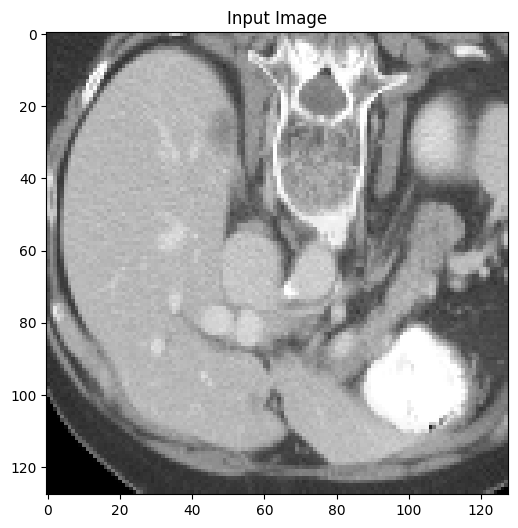

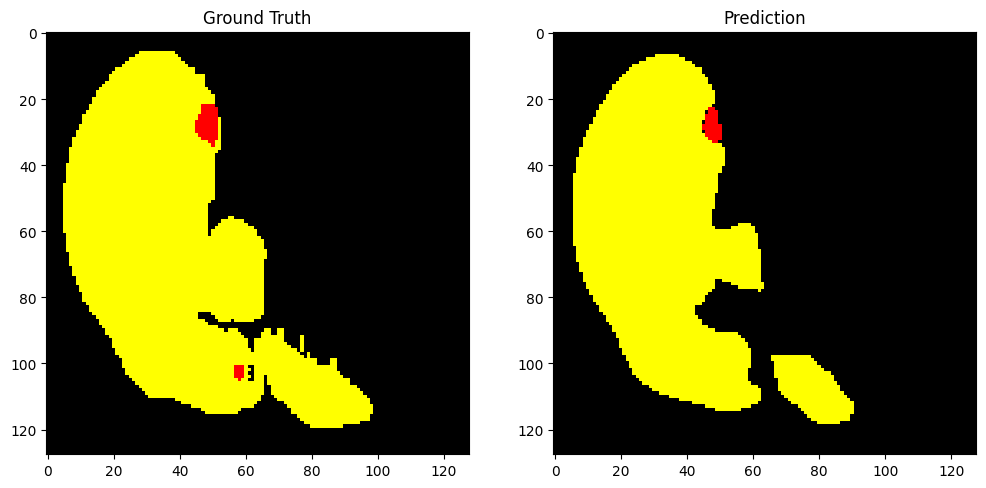

In [19]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)